<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/RFF-UNET_Brachial-Plexus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam,SGD
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O train.zip && rm -rf /tmp/cookies.txt


FILEID = "1mi69Hm_1L0ZfbtKaJbuzfymS3EubsKPy"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O test.zip && rm -rf /tmp/cookies.txt

--2021-07-19 13:22:31--  https://docs.google.com/uc?export=download&confirm=PeVC&id=1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH
Resolving docs.google.com (docs.google.com)... 74.125.142.138, 74.125.142.100, 74.125.142.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-28-docs.googleusercontent.com/docs/securesc/sobcljqlqo0ofh9sproj3ml3cj9r8muu/1fu9o0rob2stj9m1979la4c1cqqh8q1t/1626700950000/05137136237839183901/14447119141238219168Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download [following]
--2021-07-19 13:22:31--  https://doc-0s-28-docs.googleusercontent.com/docs/securesc/sobcljqlqo0ofh9sproj3ml3cj9r8muu/1fu9o0rob2stj9m1979la4c1cqqh8q1t/1626700950000/05137136237839183901/14447119141238219168Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download
Resolving doc-0s-28-docs.googleusercontent.com (doc-0s-28-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

In [ ]:
!mkdir train
#!mkdir test
!unzip -q train -d train
#!unzip -q test.zip -d test

In [ ]:
files_path = glob('./train/*.tif')
files_path = [filepath_ for filepath_ in files_path if 'mask' not in filepath_]
files_mask = [files[:-4]+'_mask.tif' for files in files_path]

# files_path_test = glob('./test/*.tif')
# files_path_test = [filepath_ for filepath_ in files_path_test if 'mask' not in filepath_]
# files_mask_test = [files[:-4]+'_mask.tif' for files in files_path_test]

In [ ]:
void = [np.unique(cv2.imread(mask,cv2.IMREAD_GRAYSCALE)).size==2 for mask in files_mask]
print('All have nerve in train?: {}'.format(np.all(void)))

All have nerve in train?: False


In [ ]:
for_test_files,for_test_mask = [files for c,files in zip(void,files_path) if not(c)],[mask for c,mask in zip(void,files_mask) if not(c)]
files_path,files_mask = [files for c,files in zip(void,files_path) if c],[mask for c,mask in zip(void,files_mask) if c]

# df_train = pd.DataFrame({'filepath':files_path,'mask':files_mask})
# df_test_images = pd.DataFrame({'filepath':files_path_test + for_test_files,'mask':files_mask_test+for_test_mask})

### Split sets

In [ ]:
files_path,files_path_test,files_mask,files_mask_test = train_test_split(np.array(files_path),
                                                                         np.array(files_mask),
                                                                         test_size=0.2)
df_train = pd.DataFrame({'filepath':files_path.tolist(),'mask':files_mask.tolist()})
df_test_images = pd.DataFrame({'filepath':files_path_test.tolist(),
                               'mask':files_mask_test.tolist()})

In [ ]:
df_test_images

,filepath,mask
0,./train/44_46.tif,./train/44_46_mask.tif
1,./train/13_12.tif,./train/13_12_mask.tif
2,./train/37_37.tif,./train/37_37_mask.tif
3,./train/37_89.tif,./train/37_89_mask.tif
4,./train/31_76.tif,./train/31_76_mask.tif
...,...,...
460,./train/40_47.tif,./train/40_47_mask.tif
461,./train/44_6.tif,./train/44_6_mask.tif
462,./train/29_73.tif,./train/29_73_mask.tif
463,./train/18_2.tif,./train/18_2_mask.tif


In [ ]:
df_train_images,df_val_images = train_test_split(df_train, test_size=0.2)
# df_train_images,df_val_images = train_test_split(df_train_images, test_size=0.2)

In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1992
batch_size = 32
height,width = 128,128
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1486 validated image filenames.
Found 1486 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.
Found 465 validated image filenames.
Found 465 validated image filenames.


Shape_in: (32, 128, 128, 3)


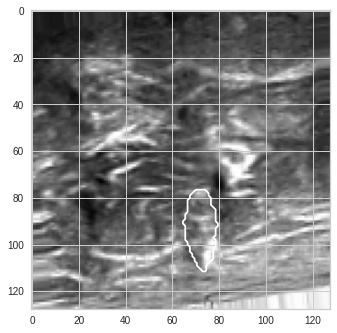

array([0., 1.], dtype=float32)

In [ ]:
i,j = next(test_gen)
print('Shape_in: {}'.format(i.shape))
plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0])
plt.contour(edges_est,[0.5])
plt.show()
np.unique(j[0,:,:,0])

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred) - iou(y_true,y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
UPSAMPLE_MODE = 'SIMPLE' # SIMPLE'
NET_SCALING = None
GAUSSIAN_NOISE = 0.1
EDGE_CROP = 16
ACTIVATION = 'relu'
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

def create_model(phi_units = 2):
  input_img = layers.Input((width,height,3), name = 'RGB_Input')
  pp_in_layer = input_img
  if NET_SCALING is not None:
      pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
      
  # pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
  pp_in_layer = layers.BatchNormalization()(pp_in_layer)

  c1 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (pp_in_layer)
  # c1 = layers.BatchNormalization()(c1)
  c1 = layers.Conv2D(8, (3, 3), padding='same') (c1)
  # c1 = layers.BatchNormalization()(c1)
  p1 = layers.MaxPooling2D((2, 2)) (c1)

  c2 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (p1)
  # c2 = layers.BatchNormalization()(c2)
  c2 = layers.Conv2D(16, (3, 3), padding='same') (c2)
  # c2 = layers.BatchNormalization()(c2)
  p2 = layers.MaxPooling2D((2, 2)) (c2)

  c3 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (p2)
  # c3 = layers.BatchNormalization()(c3)
  c3 = layers.Conv2D(32, (3, 3), padding='same') (c3)
  # c3 = layers.BatchNormalization()(c3)
  p3 = layers.MaxPooling2D((2, 2)) (c3)

  c4 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (p3)
  # c4 = layers.BatchNormalization()(c4)
  c4 = layers.Conv2D(64, (3, 3), padding='same') (c4)
  # c4 = layers.BatchNormalization()(c4)
  p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
  #%% Modified by CAJ
  flatten = layers.Flatten()(p4)
  rff = RandomFourierFeatures(output_dim=int(height/16)*int(width/16)*phi_units,
                              trainable=True,
                              name = 'Phi')(flatten)
  resha = layers.Reshape((int(height/16),int(width/16),-1))(rff)
  #%% End modify
  c5 = layers.Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (resha)#(p4)
  # c5 = layers.BatchNormalization()(c5)
  c5 = layers.Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (c5)
  # c5 = layers.BatchNormalization()(c5)

  u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = layers.concatenate([u6, c4])
  c6 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (u6)
  # c6 = layers.BatchNormalization()(c6)
  c6 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (c6)
  # c6 = layers.BatchNormalization()(c6)

  u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = layers.concatenate([u7, c3])
  c7 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (u7)
  # c7 = layers.BatchNormalization()(c7)
  c7 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (c7)
  # c7 = layers.BatchNormalization()(c7)

  u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = layers.concatenate([u8, c2])
  c8 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (u8)
  # c8 = layers.BatchNormalization()(c8)
  c8 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (c8)
  # c8 = layers.BatchNormalization()(c8)

  u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = layers.concatenate([u9, c1], axis=3)
  c9 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (u9)
  # c9 = layers.BatchNormalization()(c9)
  c9 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (c9)
  # c9 = layers.BatchNormalization()(c9)

  d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
  d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
  d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP),name='output')(d)
  if NET_SCALING is not None:
      d = layers.UpSampling2D(NET_SCALING)(d)

  seg_model = models.Model(inputs=[input_img], outputs=[d])
  
  return seg_model

seg_model = create_model(2)

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
______________________________________________________________________________________________

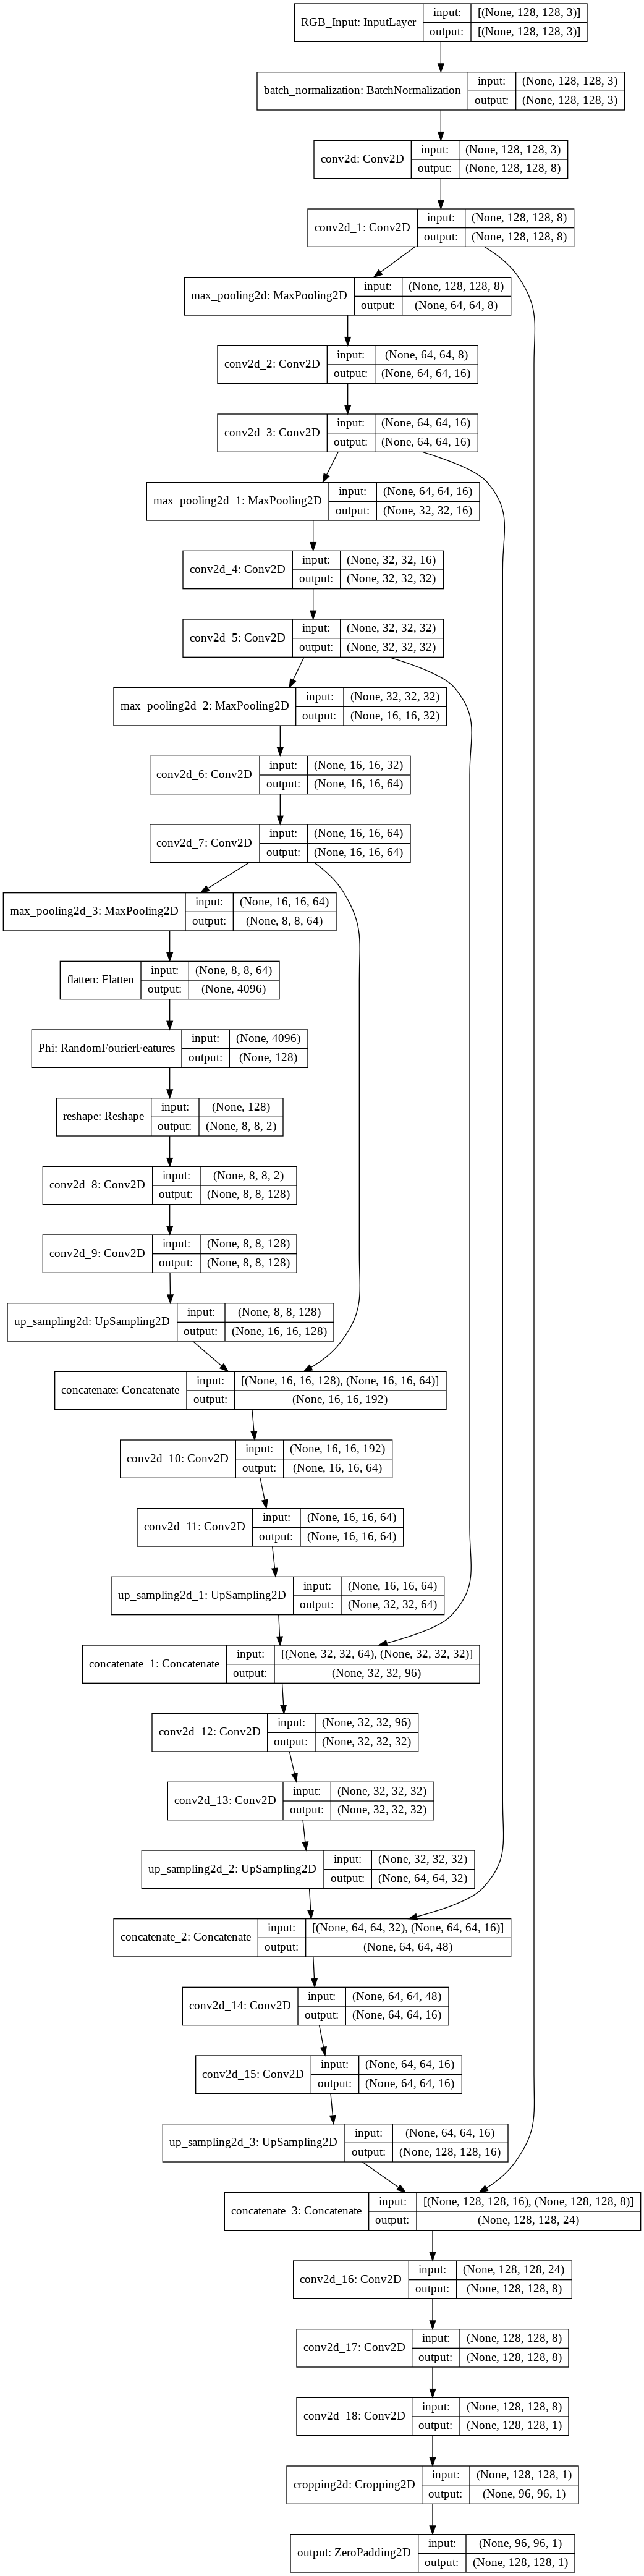

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 36s 407ms/step - loss: -0.1933 - iou: 0.0674 - dice_coef: 0.1258 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9553 - val_loss: -0.2264 - val_iou: 0.0794 - val_dice_coef: 0.1470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8843


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 425ms/step - loss: -0.4560 - iou: 0.1684 - dice_coef: 0.2852 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9375 - val_loss: -0.4012 - val_iou: 0.1463 - val_dice_coef: 0.2549 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9150


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 413ms/step - loss: -0.7623 - iou: 0.3009 - dice_coef: 0.4601 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9610 - val_loss: -0.1929 - val_iou: 0.0674 - val_dice_coef: 0.1255 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9681


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 18s 402ms/step - loss: -0.9116 - iou: 0.3713 - dice_coef: 0.5384 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9690 - val_loss: -0.2646 - val_iou: 0.0939 - val_dice_coef: 0.1707 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9688


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 428ms/step - loss: -0.9585 - iou: 0.3958 - dice_coef: 0.5640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9705 - val_loss: -0.6723 - val_iou: 0.2616 - val_dice_coef: 0.4108 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9702


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 19s 422ms/step - loss: -1.0047 - iou: 0.4169 - dice_coef: 0.5854 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9715 - val_loss: -0.8109 - val_iou: 0.3250 - val_dice_coef: 0.4859 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9726


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 19s 426ms/step - loss: -1.0356 - iou: 0.4336 - dice_coef: 0.6019 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9729 - val_loss: -0.9359 - val_iou: 0.3855 - val_dice_coef: 0.5504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9732


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 18s 404ms/step - loss: -1.0622 - iou: 0.4472 - dice_coef: 0.6164 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9739 - val_loss: -0.8779 - val_iou: 0.3573 - val_dice_coef: 0.5206 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9746


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 19s 413ms/step - loss: -1.0747 - iou: 0.4537 - dice_coef: 0.6218 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9745 - val_loss: -1.0314 - val_iou: 0.4328 - val_dice_coef: 0.5986 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9746


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 426ms/step - loss: -1.0909 - iou: 0.4632 - dice_coef: 0.6297 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -1.0331 - val_iou: 0.4323 - val_dice_coef: 0.6008 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9712


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 18s 405ms/step - loss: -1.1019 - iou: 0.4681 - dice_coef: 0.6344 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -1.0575 - val_iou: 0.4460 - val_dice_coef: 0.6115 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9731


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 19s 413ms/step - loss: -1.1052 - iou: 0.4677 - dice_coef: 0.6353 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -1.0701 - val_iou: 0.4514 - val_dice_coef: 0.6186 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9730


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 427ms/step - loss: -1.1230 - iou: 0.4790 - dice_coef: 0.6454 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -1.0734 - val_iou: 0.4548 - val_dice_coef: 0.6186 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9731


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 18s 402ms/step - loss: -1.1571 - iou: 0.4958 - dice_coef: 0.6608 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -1.0655 - val_iou: 0.4490 - val_dice_coef: 0.6165 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 19s 413ms/step - loss: -1.1458 - iou: 0.4908 - dice_coef: 0.6555 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -1.0951 - val_iou: 0.4663 - val_dice_coef: 0.6288 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 19s 422ms/step - loss: -1.1638 - iou: 0.4994 - dice_coef: 0.6633 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9774 - val_loss: -1.0922 - val_iou: 0.4659 - val_dice_coef: 0.6263 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 18s 405ms/step - loss: -1.1813 - iou: 0.5097 - dice_coef: 0.6725 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -1.0887 - val_iou: 0.4647 - val_dice_coef: 0.6239 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 19s 415ms/step - loss: -1.1683 - iou: 0.5018 - dice_coef: 0.6658 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -1.1177 - val_iou: 0.4776 - val_dice_coef: 0.6401 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 19s 429ms/step - loss: -1.2070 - iou: 0.5226 - dice_coef: 0.6831 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9790 - val_loss: -1.1422 - val_iou: 0.4878 - val_dice_coef: 0.6544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 18s 405ms/step - loss: -1.1848 - iou: 0.5110 - dice_coef: 0.6736 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -1.1143 - val_iou: 0.4737 - val_dice_coef: 0.6406 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 19s 417ms/step - loss: -1.2030 - iou: 0.5207 - dice_coef: 0.6812 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -1.1497 - val_iou: 0.4957 - val_dice_coef: 0.6541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 19s 420ms/step - loss: -1.2239 - iou: 0.5326 - dice_coef: 0.6920 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -1.1576 - val_iou: 0.4987 - val_dice_coef: 0.6589 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 432ms/step - loss: -1.2157 - iou: 0.5288 - dice_coef: 0.6887 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -1.1384 - val_iou: 0.4904 - val_dice_coef: 0.6480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 18s 408ms/step - loss: -1.2345 - iou: 0.5385 - dice_coef: 0.6967 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -1.1734 - val_iou: 0.5060 - val_dice_coef: 0.6674 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 18s 402ms/step - loss: -1.2481 - iou: 0.5463 - dice_coef: 0.7028 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -1.1995 - val_iou: 0.5182 - val_dice_coef: 0.6812 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 19s 431ms/step - loss: -1.2478 - iou: 0.5446 - dice_coef: 0.7019 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -1.1499 - val_iou: 0.4942 - val_dice_coef: 0.6558 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 18s 405ms/step - loss: -1.2319 - iou: 0.5365 - dice_coef: 0.6952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9797 - val_loss: -1.1503 - val_iou: 0.4990 - val_dice_coef: 0.6513 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 18s 405ms/step - loss: -1.2714 - iou: 0.5591 - dice_coef: 0.7138 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -1.1915 - val_iou: 0.5163 - val_dice_coef: 0.6752 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 19s 431ms/step - loss: -1.2573 - iou: 0.5501 - dice_coef: 0.7067 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -1.1879 - val_iou: 0.5126 - val_dice_coef: 0.6753 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 18s 405ms/step - loss: -1.2789 - iou: 0.5627 - dice_coef: 0.7172 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -1.1467 - val_iou: 0.4957 - val_dice_coef: 0.6510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 18s 409ms/step - loss: -1.2731 - iou: 0.5587 - dice_coef: 0.7146 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -1.1947 - val_iou: 0.5168 - val_dice_coef: 0.6778 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 19s 431ms/step - loss: -1.2831 - iou: 0.5645 - dice_coef: 0.7194 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -1.2199 - val_iou: 0.5303 - val_dice_coef: 0.6897 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 18s 406ms/step - loss: -1.2944 - iou: 0.5714 - dice_coef: 0.7243 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -1.2033 - val_iou: 0.5244 - val_dice_coef: 0.6789 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 18s 408ms/step - loss: -1.2925 - iou: 0.5702 - dice_coef: 0.7219 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -1.2164 - val_iou: 0.5281 - val_dice_coef: 0.6882 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 19s 430ms/step - loss: -1.2997 - iou: 0.5743 - dice_coef: 0.7257 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -1.1870 - val_iou: 0.5178 - val_dice_coef: 0.6692 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 19s 425ms/step - loss: -1.3016 - iou: 0.5751 - dice_coef: 0.7263 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -1.2084 - val_iou: 0.5278 - val_dice_coef: 0.6806 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 18s 410ms/step - loss: -1.3076 - iou: 0.5781 - dice_coef: 0.7300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -1.2246 - val_iou: 0.5337 - val_dice_coef: 0.6910 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 18s 403ms/step - loss: -1.3007 - iou: 0.5750 - dice_coef: 0.7267 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -1.2434 - val_iou: 0.5438 - val_dice_coef: 0.6995 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 19s 430ms/step - loss: -1.3202 - iou: 0.5849 - dice_coef: 0.7343 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.2462 - val_iou: 0.5452 - val_dice_coef: 0.7010 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3059 - iou: 0.5773 - dice_coef: 0.7297 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -1.2692 - val_iou: 0.5571 - val_dice_coef: 0.7122 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 18s 404ms/step - loss: -1.3153 - iou: 0.5820 - dice_coef: 0.7329 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.2032 - val_iou: 0.5255 - val_dice_coef: 0.6777 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 19s 432ms/step - loss: -1.3312 - iou: 0.5911 - dice_coef: 0.7402 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -1.2436 - val_iou: 0.5429 - val_dice_coef: 0.7007 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3277 - iou: 0.5890 - dice_coef: 0.7379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -1.2362 - val_iou: 0.5439 - val_dice_coef: 0.6923 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 18s 403ms/step - loss: -1.3277 - iou: 0.5899 - dice_coef: 0.7379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -1.2260 - val_iou: 0.5365 - val_dice_coef: 0.6894 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3285 - iou: 0.5912 - dice_coef: 0.7390 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -1.2690 - val_iou: 0.5567 - val_dice_coef: 0.7123 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 18s 408ms/step - loss: -1.3325 - iou: 0.5920 - dice_coef: 0.7401 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -1.2682 - val_iou: 0.5570 - val_dice_coef: 0.7113 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 18s 404ms/step - loss: -1.3433 - iou: 0.5983 - dice_coef: 0.7450 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2575 - val_iou: 0.5512 - val_dice_coef: 0.7064 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3388 - iou: 0.5954 - dice_coef: 0.7434 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -1.2340 - val_iou: 0.5455 - val_dice_coef: 0.6885 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3563 - iou: 0.5992 - dice_coef: 0.7464 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -1.2594 - val_iou: 0.5569 - val_dice_coef: 0.7025 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 18s 402ms/step - loss: -1.3534 - iou: 0.6042 - dice_coef: 0.7488 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836 - val_loss: -1.2544 - val_iou: 0.5532 - val_dice_coef: 0.7013 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 19s 432ms/step - loss: -1.3591 - iou: 0.6064 - dice_coef: 0.7514 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -1.2744 - val_iou: 0.5610 - val_dice_coef: 0.7134 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3506 - iou: 0.6019 - dice_coef: 0.7478 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2622 - val_iou: 0.5581 - val_dice_coef: 0.7041 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3696 - iou: 0.6123 - dice_coef: 0.7562 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2825 - val_iou: 0.5661 - val_dice_coef: 0.7164 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 18s 405ms/step - loss: -1.3596 - iou: 0.6073 - dice_coef: 0.7517 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -1.2707 - val_iou: 0.5580 - val_dice_coef: 0.7127 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 19s 421ms/step - loss: -1.3475 - iou: 0.6006 - dice_coef: 0.7467 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2817 - val_iou: 0.5649 - val_dice_coef: 0.7168 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 419ms/step - loss: -1.3675 - iou: 0.6118 - dice_coef: 0.7554 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.2623 - val_iou: 0.5551 - val_dice_coef: 0.7071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 18s 404ms/step - loss: -1.3633 - iou: 0.6095 - dice_coef: 0.7537 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -1.2577 - val_iou: 0.5556 - val_dice_coef: 0.7020 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 19s 423ms/step - loss: -1.3721 - iou: 0.6150 - dice_coef: 0.7577 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -1.2895 - val_iou: 0.5692 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 417ms/step - loss: -1.3607 - iou: 0.6073 - dice_coef: 0.7527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.2375 - val_iou: 0.5469 - val_dice_coef: 0.6906 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 18s 407ms/step - loss: -1.3691 - iou: 0.6138 - dice_coef: 0.7569 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -1.3199 - val_iou: 0.5856 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 19s 424ms/step - loss: -1.3725 - iou: 0.6137 - dice_coef: 0.7574 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2449 - val_iou: 0.5490 - val_dice_coef: 0.6959 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3849 - iou: 0.6220 - dice_coef: 0.7641 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.3239 - val_iou: 0.5865 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 18s 404ms/step - loss: -1.3828 - iou: 0.6207 - dice_coef: 0.7633 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.2488 - val_iou: 0.5526 - val_dice_coef: 0.6961 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 19s 429ms/step - loss: -1.3754 - iou: 0.6152 - dice_coef: 0.7589 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.3127 - val_iou: 0.5803 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3804 - iou: 0.6203 - dice_coef: 0.7613 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.2633 - val_iou: 0.5604 - val_dice_coef: 0.7029 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4013 - iou: 0.6296 - dice_coef: 0.7696 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.3288 - val_iou: 0.5897 - val_dice_coef: 0.7391 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 18s 410ms/step - loss: -1.3806 - iou: 0.6204 - dice_coef: 0.7616 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.2840 - val_iou: 0.5665 - val_dice_coef: 0.7176 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3783 - iou: 0.6186 - dice_coef: 0.7607 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2988 - val_iou: 0.5786 - val_dice_coef: 0.7202 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4014 - iou: 0.6313 - dice_coef: 0.7701 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2863 - val_iou: 0.5715 - val_dice_coef: 0.7147 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 18s 404ms/step - loss: -1.3850 - iou: 0.6223 - dice_coef: 0.7641 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -1.3146 - val_iou: 0.5819 - val_dice_coef: 0.7327 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 19s 415ms/step - loss: -1.3958 - iou: 0.6266 - dice_coef: 0.7674 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2901 - val_iou: 0.5722 - val_dice_coef: 0.7180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4018 - iou: 0.6311 - dice_coef: 0.7693 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2670 - val_iou: 0.5624 - val_dice_coef: 0.7046 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 18s 404ms/step - loss: -1.4045 - iou: 0.6324 - dice_coef: 0.7725 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2992 - val_iou: 0.5759 - val_dice_coef: 0.7233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4068 - iou: 0.6340 - dice_coef: 0.7722 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2858 - val_iou: 0.5712 - val_dice_coef: 0.7146 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4136 - iou: 0.6381 - dice_coef: 0.7755 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.3383 - val_iou: 0.5951 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 18s 402ms/step - loss: -1.3954 - iou: 0.6294 - dice_coef: 0.7675 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.4795 - val_iou: 0.1781 - val_dice_coef: 0.3014 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9556


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4029 - iou: 0.6325 - dice_coef: 0.7703 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2827 - val_iou: 0.5695 - val_dice_coef: 0.7132 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4093 - iou: 0.6360 - dice_coef: 0.7738 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.3153 - val_iou: 0.5831 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4081 - iou: 0.6358 - dice_coef: 0.7729 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.3322 - val_iou: 0.5936 - val_dice_coef: 0.7386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4008 - iou: 0.6326 - dice_coef: 0.7700 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.3238 - val_iou: 0.5877 - val_dice_coef: 0.7361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 18s 402ms/step - loss: -1.4142 - iou: 0.6390 - dice_coef: 0.7767 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3197 - val_iou: 0.5856 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4209 - iou: 0.6432 - dice_coef: 0.7785 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.3021 - val_iou: 0.5784 - val_dice_coef: 0.7237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 18s 405ms/step - loss: -1.4144 - iou: 0.6384 - dice_coef: 0.7761 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3278 - val_iou: 0.5900 - val_dice_coef: 0.7378 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 18s 403ms/step - loss: -1.4180 - iou: 0.6409 - dice_coef: 0.7778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2888 - val_iou: 0.5749 - val_dice_coef: 0.7140 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4165 - iou: 0.6402 - dice_coef: 0.7765 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.3007 - val_iou: 0.5787 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4213 - iou: 0.6425 - dice_coef: 0.7789 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3003 - val_iou: 0.5787 - val_dice_coef: 0.7216 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4183 - iou: 0.6415 - dice_coef: 0.7783 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.3239 - val_iou: 0.5886 - val_dice_coef: 0.7353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4160 - iou: 0.6398 - dice_coef: 0.7771 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.2900 - val_iou: 0.5733 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 18s 405ms/step - loss: -1.4312 - iou: 0.6476 - dice_coef: 0.7835 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3534 - val_iou: 0.6037 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4314 - iou: 0.6480 - dice_coef: 0.7830 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3038 - val_iou: 0.5791 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4292 - iou: 0.6475 - dice_coef: 0.7825 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3004 - val_iou: 0.5788 - val_dice_coef: 0.7217 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 18s 405ms/step - loss: -1.4317 - iou: 0.6480 - dice_coef: 0.7821 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3206 - val_iou: 0.5904 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4314 - iou: 0.6482 - dice_coef: 0.7841 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3189 - val_iou: 0.5859 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 433ms/step - loss: -1.4324 - iou: 0.6496 - dice_coef: 0.7833 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.2982 - val_iou: 0.5786 - val_dice_coef: 0.7197 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4281 - iou: 0.6468 - dice_coef: 0.7813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3194 - val_iou: 0.5888 - val_dice_coef: 0.7306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4497 - iou: 0.6519 - dice_coef: 0.7858 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3250 - val_iou: 0.5891 - val_dice_coef: 0.7359 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 18s 405ms/step - loss: -1.4253 - iou: 0.6460 - dice_coef: 0.7811 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.3495 - val_iou: 0.6031 - val_dice_coef: 0.7464 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 21s 457ms/step - loss: -1.4291 - iou: 0.6469 - dice_coef: 0.7818 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.2984 - val_iou: 0.5787 - val_dice_coef: 0.7197 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4273 - iou: 0.6467 - dice_coef: 0.7813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3452 - val_iou: 0.6010 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4360 - iou: 0.6518 - dice_coef: 0.7854 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.2833 - val_iou: 0.5704 - val_dice_coef: 0.7128 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4374 - iou: 0.6528 - dice_coef: 0.7848 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3188 - val_iou: 0.5877 - val_dice_coef: 0.7311 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 18s 409ms/step - loss: -1.4382 - iou: 0.6531 - dice_coef: 0.7853 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3683 - val_iou: 0.6121 - val_dice_coef: 0.7562 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4307 - iou: 0.6496 - dice_coef: 0.7826 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.2997 - val_iou: 0.5782 - val_dice_coef: 0.7215 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4346 - iou: 0.6508 - dice_coef: 0.7850 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3406 - val_iou: 0.5973 - val_dice_coef: 0.7433 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 18s 405ms/step - loss: -1.4417 - iou: 0.6535 - dice_coef: 0.7870 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3474 - val_iou: 0.5998 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4411 - iou: 0.6540 - dice_coef: 0.7872 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3279 - val_iou: 0.5929 - val_dice_coef: 0.7350 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4374 - iou: 0.6522 - dice_coef: 0.7855 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.2953 - val_iou: 0.5754 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4385 - iou: 0.6529 - dice_coef: 0.7859 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3435 - val_iou: 0.5994 - val_dice_coef: 0.7441 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4435 - iou: 0.6562 - dice_coef: 0.7876 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3257 - val_iou: 0.5915 - val_dice_coef: 0.7342 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4544 - iou: 0.6624 - dice_coef: 0.7936 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3401 - val_iou: 0.5972 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4468 - iou: 0.6566 - dice_coef: 0.7895 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3448 - val_iou: 0.6011 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4537 - iou: 0.6606 - dice_coef: 0.7920 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3321 - val_iou: 0.5958 - val_dice_coef: 0.7363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 18s 404ms/step - loss: -1.4465 - iou: 0.6582 - dice_coef: 0.7901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.2976 - val_iou: 0.5790 - val_dice_coef: 0.7186 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4541 - iou: 0.6604 - dice_coef: 0.7926 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.2861 - val_iou: 0.5734 - val_dice_coef: 0.7127 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4490 - iou: 0.6586 - dice_coef: 0.7908 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3117 - val_iou: 0.5863 - val_dice_coef: 0.7255 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4640 - iou: 0.6664 - dice_coef: 0.7975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3021 - val_iou: 0.5802 - val_dice_coef: 0.7218 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4542 - iou: 0.6620 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3298 - val_iou: 0.5922 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4654 - iou: 0.6671 - dice_coef: 0.7969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3428 - val_iou: 0.6033 - val_dice_coef: 0.7395 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 18s 405ms/step - loss: -1.4541 - iou: 0.6610 - dice_coef: 0.7921 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3431 - val_iou: 0.5988 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 19s 433ms/step - loss: -1.4520 - iou: 0.6605 - dice_coef: 0.7922 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3249 - val_iou: 0.5897 - val_dice_coef: 0.7352 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4479 - iou: 0.6586 - dice_coef: 0.7895 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.2944 - val_iou: 0.5793 - val_dice_coef: 0.7151 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 18s 404ms/step - loss: -1.4659 - iou: 0.6686 - dice_coef: 0.7975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3539 - val_iou: 0.6043 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4571 - iou: 0.6630 - dice_coef: 0.7941 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3378 - val_iou: 0.5966 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4597 - iou: 0.6655 - dice_coef: 0.7942 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3379 - val_iou: 0.5976 - val_dice_coef: 0.7403 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4650 - iou: 0.6683 - dice_coef: 0.7966 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3134 - val_iou: 0.5896 - val_dice_coef: 0.7238 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4613 - iou: 0.6657 - dice_coef: 0.7957 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3796 - val_iou: 0.6185 - val_dice_coef: 0.7612 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4578 - iou: 0.6646 - dice_coef: 0.7950 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3391 - val_iou: 0.5977 - val_dice_coef: 0.7414 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4681 - iou: 0.6702 - dice_coef: 0.7988 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3246 - val_iou: 0.5906 - val_dice_coef: 0.7340 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4506 - iou: 0.6602 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3567 - val_iou: 0.6056 - val_dice_coef: 0.7511 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4688 - iou: 0.6697 - dice_coef: 0.7988 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3662 - val_iou: 0.6120 - val_dice_coef: 0.7542 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4607 - iou: 0.6657 - dice_coef: 0.7961 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.2867 - val_iou: 0.5728 - val_dice_coef: 0.7139 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4666 - iou: 0.6684 - dice_coef: 0.7975 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3381 - val_iou: 0.6015 - val_dice_coef: 0.7367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4580 - iou: 0.6648 - dice_coef: 0.7938 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3557 - val_iou: 0.6056 - val_dice_coef: 0.7501 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4707 - iou: 0.6712 - dice_coef: 0.7986 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3313 - val_iou: 0.5943 - val_dice_coef: 0.7370 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 18s 403ms/step - loss: -1.4673 - iou: 0.6704 - dice_coef: 0.7976 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3432 - val_iou: 0.5991 - val_dice_coef: 0.7441 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4595 - iou: 0.6649 - dice_coef: 0.7938 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3640 - val_iou: 0.6115 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4725 - iou: 0.6728 - dice_coef: 0.8009 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3234 - val_iou: 0.5928 - val_dice_coef: 0.7306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4652 - iou: 0.6673 - dice_coef: 0.7956 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3536 - val_iou: 0.6056 - val_dice_coef: 0.7480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4532 - iou: 0.6617 - dice_coef: 0.7928 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3601 - val_iou: 0.6084 - val_dice_coef: 0.7517 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4692 - iou: 0.6705 - dice_coef: 0.7980 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3677 - val_iou: 0.6131 - val_dice_coef: 0.7546 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4759 - iou: 0.6744 - dice_coef: 0.8014 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3208 - val_iou: 0.5913 - val_dice_coef: 0.7295 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 18s 409ms/step - loss: -1.4668 - iou: 0.6700 - dice_coef: 0.7968 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3219 - val_iou: 0.5952 - val_dice_coef: 0.7266 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4811 - iou: 0.6698 - dice_coef: 0.7975 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3423 - val_iou: 0.6001 - val_dice_coef: 0.7422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4720 - iou: 0.6722 - dice_coef: 0.7994 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3251 - val_iou: 0.5951 - val_dice_coef: 0.7300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4744 - iou: 0.6734 - dice_coef: 0.8007 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3132 - val_iou: 0.5879 - val_dice_coef: 0.7253 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4753 - iou: 0.6745 - dice_coef: 0.8019 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3420 - val_iou: 0.6013 - val_dice_coef: 0.7407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4770 - iou: 0.6751 - dice_coef: 0.8024 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3686 - val_iou: 0.6142 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4807 - iou: 0.6778 - dice_coef: 0.8042 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3765 - val_iou: 0.6178 - val_dice_coef: 0.7587 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4698 - iou: 0.6699 - dice_coef: 0.7984 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3565 - val_iou: 0.6068 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4763 - iou: 0.6751 - dice_coef: 0.8020 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3585 - val_iou: 0.6085 - val_dice_coef: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4762 - iou: 0.6747 - dice_coef: 0.8014 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3284 - val_iou: 0.5960 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4847 - iou: 0.6797 - dice_coef: 0.8055 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3471 - val_iou: 0.6035 - val_dice_coef: 0.7436 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4740 - iou: 0.6727 - dice_coef: 0.8004 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3465 - val_iou: 0.6034 - val_dice_coef: 0.7430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4738 - iou: 0.6735 - dice_coef: 0.8007 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3539 - val_iou: 0.6059 - val_dice_coef: 0.7480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4828 - iou: 0.6779 - dice_coef: 0.8039 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3663 - val_iou: 0.6112 - val_dice_coef: 0.7551 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4791 - iou: 0.6753 - dice_coef: 0.8026 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3469 - val_iou: 0.6023 - val_dice_coef: 0.7446 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4897 - iou: 0.6820 - dice_coef: 0.8075 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3646 - val_iou: 0.6107 - val_dice_coef: 0.7539 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4719 - iou: 0.6723 - dice_coef: 0.8002 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3499 - val_iou: 0.6048 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4867 - iou: 0.6806 - dice_coef: 0.8072 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3095 - val_iou: 0.5848 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4865 - iou: 0.6802 - dice_coef: 0.8052 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3035 - val_iou: 0.5831 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4798 - iou: 0.6780 - dice_coef: 0.8032 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3401 - val_iou: 0.5978 - val_dice_coef: 0.7422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4885 - iou: 0.6821 - dice_coef: 0.8072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3374 - val_iou: 0.6009 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4872 - iou: 0.6794 - dice_coef: 0.8059 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3589 - val_iou: 0.6082 - val_dice_coef: 0.7507 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4902 - iou: 0.6829 - dice_coef: 0.8071 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3475 - val_iou: 0.6047 - val_dice_coef: 0.7428 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4917 - iou: 0.6837 - dice_coef: 0.8085 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3685 - val_iou: 0.6148 - val_dice_coef: 0.7537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4942 - iou: 0.6848 - dice_coef: 0.8092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3573 - val_iou: 0.6065 - val_dice_coef: 0.7508 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4780 - iou: 0.6755 - dice_coef: 0.8036 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3583 - val_iou: 0.6078 - val_dice_coef: 0.7505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4911 - iou: 0.6834 - dice_coef: 0.8075 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3160 - val_iou: 0.5892 - val_dice_coef: 0.7268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4842 - iou: 0.6809 - dice_coef: 0.8049 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3478 - val_iou: 0.6031 - val_dice_coef: 0.7447 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4832 - iou: 0.6794 - dice_coef: 0.8040 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3636 - val_iou: 0.6099 - val_dice_coef: 0.7537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 18s 409ms/step - loss: -1.4844 - iou: 0.6797 - dice_coef: 0.8053 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3649 - val_iou: 0.6100 - val_dice_coef: 0.7549 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4914 - iou: 0.6837 - dice_coef: 0.8083 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3399 - val_iou: 0.6008 - val_dice_coef: 0.7391 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 20s 438ms/step - loss: -1.5039 - iou: 0.6901 - dice_coef: 0.8133 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3675 - val_iou: 0.6115 - val_dice_coef: 0.7560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 18s 409ms/step - loss: -1.4858 - iou: 0.6800 - dice_coef: 0.8055 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3687 - val_iou: 0.6163 - val_dice_coef: 0.7524 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4983 - iou: 0.6871 - dice_coef: 0.8112 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3840 - val_iou: 0.6217 - val_dice_coef: 0.7624 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4945 - iou: 0.6849 - dice_coef: 0.8098 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3180 - val_iou: 0.5901 - val_dice_coef: 0.7279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4913 - iou: 0.6836 - dice_coef: 0.8078 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.4131 - val_iou: 0.1518 - val_dice_coef: 0.2613 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9515


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4983 - iou: 0.6871 - dice_coef: 0.8113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3345 - val_iou: 0.5999 - val_dice_coef: 0.7347 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4943 - iou: 0.6850 - dice_coef: 0.8093 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3437 - val_iou: 0.6004 - val_dice_coef: 0.7433 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4941 - iou: 0.6854 - dice_coef: 0.8086 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3622 - val_iou: 0.6100 - val_dice_coef: 0.7522 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4933 - iou: 0.6853 - dice_coef: 0.8086 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3462 - val_iou: 0.6022 - val_dice_coef: 0.7440 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4779 - iou: 0.6764 - dice_coef: 0.8025 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3210 - val_iou: 0.5928 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 20s 434ms/step - loss: -1.5015 - iou: 0.6906 - dice_coef: 0.8127 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3413 - val_iou: 0.6023 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4986 - iou: 0.6883 - dice_coef: 0.8116 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3364 - val_iou: 0.5969 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4935 - iou: 0.6845 - dice_coef: 0.8086 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3254 - val_iou: 0.5938 - val_dice_coef: 0.7316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4936 - iou: 0.6854 - dice_coef: 0.8091 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3724 - val_iou: 0.6162 - val_dice_coef: 0.7562 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 19s 411ms/step - loss: -1.5033 - iou: 0.6917 - dice_coef: 0.8137 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3204 - val_iou: 0.5945 - val_dice_coef: 0.7259 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4968 - iou: 0.6870 - dice_coef: 0.8099 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3712 - val_iou: 0.6154 - val_dice_coef: 0.7558 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4999 - iou: 0.6887 - dice_coef: 0.8112 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3100 - val_iou: 0.5862 - val_dice_coef: 0.7238 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 19s 413ms/step - loss: -1.5096 - iou: 0.6870 - dice_coef: 0.8115 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3609 - val_iou: 0.6104 - val_dice_coef: 0.7505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 18s 406ms/step - loss: -1.4994 - iou: 0.6895 - dice_coef: 0.8108 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3681 - val_iou: 0.6124 - val_dice_coef: 0.7557 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 20s 435ms/step - loss: -1.5028 - iou: 0.6910 - dice_coef: 0.8127 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3354 - val_iou: 0.5970 - val_dice_coef: 0.7384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 18s 408ms/step - loss: -1.5066 - iou: 0.6915 - dice_coef: 0.8143 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3324 - val_iou: 0.5995 - val_dice_coef: 0.7329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 18s 407ms/step - loss: -1.4949 - iou: 0.6869 - dice_coef: 0.8096 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3630 - val_iou: 0.6104 - val_dice_coef: 0.7526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 20s 436ms/step - loss: -1.5075 - iou: 0.6937 - dice_coef: 0.8150 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3204 - val_iou: 0.5902 - val_dice_coef: 0.7302 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5028 - iou: 0.6888 - dice_coef: 0.8128 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3601 - val_iou: 0.6091 - val_dice_coef: 0.7510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4983 - iou: 0.6868 - dice_coef: 0.8110 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3734 - val_iou: 0.6153 - val_dice_coef: 0.7580 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 19s 411ms/step - loss: -1.5037 - iou: 0.6898 - dice_coef: 0.8119 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3496 - val_iou: 0.6045 - val_dice_coef: 0.7452 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5034 - iou: 0.6904 - dice_coef: 0.8133 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3823 - val_iou: 0.6203 - val_dice_coef: 0.7620 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 19s 418ms/step - loss: -1.5018 - iou: 0.6893 - dice_coef: 0.8124 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3494 - val_iou: 0.6063 - val_dice_coef: 0.7431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-2/Model_Checkpoint/assets


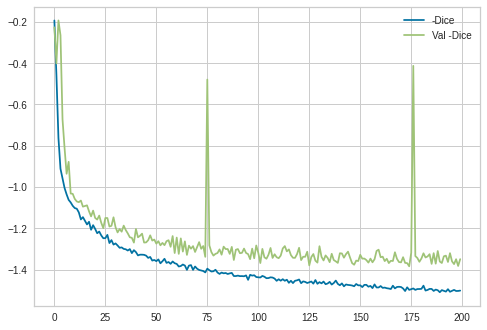

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++
Dice: 0.9849949334257393 +- 0.2128118046351163


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 20s 418ms/step - loss: -0.1766 - iou: 0.0612 - dice_coef: 0.1153 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4815 - val_loss: -0.2111 - val_iou: 0.0738 - val_dice_coef: 0.1374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.4741


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 414ms/step - loss: -0.2371 - iou: 0.0832 - dice_coef: 0.1536 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6908 - val_loss: -0.2415 - val_iou: 0.0850 - val_dice_coef: 0.1565 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8793


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 20s 435ms/step - loss: -0.5743 - iou: 0.2213 - dice_coef: 0.3503 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9408 - val_loss: -0.6714 - val_iou: 0.2598 - val_dice_coef: 0.4116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9400


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 18s 409ms/step - loss: -0.9419 - iou: 0.3859 - dice_coef: 0.5544 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9691 - val_loss: -0.6898 - val_iou: 0.2691 - val_dice_coef: 0.4207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9347


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 414ms/step - loss: -0.9904 - iou: 0.4104 - dice_coef: 0.5792 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.8787 - val_iou: 0.3562 - val_dice_coef: 0.5225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9612


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 19s 432ms/step - loss: -1.0344 - iou: 0.4334 - dice_coef: 0.6018 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9725 - val_loss: -0.9529 - val_iou: 0.3928 - val_dice_coef: 0.5601 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9689


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 20s 434ms/step - loss: -1.0667 - iou: 0.4486 - dice_coef: 0.6173 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9747 - val_loss: -0.9783 - val_iou: 0.4080 - val_dice_coef: 0.5704 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9685


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 416ms/step - loss: -1.0604 - iou: 0.4465 - dice_coef: 0.6148 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9732 - val_loss: -0.9863 - val_iou: 0.4102 - val_dice_coef: 0.5761 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9657


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 19s 411ms/step - loss: -1.0781 - iou: 0.4560 - dice_coef: 0.6242 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -1.0487 - val_iou: 0.4400 - val_dice_coef: 0.6086 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9698


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 20s 439ms/step - loss: -1.0994 - iou: 0.4670 - dice_coef: 0.6336 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9752 - val_loss: -1.0459 - val_iou: 0.4405 - val_dice_coef: 0.6055 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 19s 421ms/step - loss: -1.1159 - iou: 0.4746 - dice_coef: 0.6403 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9759 - val_loss: -1.0449 - val_iou: 0.4404 - val_dice_coef: 0.6045 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9709


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 18s 408ms/step - loss: -1.1216 - iou: 0.4776 - dice_coef: 0.6434 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9759 - val_loss: -1.1099 - val_iou: 0.4721 - val_dice_coef: 0.6378 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 20s 439ms/step - loss: -1.1377 - iou: 0.4863 - dice_coef: 0.6520 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -1.0865 - val_iou: 0.4615 - val_dice_coef: 0.6249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9724


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 19s 410ms/step - loss: -1.1357 - iou: 0.4844 - dice_coef: 0.6495 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -1.1285 - val_iou: 0.4819 - val_dice_coef: 0.6467 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 18s 406ms/step - loss: -1.1721 - iou: 0.5057 - dice_coef: 0.6682 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9780 - val_loss: -1.1115 - val_iou: 0.4736 - val_dice_coef: 0.6379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 20s 439ms/step - loss: -1.1674 - iou: 0.5014 - dice_coef: 0.6652 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -1.1448 - val_iou: 0.4896 - val_dice_coef: 0.6552 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 18s 410ms/step - loss: -1.1730 - iou: 0.5057 - dice_coef: 0.6684 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -1.1564 - val_iou: 0.4959 - val_dice_coef: 0.6605 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 19s 413ms/step - loss: -1.1892 - iou: 0.5123 - dice_coef: 0.6749 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9786 - val_loss: -1.1078 - val_iou: 0.4728 - val_dice_coef: 0.6350 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 20s 438ms/step - loss: -1.2051 - iou: 0.5218 - dice_coef: 0.6832 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -1.1556 - val_iou: 0.4962 - val_dice_coef: 0.6594 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 19s 411ms/step - loss: -1.2007 - iou: 0.5202 - dice_coef: 0.6815 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -1.1559 - val_iou: 0.4961 - val_dice_coef: 0.6598 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 19s 414ms/step - loss: -1.2032 - iou: 0.5211 - dice_coef: 0.6815 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9788 - val_loss: -1.1050 - val_iou: 0.4728 - val_dice_coef: 0.6322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 20s 435ms/step - loss: -1.2144 - iou: 0.5264 - dice_coef: 0.6872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9793 - val_loss: -1.1348 - val_iou: 0.4881 - val_dice_coef: 0.6467 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 20s 438ms/step - loss: -1.2219 - iou: 0.5312 - dice_coef: 0.6911 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -1.1958 - val_iou: 0.5170 - val_dice_coef: 0.6788 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 19s 421ms/step - loss: -1.2319 - iou: 0.5363 - dice_coef: 0.6948 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -1.1518 - val_iou: 0.4963 - val_dice_coef: 0.6555 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 18s 408ms/step - loss: -1.2487 - iou: 0.5453 - dice_coef: 0.7030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -1.1527 - val_iou: 0.4973 - val_dice_coef: 0.6554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 20s 438ms/step - loss: -1.2407 - iou: 0.5417 - dice_coef: 0.6996 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -1.1734 - val_iou: 0.5077 - val_dice_coef: 0.6657 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 19s 416ms/step - loss: -1.2597 - iou: 0.5513 - dice_coef: 0.7074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -1.2222 - val_iou: 0.5306 - val_dice_coef: 0.6915 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 18s 409ms/step - loss: -1.2478 - iou: 0.5457 - dice_coef: 0.7032 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -1.1732 - val_iou: 0.5097 - val_dice_coef: 0.6634 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 20s 439ms/step - loss: -1.2633 - iou: 0.5540 - dice_coef: 0.7096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -1.1850 - val_iou: 0.5130 - val_dice_coef: 0.6720 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 19s 411ms/step - loss: -1.2721 - iou: 0.5591 - dice_coef: 0.7138 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -1.2318 - val_iou: 0.5380 - val_dice_coef: 0.6938 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 18s 408ms/step - loss: -1.2844 - iou: 0.5652 - dice_coef: 0.7197 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -1.2188 - val_iou: 0.5300 - val_dice_coef: 0.6888 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 20s 439ms/step - loss: -1.2748 - iou: 0.5599 - dice_coef: 0.7147 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -1.1843 - val_iou: 0.5131 - val_dice_coef: 0.6713 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 18s 410ms/step - loss: -1.2906 - iou: 0.5684 - dice_coef: 0.7212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -1.2341 - val_iou: 0.5381 - val_dice_coef: 0.6961 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 19s 416ms/step - loss: -1.2834 - iou: 0.5651 - dice_coef: 0.7179 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -1.2378 - val_iou: 0.5402 - val_dice_coef: 0.6976 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 20s 437ms/step - loss: -1.2957 - iou: 0.5717 - dice_coef: 0.7240 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -1.1812 - val_iou: 0.5157 - val_dice_coef: 0.6655 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 433ms/step - loss: -1.2970 - iou: 0.5728 - dice_coef: 0.7253 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -1.1855 - val_iou: 0.5160 - val_dice_coef: 0.6695 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 19s 421ms/step - loss: -1.3068 - iou: 0.5777 - dice_coef: 0.7291 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -1.1940 - val_iou: 0.5232 - val_dice_coef: 0.6708 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3336 - iou: 0.5885 - dice_coef: 0.7397 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2313 - val_iou: 0.5384 - val_dice_coef: 0.6929 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 20s 437ms/step - loss: -1.3175 - iou: 0.5836 - dice_coef: 0.7332 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -1.2328 - val_iou: 0.5416 - val_dice_coef: 0.6913 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 416ms/step - loss: -1.3235 - iou: 0.5862 - dice_coef: 0.7365 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -1.2515 - val_iou: 0.5479 - val_dice_coef: 0.7037 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3270 - iou: 0.5889 - dice_coef: 0.7379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -1.2462 - val_iou: 0.5460 - val_dice_coef: 0.7002 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 20s 441ms/step - loss: -1.3304 - iou: 0.5905 - dice_coef: 0.7400 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -1.2767 - val_iou: 0.5613 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3351 - iou: 0.5940 - dice_coef: 0.7421 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -1.2105 - val_iou: 0.5318 - val_dice_coef: 0.6788 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 18s 410ms/step - loss: -1.3323 - iou: 0.5921 - dice_coef: 0.7401 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2400 - val_iou: 0.5472 - val_dice_coef: 0.6928 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 20s 442ms/step - loss: -1.3399 - iou: 0.5981 - dice_coef: 0.7435 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -1.2430 - val_iou: 0.5451 - val_dice_coef: 0.6979 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3333 - iou: 0.5933 - dice_coef: 0.7417 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2528 - val_iou: 0.5519 - val_dice_coef: 0.7009 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 18s 409ms/step - loss: -1.3458 - iou: 0.6000 - dice_coef: 0.7466 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2816 - val_iou: 0.5651 - val_dice_coef: 0.7164 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3472 - iou: 0.6015 - dice_coef: 0.7473 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2897 - val_iou: 0.5686 - val_dice_coef: 0.7211 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3628 - iou: 0.6095 - dice_coef: 0.7534 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.3105 - val_iou: 0.5793 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 19s 413ms/step - loss: -1.3658 - iou: 0.6099 - dice_coef: 0.7548 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.2359 - val_iou: 0.5445 - val_dice_coef: 0.6913 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 20s 442ms/step - loss: -1.3500 - iou: 0.6024 - dice_coef: 0.7475 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2652 - val_iou: 0.5560 - val_dice_coef: 0.7092 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 20s 436ms/step - loss: -1.3494 - iou: 0.6016 - dice_coef: 0.7471 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2808 - val_iou: 0.5654 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 416ms/step - loss: -1.3538 - iou: 0.6057 - dice_coef: 0.7500 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2719 - val_iou: 0.5583 - val_dice_coef: 0.7136 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 18s 410ms/step - loss: -1.3708 - iou: 0.6140 - dice_coef: 0.7563 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.3007 - val_iou: 0.5740 - val_dice_coef: 0.7267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3408 - iou: 0.5979 - dice_coef: 0.7442 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2210 - val_iou: 0.5362 - val_dice_coef: 0.6848 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 419ms/step - loss: -1.3721 - iou: 0.6155 - dice_coef: 0.7579 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2862 - val_iou: 0.5677 - val_dice_coef: 0.7186 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 18s 409ms/step - loss: -1.3781 - iou: 0.6177 - dice_coef: 0.7607 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2608 - val_iou: 0.5564 - val_dice_coef: 0.7044 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3829 - iou: 0.6184 - dice_coef: 0.7623 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2842 - val_iou: 0.5679 - val_dice_coef: 0.7163 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3785 - iou: 0.6183 - dice_coef: 0.7603 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.2700 - val_iou: 0.5612 - val_dice_coef: 0.7088 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 18s 410ms/step - loss: -1.3805 - iou: 0.6192 - dice_coef: 0.7607 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.3171 - val_iou: 0.5833 - val_dice_coef: 0.7338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 441ms/step - loss: -1.3834 - iou: 0.6205 - dice_coef: 0.7619 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.3217 - val_iou: 0.5859 - val_dice_coef: 0.7357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 412ms/step - loss: -1.3878 - iou: 0.6233 - dice_coef: 0.7650 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -1.3339 - val_iou: 0.5932 - val_dice_coef: 0.7407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 19s 413ms/step - loss: -1.3950 - iou: 0.6279 - dice_coef: 0.7677 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.2926 - val_iou: 0.5751 - val_dice_coef: 0.7175 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 441ms/step - loss: -1.3942 - iou: 0.6271 - dice_coef: 0.7668 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2921 - val_iou: 0.5723 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4092 - iou: 0.6346 - dice_coef: 0.7734 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2678 - val_iou: 0.5642 - val_dice_coef: 0.7036 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3898 - iou: 0.6242 - dice_coef: 0.7654 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2930 - val_iou: 0.5724 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4052 - iou: 0.6339 - dice_coef: 0.7723 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2867 - val_iou: 0.5725 - val_dice_coef: 0.7142 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 20s 437ms/step - loss: -1.3945 - iou: 0.6272 - dice_coef: 0.7667 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2671 - val_iou: 0.5600 - val_dice_coef: 0.7071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4083 - iou: 0.6354 - dice_coef: 0.7739 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3019 - val_iou: 0.5774 - val_dice_coef: 0.7246 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 18s 410ms/step - loss: -1.3900 - iou: 0.6250 - dice_coef: 0.7650 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2879 - val_iou: 0.5687 - val_dice_coef: 0.7191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3909 - iou: 0.6266 - dice_coef: 0.7665 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2797 - val_iou: 0.5660 - val_dice_coef: 0.7137 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4077 - iou: 0.6349 - dice_coef: 0.7745 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.2930 - val_iou: 0.5751 - val_dice_coef: 0.7180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4081 - iou: 0.6358 - dice_coef: 0.7737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.3131 - val_iou: 0.5839 - val_dice_coef: 0.7293 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4108 - iou: 0.6381 - dice_coef: 0.7746 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2834 - val_iou: 0.5689 - val_dice_coef: 0.7145 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4080 - iou: 0.6343 - dice_coef: 0.7725 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2879 - val_iou: 0.5719 - val_dice_coef: 0.7159 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4068 - iou: 0.6330 - dice_coef: 0.7727 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2702 - val_iou: 0.5633 - val_dice_coef: 0.7069 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4080 - iou: 0.6362 - dice_coef: 0.7728 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3068 - val_iou: 0.5804 - val_dice_coef: 0.7264 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4120 - iou: 0.6376 - dice_coef: 0.7759 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3134 - val_iou: 0.5823 - val_dice_coef: 0.7311 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4227 - iou: 0.6437 - dice_coef: 0.7793 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3416 - val_iou: 0.5972 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4140 - iou: 0.6393 - dice_coef: 0.7751 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.2963 - val_iou: 0.5746 - val_dice_coef: 0.7218 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4158 - iou: 0.6400 - dice_coef: 0.7772 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3477 - val_iou: 0.5998 - val_dice_coef: 0.7479 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4218 - iou: 0.6438 - dice_coef: 0.7797 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.3009 - val_iou: 0.5773 - val_dice_coef: 0.7236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 19s 410ms/step - loss: -1.4190 - iou: 0.6410 - dice_coef: 0.7779 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3043 - val_iou: 0.5823 - val_dice_coef: 0.7220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4176 - iou: 0.6403 - dice_coef: 0.7773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2955 - val_iou: 0.5761 - val_dice_coef: 0.7194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4397 - iou: 0.6470 - dice_coef: 0.7830 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3359 - val_iou: 0.5937 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4285 - iou: 0.6462 - dice_coef: 0.7827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3205 - val_iou: 0.5859 - val_dice_coef: 0.7346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4203 - iou: 0.6419 - dice_coef: 0.7785 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.3026 - val_iou: 0.5805 - val_dice_coef: 0.7221 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4228 - iou: 0.6440 - dice_coef: 0.7789 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2982 - val_iou: 0.5776 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 18s 409ms/step - loss: -1.4308 - iou: 0.6477 - dice_coef: 0.7825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.2945 - val_iou: 0.5739 - val_dice_coef: 0.7207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4287 - iou: 0.6469 - dice_coef: 0.7811 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.2839 - val_iou: 0.5711 - val_dice_coef: 0.7128 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4331 - iou: 0.6492 - dice_coef: 0.7837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3244 - val_iou: 0.5892 - val_dice_coef: 0.7352 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4321 - iou: 0.6490 - dice_coef: 0.7834 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3154 - val_iou: 0.5862 - val_dice_coef: 0.7292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4261 - iou: 0.6462 - dice_coef: 0.7793 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3330 - val_iou: 0.5933 - val_dice_coef: 0.7397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4386 - iou: 0.6525 - dice_coef: 0.7867 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3019 - val_iou: 0.5815 - val_dice_coef: 0.7204 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4253 - iou: 0.6454 - dice_coef: 0.7806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3379 - val_iou: 0.5965 - val_dice_coef: 0.7414 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4387 - iou: 0.6522 - dice_coef: 0.7860 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3075 - val_iou: 0.5822 - val_dice_coef: 0.7252 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4331 - iou: 0.6497 - dice_coef: 0.7836 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.2967 - val_iou: 0.5773 - val_dice_coef: 0.7194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4369 - iou: 0.6515 - dice_coef: 0.7856 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.2938 - val_iou: 0.5759 - val_dice_coef: 0.7179 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 18s 409ms/step - loss: -1.4278 - iou: 0.6473 - dice_coef: 0.7814 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3160 - val_iou: 0.5899 - val_dice_coef: 0.7262 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4496 - iou: 0.6587 - dice_coef: 0.7904 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3491 - val_iou: 0.6017 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4412 - iou: 0.6536 - dice_coef: 0.7862 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3196 - val_iou: 0.5888 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4381 - iou: 0.6527 - dice_coef: 0.7861 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3087 - val_iou: 0.5852 - val_dice_coef: 0.7235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4503 - iou: 0.6603 - dice_coef: 0.7917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3023 - val_iou: 0.5805 - val_dice_coef: 0.7218 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4280 - iou: 0.6464 - dice_coef: 0.7811 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3622 - val_iou: 0.6087 - val_dice_coef: 0.7534 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4524 - iou: 0.6604 - dice_coef: 0.7931 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3480 - val_iou: 0.6011 - val_dice_coef: 0.7469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4457 - iou: 0.6578 - dice_coef: 0.7893 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3480 - val_iou: 0.6014 - val_dice_coef: 0.7466 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4504 - iou: 0.6587 - dice_coef: 0.7923 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3605 - val_iou: 0.6085 - val_dice_coef: 0.7521 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4487 - iou: 0.6581 - dice_coef: 0.7911 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3126 - val_iou: 0.5849 - val_dice_coef: 0.7276 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4433 - iou: 0.6553 - dice_coef: 0.7885 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3372 - val_iou: 0.5990 - val_dice_coef: 0.7382 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4540 - iou: 0.6633 - dice_coef: 0.7921 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3209 - val_iou: 0.5889 - val_dice_coef: 0.7320 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4537 - iou: 0.6615 - dice_coef: 0.7914 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.2792 - val_iou: 0.5674 - val_dice_coef: 0.7118 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4512 - iou: 0.6592 - dice_coef: 0.7909 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3351 - val_iou: 0.5959 - val_dice_coef: 0.7392 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4512 - iou: 0.6606 - dice_coef: 0.7914 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3552 - val_iou: 0.6047 - val_dice_coef: 0.7505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4590 - iou: 0.6647 - dice_coef: 0.7951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3210 - val_iou: 0.5886 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 18s 409ms/step - loss: -1.4461 - iou: 0.6566 - dice_coef: 0.7889 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3551 - val_iou: 0.6045 - val_dice_coef: 0.7506 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4488 - iou: 0.6598 - dice_coef: 0.7905 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3353 - val_iou: 0.5988 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4382 - iou: 0.6530 - dice_coef: 0.7861 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3209 - val_iou: 0.5904 - val_dice_coef: 0.7305 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4499 - iou: 0.6597 - dice_coef: 0.7908 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3241 - val_iou: 0.5925 - val_dice_coef: 0.7316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4646 - iou: 0.6668 - dice_coef: 0.7969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3591 - val_iou: 0.6067 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4584 - iou: 0.6649 - dice_coef: 0.7946 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3005 - val_iou: 0.5812 - val_dice_coef: 0.7192 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4628 - iou: 0.6668 - dice_coef: 0.7956 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3478 - val_iou: 0.6019 - val_dice_coef: 0.7459 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4542 - iou: 0.6629 - dice_coef: 0.7919 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3315 - val_iou: 0.5952 - val_dice_coef: 0.7363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4578 - iou: 0.6643 - dice_coef: 0.7943 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3147 - val_iou: 0.5883 - val_dice_coef: 0.7263 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4538 - iou: 0.6618 - dice_coef: 0.7919 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3740 - val_iou: 0.6154 - val_dice_coef: 0.7587 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4719 - iou: 0.6714 - dice_coef: 0.8002 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3446 - val_iou: 0.6004 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 19s 433ms/step - loss: -1.4581 - iou: 0.6630 - dice_coef: 0.7942 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.2854 - val_iou: 0.5723 - val_dice_coef: 0.7131 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4574 - iou: 0.6642 - dice_coef: 0.7932 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3114 - val_iou: 0.5871 - val_dice_coef: 0.7243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4622 - iou: 0.6655 - dice_coef: 0.7946 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3658 - val_iou: 0.6105 - val_dice_coef: 0.7553 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4562 - iou: 0.6632 - dice_coef: 0.7936 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3308 - val_iou: 0.5975 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4642 - iou: 0.6671 - dice_coef: 0.7966 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3593 - val_iou: 0.6077 - val_dice_coef: 0.7516 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4657 - iou: 0.6686 - dice_coef: 0.7971 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3151 - val_iou: 0.5884 - val_dice_coef: 0.7267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4786 - iou: 0.6681 - dice_coef: 0.7964 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3420 - val_iou: 0.6006 - val_dice_coef: 0.7415 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4666 - iou: 0.6690 - dice_coef: 0.7975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3292 - val_iou: 0.5923 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4650 - iou: 0.6687 - dice_coef: 0.7968 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3010 - val_iou: 0.5817 - val_dice_coef: 0.7192 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4676 - iou: 0.6703 - dice_coef: 0.7986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3124 - val_iou: 0.5890 - val_dice_coef: 0.7234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4673 - iou: 0.6688 - dice_coef: 0.7978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3175 - val_iou: 0.5908 - val_dice_coef: 0.7268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4653 - iou: 0.6691 - dice_coef: 0.7970 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3310 - val_iou: 0.5970 - val_dice_coef: 0.7340 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4708 - iou: 0.6715 - dice_coef: 0.8000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3445 - val_iou: 0.6024 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4742 - iou: 0.6736 - dice_coef: 0.8011 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3246 - val_iou: 0.5940 - val_dice_coef: 0.7307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4802 - iou: 0.6762 - dice_coef: 0.8036 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3434 - val_iou: 0.6002 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4686 - iou: 0.6716 - dice_coef: 0.7974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3728 - val_iou: 0.6158 - val_dice_coef: 0.7570 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4753 - iou: 0.6746 - dice_coef: 0.8012 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3903 - val_iou: 0.6238 - val_dice_coef: 0.7664 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4675 - iou: 0.6701 - dice_coef: 0.7985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3466 - val_iou: 0.6016 - val_dice_coef: 0.7450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4764 - iou: 0.6734 - dice_coef: 0.8018 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3009 - val_iou: 0.5818 - val_dice_coef: 0.7191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4705 - iou: 0.6716 - dice_coef: 0.8008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3388 - val_iou: 0.5984 - val_dice_coef: 0.7404 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4808 - iou: 0.6765 - dice_coef: 0.8035 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3468 - val_iou: 0.6049 - val_dice_coef: 0.7419 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 18s 408ms/step - loss: -1.4663 - iou: 0.6686 - dice_coef: 0.7974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3368 - val_iou: 0.5958 - val_dice_coef: 0.7410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4818 - iou: 0.6774 - dice_coef: 0.8041 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3107 - val_iou: 0.5849 - val_dice_coef: 0.7258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4837 - iou: 0.6792 - dice_coef: 0.8053 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3571 - val_iou: 0.6101 - val_dice_coef: 0.7470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4790 - iou: 0.6764 - dice_coef: 0.8035 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3525 - val_iou: 0.6069 - val_dice_coef: 0.7456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4819 - iou: 0.6775 - dice_coef: 0.8038 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3116 - val_iou: 0.5884 - val_dice_coef: 0.7233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4848 - iou: 0.6807 - dice_coef: 0.8056 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3270 - val_iou: 0.5960 - val_dice_coef: 0.7310 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4728 - iou: 0.6718 - dice_coef: 0.8000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3523 - val_iou: 0.6054 - val_dice_coef: 0.7469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 19s 414ms/step - loss: -1.4893 - iou: 0.6822 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3387 - val_iou: 0.5992 - val_dice_coef: 0.7395 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4805 - iou: 0.6768 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3372 - val_iou: 0.6013 - val_dice_coef: 0.7359 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4730 - iou: 0.6738 - dice_coef: 0.8003 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3495 - val_iou: 0.6051 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4821 - iou: 0.6777 - dice_coef: 0.8045 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3297 - val_iou: 0.5925 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4796 - iou: 0.6771 - dice_coef: 0.8035 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3623 - val_iou: 0.6093 - val_dice_coef: 0.7531 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4864 - iou: 0.6807 - dice_coef: 0.8069 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3590 - val_iou: 0.6095 - val_dice_coef: 0.7495 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4755 - iou: 0.6751 - dice_coef: 0.8011 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3475 - val_iou: 0.6050 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4786 - iou: 0.6764 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3543 - val_iou: 0.6069 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4932 - iou: 0.6845 - dice_coef: 0.8089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3354 - val_iou: 0.5958 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 18s 410ms/step - loss: -1.4924 - iou: 0.6844 - dice_coef: 0.8085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3301 - val_iou: 0.5943 - val_dice_coef: 0.7359 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4872 - iou: 0.6802 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3516 - val_iou: 0.6045 - val_dice_coef: 0.7471 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4827 - iou: 0.6787 - dice_coef: 0.8042 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3581 - val_iou: 0.6084 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4981 - iou: 0.6868 - dice_coef: 0.8106 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3186 - val_iou: 0.5878 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4897 - iou: 0.6821 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3584 - val_iou: 0.6104 - val_dice_coef: 0.7480 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4827 - iou: 0.6781 - dice_coef: 0.8036 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3366 - val_iou: 0.5978 - val_dice_coef: 0.7388 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4919 - iou: 0.6838 - dice_coef: 0.8075 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3786 - val_iou: 0.6185 - val_dice_coef: 0.7601 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4814 - iou: 0.6778 - dice_coef: 0.8044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3537 - val_iou: 0.6062 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4904 - iou: 0.6836 - dice_coef: 0.8077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3613 - val_iou: 0.6101 - val_dice_coef: 0.7512 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4928 - iou: 0.6842 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3610 - val_iou: 0.6108 - val_dice_coef: 0.7502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4934 - iou: 0.6833 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3520 - val_iou: 0.6039 - val_dice_coef: 0.7481 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4901 - iou: 0.6823 - dice_coef: 0.8077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3522 - val_iou: 0.6082 - val_dice_coef: 0.7440 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4947 - iou: 0.6849 - dice_coef: 0.8088 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3575 - val_iou: 0.6083 - val_dice_coef: 0.7491 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4825 - iou: 0.6782 - dice_coef: 0.8035 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3344 - val_iou: 0.5989 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4887 - iou: 0.6808 - dice_coef: 0.8073 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3854 - val_iou: 0.6213 - val_dice_coef: 0.7640 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4931 - iou: 0.6843 - dice_coef: 0.8087 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3500 - val_iou: 0.6042 - val_dice_coef: 0.7458 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 19s 416ms/step - loss: -1.5099 - iou: 0.6868 - dice_coef: 0.8107 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3321 - val_iou: 0.5967 - val_dice_coef: 0.7353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4982 - iou: 0.6877 - dice_coef: 0.8111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3455 - val_iou: 0.6015 - val_dice_coef: 0.7440 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5004 - iou: 0.6870 - dice_coef: 0.8112 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3775 - val_iou: 0.6168 - val_dice_coef: 0.7606 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4917 - iou: 0.6839 - dice_coef: 0.8074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3342 - val_iou: 0.5994 - val_dice_coef: 0.7348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4953 - iou: 0.6862 - dice_coef: 0.8102 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3388 - val_iou: 0.5995 - val_dice_coef: 0.7393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4969 - iou: 0.6873 - dice_coef: 0.8104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3165 - val_iou: 0.5893 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4949 - iou: 0.6859 - dice_coef: 0.8093 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3388 - val_iou: 0.6011 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4960 - iou: 0.6859 - dice_coef: 0.8096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3391 - val_iou: 0.5991 - val_dice_coef: 0.7400 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4991 - iou: 0.6864 - dice_coef: 0.8109 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3396 - val_iou: 0.6002 - val_dice_coef: 0.7394 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4880 - iou: 0.6816 - dice_coef: 0.8057 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3335 - val_iou: 0.5964 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 19s 411ms/step - loss: -1.5001 - iou: 0.6883 - dice_coef: 0.8118 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3563 - val_iou: 0.6089 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4988 - iou: 0.6890 - dice_coef: 0.8111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3789 - val_iou: 0.6192 - val_dice_coef: 0.7597 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4959 - iou: 0.6864 - dice_coef: 0.8100 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3559 - val_iou: 0.6060 - val_dice_coef: 0.7499 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 18s 409ms/step - loss: -1.5010 - iou: 0.6891 - dice_coef: 0.8129 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3603 - val_iou: 0.6083 - val_dice_coef: 0.7520 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4948 - iou: 0.6861 - dice_coef: 0.8085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3676 - val_iou: 0.6122 - val_dice_coef: 0.7554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4979 - iou: 0.6878 - dice_coef: 0.8105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3299 - val_iou: 0.5957 - val_dice_coef: 0.7342 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4995 - iou: 0.6874 - dice_coef: 0.8111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3201 - val_iou: 0.5912 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 19s 414ms/step - loss: -1.5021 - iou: 0.6910 - dice_coef: 0.8122 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3524 - val_iou: 0.6072 - val_dice_coef: 0.7452 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 19s 431ms/step - loss: -1.5024 - iou: 0.6893 - dice_coef: 0.8124 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3301 - val_iou: 0.5962 - val_dice_coef: 0.7340 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5071 - iou: 0.6932 - dice_coef: 0.8141 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3602 - val_iou: 0.6088 - val_dice_coef: 0.7514 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4992 - iou: 0.6892 - dice_coef: 0.8119 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3541 - val_iou: 0.6059 - val_dice_coef: 0.7482 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 20s 435ms/step - loss: -1.5076 - iou: 0.6925 - dice_coef: 0.8142 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3266 - val_iou: 0.5923 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-4/Model_Checkpoint/assets


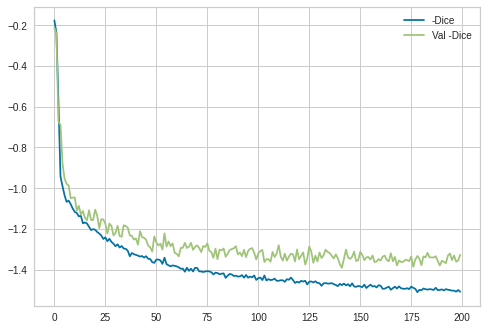

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++
Dice: 0.9877550350722446 +- 0.18409934780156922


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 21s 424ms/step - loss: -0.1731 - iou: 0.0600 - dice_coef: 0.1131 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4862 - val_loss: -0.2085 - val_iou: 0.0728 - val_dice_coef: 0.1357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.5183


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 429ms/step - loss: -0.3501 - iou: 0.1275 - dice_coef: 0.2214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8214 - val_loss: -0.4161 - val_iou: 0.1522 - val_dice_coef: 0.2639 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8946


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 427ms/step - loss: -0.7239 - iou: 0.2835 - dice_coef: 0.4400 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9559 - val_loss: -0.5306 - val_iou: 0.1990 - val_dice_coef: 0.3315 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9202


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 19s 413ms/step - loss: -0.8424 - iou: 0.3394 - dice_coef: 0.5048 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9641 - val_loss: -0.7150 - val_iou: 0.2798 - val_dice_coef: 0.4352 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9493


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 20s 436ms/step - loss: -0.9395 - iou: 0.3861 - dice_coef: 0.5542 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9699 - val_loss: -0.8008 - val_iou: 0.3193 - val_dice_coef: 0.4814 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9651


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 19s 431ms/step - loss: -0.9728 - iou: 0.4018 - dice_coef: 0.5705 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9711 - val_loss: -0.8535 - val_iou: 0.3441 - val_dice_coef: 0.5094 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9602


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 20s 435ms/step - loss: -0.9926 - iou: 0.4116 - dice_coef: 0.5804 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9714 - val_loss: -0.9470 - val_iou: 0.3888 - val_dice_coef: 0.5582 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9713


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 415ms/step - loss: -1.0570 - iou: 0.4432 - dice_coef: 0.6123 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9743 - val_loss: -0.9757 - val_iou: 0.4042 - val_dice_coef: 0.5715 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9693


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 19s 424ms/step - loss: -1.0556 - iou: 0.4441 - dice_coef: 0.6133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9738 - val_loss: -0.9681 - val_iou: 0.4013 - val_dice_coef: 0.5668 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9672


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 20s 436ms/step - loss: -1.0561 - iou: 0.4436 - dice_coef: 0.6113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9735 - val_loss: -1.0047 - val_iou: 0.4186 - val_dice_coef: 0.5861 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9680


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 19s 417ms/step - loss: -1.0926 - iou: 0.4641 - dice_coef: 0.6311 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9752 - val_loss: -1.0572 - val_iou: 0.4444 - val_dice_coef: 0.6128 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9736


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 19s 428ms/step - loss: -1.1022 - iou: 0.4673 - dice_coef: 0.6339 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9754 - val_loss: -1.0458 - val_iou: 0.4387 - val_dice_coef: 0.6071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 427ms/step - loss: -1.1054 - iou: 0.4687 - dice_coef: 0.6354 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9753 - val_loss: -1.0636 - val_iou: 0.4491 - val_dice_coef: 0.6144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9754


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 19s 415ms/step - loss: -1.1214 - iou: 0.4785 - dice_coef: 0.6443 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9761 - val_loss: -1.0985 - val_iou: 0.4659 - val_dice_coef: 0.6327 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 19s 430ms/step - loss: -1.1292 - iou: 0.4819 - dice_coef: 0.6480 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9764 - val_loss: -1.0719 - val_iou: 0.4542 - val_dice_coef: 0.6178 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9731


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 19s 426ms/step - loss: -1.1439 - iou: 0.4890 - dice_coef: 0.6541 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -1.0710 - val_iou: 0.4546 - val_dice_coef: 0.6165 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 19s 412ms/step - loss: -1.1525 - iou: 0.4937 - dice_coef: 0.6590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9772 - val_loss: -1.0671 - val_iou: 0.4512 - val_dice_coef: 0.6159 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 20s 433ms/step - loss: -1.1590 - iou: 0.4980 - dice_coef: 0.6616 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9776 - val_loss: -1.1139 - val_iou: 0.4746 - val_dice_coef: 0.6393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 19s 430ms/step - loss: -1.1755 - iou: 0.5070 - dice_coef: 0.6709 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9780 - val_loss: -1.1208 - val_iou: 0.4781 - val_dice_coef: 0.6427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 20s 434ms/step - loss: -1.1793 - iou: 0.5064 - dice_coef: 0.6691 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -1.1435 - val_iou: 0.4913 - val_dice_coef: 0.6522 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 19s 414ms/step - loss: -1.1871 - iou: 0.5116 - dice_coef: 0.6739 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -1.0974 - val_iou: 0.4674 - val_dice_coef: 0.6300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 19s 423ms/step - loss: -1.1845 - iou: 0.5124 - dice_coef: 0.6737 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -1.0985 - val_iou: 0.4690 - val_dice_coef: 0.6296 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 20s 436ms/step - loss: -1.1892 - iou: 0.5143 - dice_coef: 0.6768 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -1.0999 - val_iou: 0.4705 - val_dice_coef: 0.6294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 19s 415ms/step - loss: -1.1994 - iou: 0.5199 - dice_coef: 0.6806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9790 - val_loss: -1.1284 - val_iou: 0.4852 - val_dice_coef: 0.6432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 19s 428ms/step - loss: -1.2062 - iou: 0.5242 - dice_coef: 0.6843 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9790 - val_loss: -1.1694 - val_iou: 0.5027 - val_dice_coef: 0.6668 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 19s 429ms/step - loss: -1.2269 - iou: 0.5335 - dice_coef: 0.6934 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -1.1257 - val_iou: 0.4841 - val_dice_coef: 0.6416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 19s 417ms/step - loss: -1.2266 - iou: 0.5287 - dice_coef: 0.6893 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -1.1625 - val_iou: 0.5000 - val_dice_coef: 0.6625 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 19s 430ms/step - loss: -1.2278 - iou: 0.5338 - dice_coef: 0.6931 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -1.1428 - val_iou: 0.4908 - val_dice_coef: 0.6520 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 19s 426ms/step - loss: -1.2166 - iou: 0.5287 - dice_coef: 0.6884 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9792 - val_loss: -1.1928 - val_iou: 0.5156 - val_dice_coef: 0.6772 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 19s 417ms/step - loss: -1.2468 - iou: 0.5440 - dice_coef: 0.7018 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -1.1691 - val_iou: 0.5054 - val_dice_coef: 0.6636 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 20s 436ms/step - loss: -1.2381 - iou: 0.5404 - dice_coef: 0.6987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -1.1553 - val_iou: 0.4980 - val_dice_coef: 0.6573 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 20s 433ms/step - loss: -1.2494 - iou: 0.5465 - dice_coef: 0.7040 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9803 - val_loss: -1.1660 - val_iou: 0.5016 - val_dice_coef: 0.6644 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 20s 433ms/step - loss: -1.2449 - iou: 0.5447 - dice_coef: 0.7019 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -1.1831 - val_iou: 0.5130 - val_dice_coef: 0.6701 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 19s 413ms/step - loss: -1.2604 - iou: 0.5517 - dice_coef: 0.7073 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -1.1708 - val_iou: 0.5074 - val_dice_coef: 0.6634 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 19s 423ms/step - loss: -1.2701 - iou: 0.5585 - dice_coef: 0.7134 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -1.1510 - val_iou: 0.4986 - val_dice_coef: 0.6524 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 433ms/step - loss: -1.2647 - iou: 0.5548 - dice_coef: 0.7104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -1.2020 - val_iou: 0.5209 - val_dice_coef: 0.6811 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 19s 413ms/step - loss: -1.2756 - iou: 0.5617 - dice_coef: 0.7158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -1.1846 - val_iou: 0.5115 - val_dice_coef: 0.6731 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 429ms/step - loss: -1.2922 - iou: 0.5705 - dice_coef: 0.7227 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -1.1966 - val_iou: 0.5201 - val_dice_coef: 0.6765 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 19s 428ms/step - loss: -1.2755 - iou: 0.5615 - dice_coef: 0.7148 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -1.1931 - val_iou: 0.5190 - val_dice_coef: 0.6741 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 417ms/step - loss: -1.2942 - iou: 0.5692 - dice_coef: 0.7225 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -1.1988 - val_iou: 0.5235 - val_dice_coef: 0.6753 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 430ms/step - loss: -1.2853 - iou: 0.5659 - dice_coef: 0.7202 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -1.1905 - val_iou: 0.5200 - val_dice_coef: 0.6705 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 19s 425ms/step - loss: -1.3104 - iou: 0.5802 - dice_coef: 0.7303 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -1.2032 - val_iou: 0.5263 - val_dice_coef: 0.6769 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 19s 412ms/step - loss: -1.3021 - iou: 0.5747 - dice_coef: 0.7264 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -1.2204 - val_iou: 0.5337 - val_dice_coef: 0.6867 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 20s 437ms/step - loss: -1.3134 - iou: 0.5814 - dice_coef: 0.7324 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.2195 - val_iou: 0.5331 - val_dice_coef: 0.6864 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3167 - iou: 0.5827 - dice_coef: 0.7323 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.2051 - val_iou: 0.5271 - val_dice_coef: 0.6780 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3087 - iou: 0.5794 - dice_coef: 0.7300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -1.2530 - val_iou: 0.5477 - val_dice_coef: 0.7053 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 20s 441ms/step - loss: -1.3238 - iou: 0.5877 - dice_coef: 0.7371 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -1.2470 - val_iou: 0.5501 - val_dice_coef: 0.6969 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 19s 431ms/step - loss: -1.3328 - iou: 0.5928 - dice_coef: 0.7419 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -1.2528 - val_iou: 0.5477 - val_dice_coef: 0.7050 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3175 - iou: 0.5825 - dice_coef: 0.7321 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -1.2599 - val_iou: 0.5519 - val_dice_coef: 0.7081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 19s 413ms/step - loss: -1.3391 - iou: 0.5961 - dice_coef: 0.7431 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -1.2867 - val_iou: 0.5657 - val_dice_coef: 0.7209 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3385 - iou: 0.5957 - dice_coef: 0.7440 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2305 - val_iou: 0.5414 - val_dice_coef: 0.6890 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3342 - iou: 0.5933 - dice_coef: 0.7410 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -1.2289 - val_iou: 0.5392 - val_dice_coef: 0.6898 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3267 - iou: 0.5889 - dice_coef: 0.7377 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -1.2810 - val_iou: 0.5640 - val_dice_coef: 0.7169 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3657 - iou: 0.6110 - dice_coef: 0.7553 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -1.2777 - val_iou: 0.5615 - val_dice_coef: 0.7162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 19s 423ms/step - loss: -1.3378 - iou: 0.5947 - dice_coef: 0.7412 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -1.2615 - val_iou: 0.5544 - val_dice_coef: 0.7071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3578 - iou: 0.6060 - dice_coef: 0.7512 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -1.2827 - val_iou: 0.5653 - val_dice_coef: 0.7175 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 20s 437ms/step - loss: -1.3584 - iou: 0.6076 - dice_coef: 0.7527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -1.2399 - val_iou: 0.5456 - val_dice_coef: 0.6943 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3630 - iou: 0.6094 - dice_coef: 0.7542 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -1.2671 - val_iou: 0.5594 - val_dice_coef: 0.7077 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 411ms/step - loss: -1.3647 - iou: 0.6119 - dice_coef: 0.7546 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2356 - val_iou: 0.5435 - val_dice_coef: 0.6922 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3662 - iou: 0.6115 - dice_coef: 0.7561 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2844 - val_iou: 0.5663 - val_dice_coef: 0.7180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 19s 431ms/step - loss: -1.3633 - iou: 0.6106 - dice_coef: 0.7533 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.2437 - val_iou: 0.5479 - val_dice_coef: 0.6958 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 431ms/step - loss: -1.3757 - iou: 0.6169 - dice_coef: 0.7598 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2930 - val_iou: 0.5716 - val_dice_coef: 0.7214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 19s 417ms/step - loss: -1.3624 - iou: 0.6092 - dice_coef: 0.7538 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -1.2402 - val_iou: 0.5425 - val_dice_coef: 0.6976 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 19s 430ms/step - loss: -1.3859 - iou: 0.6230 - dice_coef: 0.7646 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.3131 - val_iou: 0.5819 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 20s 436ms/step - loss: -1.3802 - iou: 0.6200 - dice_coef: 0.7614 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.2732 - val_iou: 0.5643 - val_dice_coef: 0.7089 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3804 - iou: 0.6196 - dice_coef: 0.7614 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2711 - val_iou: 0.5617 - val_dice_coef: 0.7094 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3950 - iou: 0.6267 - dice_coef: 0.7680 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2723 - val_iou: 0.5621 - val_dice_coef: 0.7102 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3953 - iou: 0.6277 - dice_coef: 0.7675 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2521 - val_iou: 0.5553 - val_dice_coef: 0.6968 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3848 - iou: 0.6215 - dice_coef: 0.7626 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.2698 - val_iou: 0.5628 - val_dice_coef: 0.7070 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 20s 437ms/step - loss: -1.3809 - iou: 0.6199 - dice_coef: 0.7607 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.2998 - val_iou: 0.5749 - val_dice_coef: 0.7250 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 19s 421ms/step - loss: -1.3873 - iou: 0.6246 - dice_coef: 0.7650 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.3442 - val_iou: 0.5973 - val_dice_coef: 0.7469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3881 - iou: 0.6241 - dice_coef: 0.7655 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -1.2813 - val_iou: 0.5681 - val_dice_coef: 0.7132 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 20s 441ms/step - loss: -1.3995 - iou: 0.6301 - dice_coef: 0.7694 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.2811 - val_iou: 0.5679 - val_dice_coef: 0.7132 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4041 - iou: 0.6253 - dice_coef: 0.7640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2809 - val_iou: 0.5665 - val_dice_coef: 0.7144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4146 - iou: 0.6401 - dice_coef: 0.7758 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.2925 - val_iou: 0.5744 - val_dice_coef: 0.7181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4011 - iou: 0.6309 - dice_coef: 0.7707 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.3045 - val_iou: 0.5798 - val_dice_coef: 0.7246 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4073 - iou: 0.6359 - dice_coef: 0.7738 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.2945 - val_iou: 0.5739 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4092 - iou: 0.6360 - dice_coef: 0.7735 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2918 - val_iou: 0.5718 - val_dice_coef: 0.7201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4040 - iou: 0.6330 - dice_coef: 0.7706 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2798 - val_iou: 0.5650 - val_dice_coef: 0.7147 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4149 - iou: 0.6386 - dice_coef: 0.7765 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.2774 - val_iou: 0.5669 - val_dice_coef: 0.7105 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4197 - iou: 0.6418 - dice_coef: 0.7787 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2989 - val_iou: 0.5766 - val_dice_coef: 0.7223 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4066 - iou: 0.6338 - dice_coef: 0.7726 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3168 - val_iou: 0.5836 - val_dice_coef: 0.7332 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4234 - iou: 0.6430 - dice_coef: 0.7786 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2739 - val_iou: 0.5663 - val_dice_coef: 0.7076 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4177 - iou: 0.6407 - dice_coef: 0.7784 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2883 - val_iou: 0.5731 - val_dice_coef: 0.7153 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4301 - iou: 0.6473 - dice_coef: 0.7821 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.2718 - val_iou: 0.5680 - val_dice_coef: 0.7038 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4302 - iou: 0.6492 - dice_coef: 0.7836 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3074 - val_iou: 0.5816 - val_dice_coef: 0.7258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4148 - iou: 0.6392 - dice_coef: 0.7762 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3190 - val_iou: 0.5868 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4254 - iou: 0.6447 - dice_coef: 0.7793 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3096 - val_iou: 0.5834 - val_dice_coef: 0.7263 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4309 - iou: 0.6486 - dice_coef: 0.7827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.2952 - val_iou: 0.5748 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4191 - iou: 0.6393 - dice_coef: 0.7762 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2874 - val_iou: 0.5712 - val_dice_coef: 0.7162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4340 - iou: 0.6502 - dice_coef: 0.7847 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3067 - val_iou: 0.5796 - val_dice_coef: 0.7271 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4388 - iou: 0.6526 - dice_coef: 0.7863 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3078 - val_iou: 0.5815 - val_dice_coef: 0.7264 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4194 - iou: 0.6421 - dice_coef: 0.7783 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.3217 - val_iou: 0.5884 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4399 - iou: 0.6531 - dice_coef: 0.7873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3274 - val_iou: 0.5905 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4380 - iou: 0.6524 - dice_coef: 0.7872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.2984 - val_iou: 0.5782 - val_dice_coef: 0.7203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4274 - iou: 0.6453 - dice_coef: 0.7808 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3134 - val_iou: 0.5834 - val_dice_coef: 0.7300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4364 - iou: 0.6515 - dice_coef: 0.7859 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3233 - val_iou: 0.5888 - val_dice_coef: 0.7345 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 19s 412ms/step - loss: -1.4418 - iou: 0.6549 - dice_coef: 0.7872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3021 - val_iou: 0.5802 - val_dice_coef: 0.7220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4373 - iou: 0.6527 - dice_coef: 0.7861 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3207 - val_iou: 0.5871 - val_dice_coef: 0.7336 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4399 - iou: 0.6548 - dice_coef: 0.7866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3358 - val_iou: 0.5949 - val_dice_coef: 0.7409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 19s 411ms/step - loss: -1.4403 - iou: 0.6529 - dice_coef: 0.7865 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3020 - val_iou: 0.5801 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4370 - iou: 0.6516 - dice_coef: 0.7855 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3429 - val_iou: 0.5997 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4459 - iou: 0.6569 - dice_coef: 0.7891 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3032 - val_iou: 0.5817 - val_dice_coef: 0.7214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4364 - iou: 0.6513 - dice_coef: 0.7847 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3538 - val_iou: 0.6042 - val_dice_coef: 0.7496 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4482 - iou: 0.6575 - dice_coef: 0.7901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3027 - val_iou: 0.5803 - val_dice_coef: 0.7224 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4512 - iou: 0.6587 - dice_coef: 0.7917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3078 - val_iou: 0.5840 - val_dice_coef: 0.7237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4433 - iou: 0.6556 - dice_coef: 0.7886 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3450 - val_iou: 0.6014 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4441 - iou: 0.6546 - dice_coef: 0.7867 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3251 - val_iou: 0.5901 - val_dice_coef: 0.7350 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4498 - iou: 0.6588 - dice_coef: 0.7905 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3370 - val_iou: 0.5957 - val_dice_coef: 0.7414 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4468 - iou: 0.6573 - dice_coef: 0.7893 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3526 - val_iou: 0.6036 - val_dice_coef: 0.7489 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4486 - iou: 0.6584 - dice_coef: 0.7898 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.2898 - val_iou: 0.5760 - val_dice_coef: 0.7138 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4585 - iou: 0.6653 - dice_coef: 0.7956 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3393 - val_iou: 0.5965 - val_dice_coef: 0.7428 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 19s 414ms/step - loss: -1.4481 - iou: 0.6576 - dice_coef: 0.7899 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3136 - val_iou: 0.5869 - val_dice_coef: 0.7267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4463 - iou: 0.6581 - dice_coef: 0.7895 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3690 - val_iou: 0.6125 - val_dice_coef: 0.7565 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4485 - iou: 0.6581 - dice_coef: 0.7895 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.2836 - val_iou: 0.5712 - val_dice_coef: 0.7124 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4580 - iou: 0.6641 - dice_coef: 0.7952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3118 - val_iou: 0.5833 - val_dice_coef: 0.7285 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4599 - iou: 0.6653 - dice_coef: 0.7952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3499 - val_iou: 0.6037 - val_dice_coef: 0.7462 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4537 - iou: 0.6607 - dice_coef: 0.7919 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3271 - val_iou: 0.5932 - val_dice_coef: 0.7339 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4600 - iou: 0.6656 - dice_coef: 0.7954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3131 - val_iou: 0.5866 - val_dice_coef: 0.7266 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4587 - iou: 0.6646 - dice_coef: 0.7941 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3254 - val_iou: 0.5941 - val_dice_coef: 0.7313 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4785 - iou: 0.6691 - dice_coef: 0.7991 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3274 - val_iou: 0.5943 - val_dice_coef: 0.7331 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4556 - iou: 0.6617 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3604 - val_iou: 0.6078 - val_dice_coef: 0.7526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4663 - iou: 0.6693 - dice_coef: 0.7976 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3605 - val_iou: 0.6082 - val_dice_coef: 0.7524 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4593 - iou: 0.6641 - dice_coef: 0.7942 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3813 - val_iou: 0.6180 - val_dice_coef: 0.7633 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4662 - iou: 0.6696 - dice_coef: 0.7979 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3090 - val_iou: 0.5856 - val_dice_coef: 0.7234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4642 - iou: 0.6687 - dice_coef: 0.7959 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3099 - val_iou: 0.5852 - val_dice_coef: 0.7247 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 19s 414ms/step - loss: -1.4584 - iou: 0.6640 - dice_coef: 0.7939 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3566 - val_iou: 0.6063 - val_dice_coef: 0.7503 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4522 - iou: 0.6612 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3332 - val_iou: 0.5948 - val_dice_coef: 0.7384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4576 - iou: 0.6638 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3448 - val_iou: 0.6006 - val_dice_coef: 0.7442 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4780 - iou: 0.6756 - dice_coef: 0.8028 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3301 - val_iou: 0.5929 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4721 - iou: 0.6715 - dice_coef: 0.7993 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.2826 - val_iou: 0.5717 - val_dice_coef: 0.7108 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4729 - iou: 0.6721 - dice_coef: 0.8007 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3534 - val_iou: 0.6038 - val_dice_coef: 0.7496 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4615 - iou: 0.6658 - dice_coef: 0.7959 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3236 - val_iou: 0.5942 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4680 - iou: 0.6704 - dice_coef: 0.7980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3399 - val_iou: 0.5967 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4666 - iou: 0.6683 - dice_coef: 0.7978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3270 - val_iou: 0.5909 - val_dice_coef: 0.7361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4704 - iou: 0.6713 - dice_coef: 0.7985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3056 - val_iou: 0.5815 - val_dice_coef: 0.7240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4730 - iou: 0.6737 - dice_coef: 0.8003 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3301 - val_iou: 0.5948 - val_dice_coef: 0.7353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4715 - iou: 0.6715 - dice_coef: 0.7995 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3793 - val_iou: 0.6189 - val_dice_coef: 0.7604 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4748 - iou: 0.6735 - dice_coef: 0.8021 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3116 - val_iou: 0.5869 - val_dice_coef: 0.7248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4696 - iou: 0.6706 - dice_coef: 0.7985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3059 - val_iou: 0.5858 - val_dice_coef: 0.7201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4784 - iou: 0.6763 - dice_coef: 0.8027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3673 - val_iou: 0.6116 - val_dice_coef: 0.7557 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4690 - iou: 0.6701 - dice_coef: 0.7987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3248 - val_iou: 0.5924 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4650 - iou: 0.6683 - dice_coef: 0.7963 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3336 - val_iou: 0.5948 - val_dice_coef: 0.7388 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4827 - iou: 0.6781 - dice_coef: 0.8049 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3435 - val_iou: 0.6010 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4866 - iou: 0.6799 - dice_coef: 0.8067 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3239 - val_iou: 0.5919 - val_dice_coef: 0.7320 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4839 - iou: 0.6797 - dice_coef: 0.8043 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3320 - val_iou: 0.5965 - val_dice_coef: 0.7355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4755 - iou: 0.6751 - dice_coef: 0.8014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3473 - val_iou: 0.6023 - val_dice_coef: 0.7450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4743 - iou: 0.6742 - dice_coef: 0.8009 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3111 - val_iou: 0.5855 - val_dice_coef: 0.7256 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4896 - iou: 0.6817 - dice_coef: 0.8077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3212 - val_iou: 0.5898 - val_dice_coef: 0.7314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4880 - iou: 0.6808 - dice_coef: 0.8073 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3343 - val_iou: 0.5980 - val_dice_coef: 0.7363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4713 - iou: 0.6715 - dice_coef: 0.7997 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3452 - val_iou: 0.6009 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4821 - iou: 0.6792 - dice_coef: 0.8048 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3233 - val_iou: 0.5898 - val_dice_coef: 0.7334 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4731 - iou: 0.6735 - dice_coef: 0.8003 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3407 - val_iou: 0.6000 - val_dice_coef: 0.7407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4829 - iou: 0.6786 - dice_coef: 0.8047 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3232 - val_iou: 0.5942 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4897 - iou: 0.6819 - dice_coef: 0.8080 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3917 - val_iou: 0.6246 - val_dice_coef: 0.7671 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9853


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4847 - iou: 0.6805 - dice_coef: 0.8056 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3230 - val_iou: 0.5928 - val_dice_coef: 0.7302 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4828 - iou: 0.6784 - dice_coef: 0.8044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3566 - val_iou: 0.6065 - val_dice_coef: 0.7501 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4889 - iou: 0.6816 - dice_coef: 0.8077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.2946 - val_iou: 0.5779 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4851 - iou: 0.6800 - dice_coef: 0.8057 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3550 - val_iou: 0.6052 - val_dice_coef: 0.7498 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4823 - iou: 0.6786 - dice_coef: 0.8039 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3512 - val_iou: 0.6038 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4887 - iou: 0.6828 - dice_coef: 0.8077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3690 - val_iou: 0.6119 - val_dice_coef: 0.7571 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 19s 414ms/step - loss: -1.4913 - iou: 0.6838 - dice_coef: 0.8072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3244 - val_iou: 0.5940 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4791 - iou: 0.6769 - dice_coef: 0.8027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3184 - val_iou: 0.5878 - val_dice_coef: 0.7306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4851 - iou: 0.6808 - dice_coef: 0.8059 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3436 - val_iou: 0.5986 - val_dice_coef: 0.7450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4882 - iou: 0.6815 - dice_coef: 0.8065 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3433 - val_iou: 0.6012 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4874 - iou: 0.6805 - dice_coef: 0.8071 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3884 - val_iou: 0.6232 - val_dice_coef: 0.7652 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4898 - iou: 0.6827 - dice_coef: 0.8071 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3201 - val_iou: 0.5909 - val_dice_coef: 0.7292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 19s 418ms/step - loss: -1.5044 - iou: 0.6845 - dice_coef: 0.8103 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3417 - val_iou: 0.6019 - val_dice_coef: 0.7398 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4925 - iou: 0.6844 - dice_coef: 0.8089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3596 - val_iou: 0.6092 - val_dice_coef: 0.7504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4942 - iou: 0.6836 - dice_coef: 0.8091 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3557 - val_iou: 0.6080 - val_dice_coef: 0.7477 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4909 - iou: 0.6828 - dice_coef: 0.8079 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3318 - val_iou: 0.5996 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4984 - iou: 0.6886 - dice_coef: 0.8111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3266 - val_iou: 0.5957 - val_dice_coef: 0.7309 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4943 - iou: 0.6854 - dice_coef: 0.8099 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3191 - val_iou: 0.5909 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4866 - iou: 0.6800 - dice_coef: 0.8056 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3631 - val_iou: 0.6114 - val_dice_coef: 0.7517 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4983 - iou: 0.6870 - dice_coef: 0.8104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3550 - val_iou: 0.6066 - val_dice_coef: 0.7484 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4938 - iou: 0.6832 - dice_coef: 0.8080 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3448 - val_iou: 0.6017 - val_dice_coef: 0.7430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 20s 437ms/step - loss: -1.5008 - iou: 0.6891 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3024 - val_iou: 0.5836 - val_dice_coef: 0.7188 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4856 - iou: 0.6809 - dice_coef: 0.8054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3570 - val_iou: 0.6077 - val_dice_coef: 0.7493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5009 - iou: 0.6906 - dice_coef: 0.8118 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3695 - val_iou: 0.6140 - val_dice_coef: 0.7555 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4919 - iou: 0.6824 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3453 - val_iou: 0.6021 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4952 - iou: 0.6864 - dice_coef: 0.8096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3696 - val_iou: 0.6170 - val_dice_coef: 0.7526 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4892 - iou: 0.6811 - dice_coef: 0.8065 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3620 - val_iou: 0.6089 - val_dice_coef: 0.7531 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 19s 431ms/step - loss: -1.5011 - iou: 0.6900 - dice_coef: 0.8117 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3582 - val_iou: 0.6071 - val_dice_coef: 0.7510 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 19s 415ms/step - loss: -1.5015 - iou: 0.6873 - dice_coef: 0.8092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3350 - val_iou: 0.5975 - val_dice_coef: 0.7375 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 20s 437ms/step - loss: -1.5014 - iou: 0.6885 - dice_coef: 0.8125 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3329 - val_iou: 0.5974 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4986 - iou: 0.6881 - dice_coef: 0.8116 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3397 - val_iou: 0.5980 - val_dice_coef: 0.7417 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 19s 416ms/step - loss: -1.5001 - iou: 0.6874 - dice_coef: 0.8113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3167 - val_iou: 0.5889 - val_dice_coef: 0.7278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 20s 442ms/step - loss: -1.5027 - iou: 0.6894 - dice_coef: 0.8120 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3262 - val_iou: 0.5932 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 19s 431ms/step - loss: -1.5029 - iou: 0.6900 - dice_coef: 0.8132 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3092 - val_iou: 0.5865 - val_dice_coef: 0.7227 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4999 - iou: 0.6885 - dice_coef: 0.8119 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3366 - val_iou: 0.5981 - val_dice_coef: 0.7385 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 19s 414ms/step - loss: -1.4972 - iou: 0.6875 - dice_coef: 0.8105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3232 - val_iou: 0.5911 - val_dice_coef: 0.7321 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 20s 433ms/step - loss: -1.5014 - iou: 0.6886 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3170 - val_iou: 0.5891 - val_dice_coef: 0.7279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4990 - iou: 0.6880 - dice_coef: 0.8103 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3642 - val_iou: 0.6104 - val_dice_coef: 0.7539 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 19s 414ms/step - loss: -1.4999 - iou: 0.6884 - dice_coef: 0.8109 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3817 - val_iou: 0.6214 - val_dice_coef: 0.7603 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 20s 436ms/step - loss: -1.5059 - iou: 0.6918 - dice_coef: 0.8146 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3763 - val_iou: 0.6182 - val_dice_coef: 0.7581 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4968 - iou: 0.6865 - dice_coef: 0.8105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3603 - val_iou: 0.6100 - val_dice_coef: 0.7503 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 19s 415ms/step - loss: -1.5057 - iou: 0.6915 - dice_coef: 0.8147 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3400 - val_iou: 0.5982 - val_dice_coef: 0.7418 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 20s 440ms/step - loss: -1.5031 - iou: 0.6912 - dice_coef: 0.8130 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3480 - val_iou: 0.6043 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4995 - iou: 0.6885 - dice_coef: 0.8101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3699 - val_iou: 0.6131 - val_dice_coef: 0.7568 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4980 - iou: 0.6880 - dice_coef: 0.8109 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3176 - val_iou: 0.5901 - val_dice_coef: 0.7276 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-8/Model_Checkpoint/assets


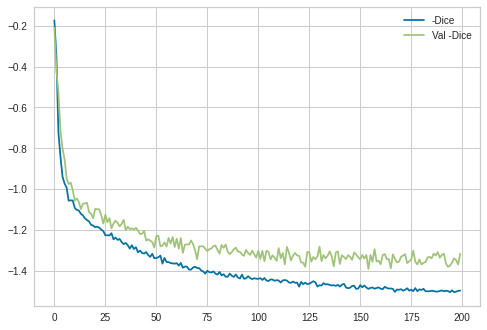

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++
Dice: 0.9879734490507392 +- 0.18707964623180925


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 22s 451ms/step - loss: -0.1717 - iou: 0.0594 - dice_coef: 0.1121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5926 - val_loss: -0.2071 - val_iou: 0.0723 - val_dice_coef: 0.1348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.5937


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 416ms/step - loss: -0.3504 - iou: 0.1279 - dice_coef: 0.2238 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8730 - val_loss: -0.3642 - val_iou: 0.1317 - val_dice_coef: 0.2325 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8716


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 426ms/step - loss: -0.6749 - iou: 0.2637 - dice_coef: 0.4141 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9487 - val_loss: -0.4569 - val_iou: 0.1689 - val_dice_coef: 0.2880 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9273


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8439 - iou: 0.3394 - dice_coef: 0.5044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9642 - val_loss: -0.5245 - val_iou: 0.1972 - val_dice_coef: 0.3273 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9481


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 418ms/step - loss: -0.9276 - iou: 0.3791 - dice_coef: 0.5478 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9689 - val_loss: -0.6226 - val_iou: 0.2389 - val_dice_coef: 0.3837 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9619


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 19s 429ms/step - loss: -0.9685 - iou: 0.3990 - dice_coef: 0.5680 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9706 - val_loss: -0.6437 - val_iou: 0.2482 - val_dice_coef: 0.3955 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9684


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 19s 432ms/step - loss: -1.0024 - iou: 0.4176 - dice_coef: 0.5860 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9725 - val_loss: -0.8586 - val_iou: 0.3459 - val_dice_coef: 0.5128 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9708


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 416ms/step - loss: -1.0308 - iou: 0.4318 - dice_coef: 0.6001 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9725 - val_loss: -0.8098 - val_iou: 0.3232 - val_dice_coef: 0.4867 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9731


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 20s 438ms/step - loss: -1.0424 - iou: 0.4374 - dice_coef: 0.6066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9733 - val_loss: -0.9802 - val_iou: 0.4061 - val_dice_coef: 0.5741 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9723


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 432ms/step - loss: -1.0712 - iou: 0.4515 - dice_coef: 0.6200 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -1.0002 - val_iou: 0.4162 - val_dice_coef: 0.5839 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 19s 416ms/step - loss: -1.0730 - iou: 0.4525 - dice_coef: 0.6204 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9743 - val_loss: -1.0405 - val_iou: 0.4362 - val_dice_coef: 0.6043 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9703


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 20s 441ms/step - loss: -1.0913 - iou: 0.4605 - dice_coef: 0.6279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9748 - val_loss: -1.0295 - val_iou: 0.4329 - val_dice_coef: 0.5966 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9700


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 432ms/step - loss: -1.1144 - iou: 0.4741 - dice_coef: 0.6407 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9758 - val_loss: -1.0488 - val_iou: 0.4416 - val_dice_coef: 0.6072 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 20s 439ms/step - loss: -1.1266 - iou: 0.4810 - dice_coef: 0.6474 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9762 - val_loss: -1.1031 - val_iou: 0.4678 - val_dice_coef: 0.6353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 19s 419ms/step - loss: -1.1408 - iou: 0.4876 - dice_coef: 0.6533 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -1.0675 - val_iou: 0.4547 - val_dice_coef: 0.6129 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9732


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 20s 436ms/step - loss: -1.1595 - iou: 0.4931 - dice_coef: 0.6577 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9774 - val_loss: -1.0996 - val_iou: 0.4679 - val_dice_coef: 0.6316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 20s 435ms/step - loss: -1.1602 - iou: 0.4980 - dice_coef: 0.6627 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9775 - val_loss: -1.0990 - val_iou: 0.4673 - val_dice_coef: 0.6317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9736


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 19s 420ms/step - loss: -1.1604 - iou: 0.4980 - dice_coef: 0.6618 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9774 - val_loss: -1.0797 - val_iou: 0.4577 - val_dice_coef: 0.6220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 20s 439ms/step - loss: -1.1715 - iou: 0.5045 - dice_coef: 0.6672 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -1.1442 - val_iou: 0.4900 - val_dice_coef: 0.6542 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 19s 427ms/step - loss: -1.1805 - iou: 0.5076 - dice_coef: 0.6707 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9782 - val_loss: -1.1510 - val_iou: 0.4934 - val_dice_coef: 0.6575 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 19s 417ms/step - loss: -1.1924 - iou: 0.5158 - dice_coef: 0.6766 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9786 - val_loss: -1.1424 - val_iou: 0.4895 - val_dice_coef: 0.6529 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 20s 441ms/step - loss: -1.2034 - iou: 0.5207 - dice_coef: 0.6825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -1.1578 - val_iou: 0.4975 - val_dice_coef: 0.6603 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 429ms/step - loss: -1.2002 - iou: 0.5212 - dice_coef: 0.6813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -1.1223 - val_iou: 0.4807 - val_dice_coef: 0.6416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 19s 416ms/step - loss: -1.2117 - iou: 0.5253 - dice_coef: 0.6862 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9791 - val_loss: -1.1320 - val_iou: 0.4864 - val_dice_coef: 0.6456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 20s 442ms/step - loss: -1.2180 - iou: 0.5298 - dice_coef: 0.6904 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9793 - val_loss: -1.1904 - val_iou: 0.5141 - val_dice_coef: 0.6763 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 19s 420ms/step - loss: -1.2130 - iou: 0.5252 - dice_coef: 0.6861 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -1.1519 - val_iou: 0.4945 - val_dice_coef: 0.6574 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 19s 415ms/step - loss: -1.2403 - iou: 0.5409 - dice_coef: 0.6995 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9801 - val_loss: -1.1407 - val_iou: 0.4912 - val_dice_coef: 0.6495 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 20s 443ms/step - loss: -1.2425 - iou: 0.5420 - dice_coef: 0.6998 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -1.1845 - val_iou: 0.5132 - val_dice_coef: 0.6712 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 20s 434ms/step - loss: -1.2569 - iou: 0.5495 - dice_coef: 0.7072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9806 - val_loss: -1.1743 - val_iou: 0.5074 - val_dice_coef: 0.6669 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 19s 428ms/step - loss: -1.2530 - iou: 0.5476 - dice_coef: 0.7050 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -1.1956 - val_iou: 0.5164 - val_dice_coef: 0.6792 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 19s 416ms/step - loss: -1.2763 - iou: 0.5600 - dice_coef: 0.7154 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -1.1969 - val_iou: 0.5189 - val_dice_coef: 0.6780 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 20s 436ms/step - loss: -1.2646 - iou: 0.5556 - dice_coef: 0.7102 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -1.1820 - val_iou: 0.5138 - val_dice_coef: 0.6682 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 19s 425ms/step - loss: -1.2578 - iou: 0.5498 - dice_coef: 0.7072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -1.1816 - val_iou: 0.5144 - val_dice_coef: 0.6672 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 19s 416ms/step - loss: -1.2803 - iou: 0.5628 - dice_coef: 0.7177 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -1.1777 - val_iou: 0.5104 - val_dice_coef: 0.6672 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 20s 439ms/step - loss: -1.2609 - iou: 0.5520 - dice_coef: 0.7084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9806 - val_loss: -1.1862 - val_iou: 0.5128 - val_dice_coef: 0.6734 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 19s 423ms/step - loss: -1.3031 - iou: 0.5742 - dice_coef: 0.7275 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -1.2220 - val_iou: 0.5313 - val_dice_coef: 0.6907 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 19s 416ms/step - loss: -1.2859 - iou: 0.5657 - dice_coef: 0.7197 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -1.1915 - val_iou: 0.5170 - val_dice_coef: 0.6745 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 20s 444ms/step - loss: -1.3039 - iou: 0.5756 - dice_coef: 0.7266 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -1.2559 - val_iou: 0.5500 - val_dice_coef: 0.7059 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 19s 415ms/step - loss: -1.2948 - iou: 0.5708 - dice_coef: 0.7236 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -1.1733 - val_iou: 0.5104 - val_dice_coef: 0.6628 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 417ms/step - loss: -1.3056 - iou: 0.5776 - dice_coef: 0.7285 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -1.2381 - val_iou: 0.5404 - val_dice_coef: 0.6977 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 20s 444ms/step - loss: -1.3008 - iou: 0.5759 - dice_coef: 0.7270 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -1.2013 - val_iou: 0.5246 - val_dice_coef: 0.6767 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 20s 435ms/step - loss: -1.3199 - iou: 0.5860 - dice_coef: 0.7351 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.2369 - val_iou: 0.5403 - val_dice_coef: 0.6966 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 19s 425ms/step - loss: -1.3140 - iou: 0.5833 - dice_coef: 0.7322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -1.2551 - val_iou: 0.5495 - val_dice_coef: 0.7055 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 417ms/step - loss: -1.3183 - iou: 0.5841 - dice_coef: 0.7337 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -1.2244 - val_iou: 0.5329 - val_dice_coef: 0.6915 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3140 - iou: 0.5831 - dice_coef: 0.7328 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -1.2337 - val_iou: 0.5403 - val_dice_coef: 0.6934 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 19s 423ms/step - loss: -1.3274 - iou: 0.5895 - dice_coef: 0.7382 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -1.2298 - val_iou: 0.5399 - val_dice_coef: 0.6899 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 19s 418ms/step - loss: -1.3434 - iou: 0.5980 - dice_coef: 0.7461 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2375 - val_iou: 0.5403 - val_dice_coef: 0.6972 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 20s 446ms/step - loss: -1.3358 - iou: 0.5939 - dice_coef: 0.7422 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -1.2521 - val_iou: 0.5469 - val_dice_coef: 0.7052 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 19s 418ms/step - loss: -1.3413 - iou: 0.5961 - dice_coef: 0.7443 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -1.2731 - val_iou: 0.5593 - val_dice_coef: 0.7139 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3336 - iou: 0.5927 - dice_coef: 0.7406 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -1.2490 - val_iou: 0.5459 - val_dice_coef: 0.7031 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 20s 445ms/step - loss: -1.3317 - iou: 0.5908 - dice_coef: 0.7404 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -1.2350 - val_iou: 0.5405 - val_dice_coef: 0.6945 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 19s 415ms/step - loss: -1.3488 - iou: 0.6018 - dice_coef: 0.7472 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -1.2685 - val_iou: 0.5565 - val_dice_coef: 0.7121 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 418ms/step - loss: -1.3543 - iou: 0.6045 - dice_coef: 0.7508 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -1.2315 - val_iou: 0.5411 - val_dice_coef: 0.6904 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 20s 441ms/step - loss: -1.3618 - iou: 0.6082 - dice_coef: 0.7530 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9838 - val_loss: -1.2486 - val_iou: 0.5498 - val_dice_coef: 0.6989 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 20s 438ms/step - loss: -1.3554 - iou: 0.6041 - dice_coef: 0.7500 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2451 - val_iou: 0.5464 - val_dice_coef: 0.6986 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3677 - iou: 0.6107 - dice_coef: 0.7570 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2322 - val_iou: 0.5422 - val_dice_coef: 0.6900 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 19s 415ms/step - loss: -1.3775 - iou: 0.6172 - dice_coef: 0.7610 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.2779 - val_iou: 0.5642 - val_dice_coef: 0.7137 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 20s 443ms/step - loss: -1.3681 - iou: 0.6114 - dice_coef: 0.7558 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.2709 - val_iou: 0.5600 - val_dice_coef: 0.7109 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 418ms/step - loss: -1.3666 - iou: 0.6110 - dice_coef: 0.7558 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2241 - val_iou: 0.5388 - val_dice_coef: 0.6853 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 19s 414ms/step - loss: -1.3865 - iou: 0.6226 - dice_coef: 0.7647 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -1.2738 - val_iou: 0.5622 - val_dice_coef: 0.7116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 445ms/step - loss: -1.3665 - iou: 0.6109 - dice_coef: 0.7555 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2885 - val_iou: 0.5709 - val_dice_coef: 0.7176 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 418ms/step - loss: -1.3790 - iou: 0.6192 - dice_coef: 0.7597 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2379 - val_iou: 0.5484 - val_dice_coef: 0.6895 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3953 - iou: 0.6212 - dice_coef: 0.7635 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2810 - val_iou: 0.5676 - val_dice_coef: 0.7133 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 442ms/step - loss: -1.3802 - iou: 0.6193 - dice_coef: 0.7607 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.3044 - val_iou: 0.5762 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 19s 417ms/step - loss: -1.3878 - iou: 0.6223 - dice_coef: 0.7649 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -1.2673 - val_iou: 0.5592 - val_dice_coef: 0.7081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 418ms/step - loss: -1.3947 - iou: 0.6268 - dice_coef: 0.7675 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.3301 - val_iou: 0.5904 - val_dice_coef: 0.7397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3921 - iou: 0.6251 - dice_coef: 0.7664 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2659 - val_iou: 0.5601 - val_dice_coef: 0.7058 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 19s 418ms/step - loss: -1.3930 - iou: 0.6274 - dice_coef: 0.7677 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2758 - val_iou: 0.5647 - val_dice_coef: 0.7111 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4062 - iou: 0.6338 - dice_coef: 0.7736 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3188 - val_iou: 0.5835 - val_dice_coef: 0.7354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 20s 436ms/step - loss: -1.3905 - iou: 0.6256 - dice_coef: 0.7654 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.3339 - val_iou: 0.5921 - val_dice_coef: 0.7418 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4008 - iou: 0.6313 - dice_coef: 0.7699 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.2816 - val_iou: 0.5659 - val_dice_coef: 0.7156 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3973 - iou: 0.6277 - dice_coef: 0.7682 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.2611 - val_iou: 0.5571 - val_dice_coef: 0.7040 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4033 - iou: 0.6330 - dice_coef: 0.7714 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2634 - val_iou: 0.5597 - val_dice_coef: 0.7037 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4050 - iou: 0.6318 - dice_coef: 0.7717 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3366 - val_iou: 0.5931 - val_dice_coef: 0.7436 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 19s 417ms/step - loss: -1.3977 - iou: 0.6293 - dice_coef: 0.7684 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.3174 - val_iou: 0.5829 - val_dice_coef: 0.7346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4180 - iou: 0.6403 - dice_coef: 0.7776 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2823 - val_iou: 0.5671 - val_dice_coef: 0.7152 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 20s 442ms/step - loss: -1.3935 - iou: 0.6286 - dice_coef: 0.7671 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2994 - val_iou: 0.5758 - val_dice_coef: 0.7237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4026 - iou: 0.6321 - dice_coef: 0.7716 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2919 - val_iou: 0.5718 - val_dice_coef: 0.7201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4187 - iou: 0.6408 - dice_coef: 0.7773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2706 - val_iou: 0.5638 - val_dice_coef: 0.7068 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4105 - iou: 0.6377 - dice_coef: 0.7753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3143 - val_iou: 0.5840 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4193 - iou: 0.6428 - dice_coef: 0.7779 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.2668 - val_iou: 0.5587 - val_dice_coef: 0.7081 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4124 - iou: 0.6378 - dice_coef: 0.7748 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3223 - val_iou: 0.5864 - val_dice_coef: 0.7359 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4196 - iou: 0.6426 - dice_coef: 0.7782 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.3126 - val_iou: 0.5829 - val_dice_coef: 0.7298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4152 - iou: 0.6398 - dice_coef: 0.7757 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3370 - val_iou: 0.5954 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4201 - iou: 0.6427 - dice_coef: 0.7787 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.3467 - val_iou: 0.5999 - val_dice_coef: 0.7468 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4230 - iou: 0.6430 - dice_coef: 0.7792 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2912 - val_iou: 0.5764 - val_dice_coef: 0.7148 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4260 - iou: 0.6451 - dice_coef: 0.7812 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.3006 - val_iou: 0.5770 - val_dice_coef: 0.7236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4241 - iou: 0.6447 - dice_coef: 0.7805 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.2752 - val_iou: 0.5662 - val_dice_coef: 0.7090 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4214 - iou: 0.6434 - dice_coef: 0.7784 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2578 - val_iou: 0.5610 - val_dice_coef: 0.6968 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 20s 448ms/step - loss: -1.4267 - iou: 0.6455 - dice_coef: 0.7808 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2788 - val_iou: 0.5681 - val_dice_coef: 0.7107 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4333 - iou: 0.6502 - dice_coef: 0.7841 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.2745 - val_iou: 0.5660 - val_dice_coef: 0.7085 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4196 - iou: 0.6425 - dice_coef: 0.7778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2392 - val_iou: 0.5458 - val_dice_coef: 0.6934 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4418 - iou: 0.6551 - dice_coef: 0.7879 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.2671 - val_iou: 0.5609 - val_dice_coef: 0.7063 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4362 - iou: 0.6505 - dice_coef: 0.7863 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3412 - val_iou: 0.5991 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4245 - iou: 0.6446 - dice_coef: 0.7795 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.3123 - val_iou: 0.5851 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 19s 433ms/step - loss: -1.4377 - iou: 0.6511 - dice_coef: 0.7857 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3097 - val_iou: 0.5846 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4398 - iou: 0.6535 - dice_coef: 0.7865 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.2977 - val_iou: 0.5778 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4410 - iou: 0.6539 - dice_coef: 0.7871 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3473 - val_iou: 0.6026 - val_dice_coef: 0.7448 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4400 - iou: 0.6536 - dice_coef: 0.7867 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3025 - val_iou: 0.5774 - val_dice_coef: 0.7250 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4422 - iou: 0.6544 - dice_coef: 0.7880 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.2926 - val_iou: 0.5766 - val_dice_coef: 0.7160 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4485 - iou: 0.6599 - dice_coef: 0.7906 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3152 - val_iou: 0.5868 - val_dice_coef: 0.7284 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4505 - iou: 0.6597 - dice_coef: 0.7916 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.2927 - val_iou: 0.5758 - val_dice_coef: 0.7169 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4335 - iou: 0.6509 - dice_coef: 0.7834 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3756 - val_iou: 0.6151 - val_dice_coef: 0.7605 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4457 - iou: 0.6555 - dice_coef: 0.7890 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.2994 - val_iou: 0.5785 - val_dice_coef: 0.7209 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4572 - iou: 0.6636 - dice_coef: 0.7948 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.2935 - val_iou: 0.5767 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4504 - iou: 0.6589 - dice_coef: 0.7912 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.2898 - val_iou: 0.5727 - val_dice_coef: 0.7171 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4447 - iou: 0.6568 - dice_coef: 0.7884 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3011 - val_iou: 0.5782 - val_dice_coef: 0.7230 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4534 - iou: 0.6617 - dice_coef: 0.7921 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3541 - val_iou: 0.6030 - val_dice_coef: 0.7511 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4535 - iou: 0.6619 - dice_coef: 0.7917 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.2919 - val_iou: 0.5774 - val_dice_coef: 0.7145 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4704 - iou: 0.6634 - dice_coef: 0.7928 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3146 - val_iou: 0.5852 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4507 - iou: 0.6583 - dice_coef: 0.7907 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3337 - val_iou: 0.5934 - val_dice_coef: 0.7402 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4623 - iou: 0.6660 - dice_coef: 0.7966 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3184 - val_iou: 0.5863 - val_dice_coef: 0.7321 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4560 - iou: 0.6630 - dice_coef: 0.7931 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3240 - val_iou: 0.5890 - val_dice_coef: 0.7350 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4595 - iou: 0.6655 - dice_coef: 0.7950 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.2937 - val_iou: 0.5783 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4434 - iou: 0.6570 - dice_coef: 0.7872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3096 - val_iou: 0.5845 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4656 - iou: 0.6686 - dice_coef: 0.7976 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3701 - val_iou: 0.6126 - val_dice_coef: 0.7575 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4674 - iou: 0.6700 - dice_coef: 0.7970 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.2825 - val_iou: 0.5710 - val_dice_coef: 0.7116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4597 - iou: 0.6655 - dice_coef: 0.7952 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3488 - val_iou: 0.6027 - val_dice_coef: 0.7461 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4599 - iou: 0.6655 - dice_coef: 0.7949 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3011 - val_iou: 0.5792 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4588 - iou: 0.6644 - dice_coef: 0.7943 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3213 - val_iou: 0.5871 - val_dice_coef: 0.7342 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4724 - iou: 0.6722 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3103 - val_iou: 0.5848 - val_dice_coef: 0.7255 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4644 - iou: 0.6678 - dice_coef: 0.7975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3474 - val_iou: 0.6023 - val_dice_coef: 0.7451 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4584 - iou: 0.6657 - dice_coef: 0.7944 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3315 - val_iou: 0.5947 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4615 - iou: 0.6657 - dice_coef: 0.7961 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3522 - val_iou: 0.6047 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4693 - iou: 0.6700 - dice_coef: 0.7993 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3397 - val_iou: 0.5999 - val_dice_coef: 0.7398 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 19s 413ms/step - loss: -1.4724 - iou: 0.6721 - dice_coef: 0.8000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3679 - val_iou: 0.6106 - val_dice_coef: 0.7573 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4674 - iou: 0.6683 - dice_coef: 0.7972 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3254 - val_iou: 0.5920 - val_dice_coef: 0.7334 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4657 - iou: 0.6685 - dice_coef: 0.7973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3569 - val_iou: 0.6062 - val_dice_coef: 0.7507 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4662 - iou: 0.6688 - dice_coef: 0.7972 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3414 - val_iou: 0.6004 - val_dice_coef: 0.7410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4784 - iou: 0.6749 - dice_coef: 0.8021 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3536 - val_iou: 0.6044 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4765 - iou: 0.6744 - dice_coef: 0.8010 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3371 - val_iou: 0.5965 - val_dice_coef: 0.7406 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4777 - iou: 0.6766 - dice_coef: 0.8023 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3232 - val_iou: 0.5896 - val_dice_coef: 0.7336 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4789 - iou: 0.6771 - dice_coef: 0.8037 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3199 - val_iou: 0.5881 - val_dice_coef: 0.7319 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4716 - iou: 0.6708 - dice_coef: 0.7986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3258 - val_iou: 0.5924 - val_dice_coef: 0.7335 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4781 - iou: 0.6754 - dice_coef: 0.8028 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3551 - val_iou: 0.6070 - val_dice_coef: 0.7481 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4801 - iou: 0.6764 - dice_coef: 0.8039 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3023 - val_iou: 0.5776 - val_dice_coef: 0.7248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4777 - iou: 0.6762 - dice_coef: 0.8021 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3398 - val_iou: 0.5974 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4849 - iou: 0.6800 - dice_coef: 0.8051 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3169 - val_iou: 0.5883 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4738 - iou: 0.6729 - dice_coef: 0.8012 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3212 - val_iou: 0.5894 - val_dice_coef: 0.7318 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4836 - iou: 0.6784 - dice_coef: 0.8043 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3133 - val_iou: 0.5847 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4820 - iou: 0.6780 - dice_coef: 0.8037 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3043 - val_iou: 0.5843 - val_dice_coef: 0.7200 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4812 - iou: 0.6776 - dice_coef: 0.8042 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3055 - val_iou: 0.5836 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4782 - iou: 0.6753 - dice_coef: 0.8028 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3455 - val_iou: 0.6035 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4821 - iou: 0.6782 - dice_coef: 0.8040 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3020 - val_iou: 0.5829 - val_dice_coef: 0.7191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4816 - iou: 0.6783 - dice_coef: 0.8034 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3707 - val_iou: 0.6138 - val_dice_coef: 0.7568 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4915 - iou: 0.6840 - dice_coef: 0.8081 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3412 - val_iou: 0.5993 - val_dice_coef: 0.7419 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4852 - iou: 0.6788 - dice_coef: 0.8063 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3121 - val_iou: 0.5843 - val_dice_coef: 0.7279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4883 - iou: 0.6813 - dice_coef: 0.8069 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3325 - val_iou: 0.5935 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4810 - iou: 0.6769 - dice_coef: 0.8026 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3193 - val_iou: 0.5875 - val_dice_coef: 0.7317 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4824 - iou: 0.6787 - dice_coef: 0.8040 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3461 - val_iou: 0.6016 - val_dice_coef: 0.7445 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4917 - iou: 0.6838 - dice_coef: 0.8081 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3729 - val_iou: 0.6162 - val_dice_coef: 0.7567 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4915 - iou: 0.6842 - dice_coef: 0.8075 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3470 - val_iou: 0.6017 - val_dice_coef: 0.7453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4853 - iou: 0.6808 - dice_coef: 0.8054 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3464 - val_iou: 0.6004 - val_dice_coef: 0.7461 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4907 - iou: 0.6836 - dice_coef: 0.8079 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3338 - val_iou: 0.5965 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4963 - iou: 0.6862 - dice_coef: 0.8116 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3733 - val_iou: 0.6162 - val_dice_coef: 0.7571 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4924 - iou: 0.6835 - dice_coef: 0.8089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3171 - val_iou: 0.5888 - val_dice_coef: 0.7283 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 20s 447ms/step - loss: -1.5066 - iou: 0.6852 - dice_coef: 0.8101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3277 - val_iou: 0.5938 - val_dice_coef: 0.7339 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4972 - iou: 0.6867 - dice_coef: 0.8116 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3463 - val_iou: 0.6021 - val_dice_coef: 0.7443 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 19s 415ms/step - loss: -1.4887 - iou: 0.6826 - dice_coef: 0.8074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3323 - val_iou: 0.5957 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4922 - iou: 0.6852 - dice_coef: 0.8085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3180 - val_iou: 0.5908 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4932 - iou: 0.6844 - dice_coef: 0.8083 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3182 - val_iou: 0.5873 - val_dice_coef: 0.7309 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4876 - iou: 0.6812 - dice_coef: 0.8065 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3546 - val_iou: 0.6041 - val_dice_coef: 0.7505 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4931 - iou: 0.6846 - dice_coef: 0.8081 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3776 - val_iou: 0.6172 - val_dice_coef: 0.7604 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5001 - iou: 0.6880 - dice_coef: 0.8111 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3211 - val_iou: 0.5907 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4969 - iou: 0.6872 - dice_coef: 0.8108 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3247 - val_iou: 0.5889 - val_dice_coef: 0.7357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4929 - iou: 0.6835 - dice_coef: 0.8092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3297 - val_iou: 0.5955 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4965 - iou: 0.6864 - dice_coef: 0.8106 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3396 - val_iou: 0.5979 - val_dice_coef: 0.7417 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4952 - iou: 0.6862 - dice_coef: 0.8095 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3316 - val_iou: 0.5950 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4846 - iou: 0.6805 - dice_coef: 0.8052 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3240 - val_iou: 0.5900 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5045 - iou: 0.6920 - dice_coef: 0.8142 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3219 - val_iou: 0.5939 - val_dice_coef: 0.7280 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 19s 419ms/step - loss: -1.5076 - iou: 0.6929 - dice_coef: 0.8153 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3680 - val_iou: 0.6128 - val_dice_coef: 0.7553 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 19s 419ms/step - loss: -1.5036 - iou: 0.6903 - dice_coef: 0.8133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3587 - val_iou: 0.6075 - val_dice_coef: 0.7511 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5036 - iou: 0.6902 - dice_coef: 0.8142 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3306 - val_iou: 0.5943 - val_dice_coef: 0.7363 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4998 - iou: 0.6877 - dice_coef: 0.8117 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3404 - val_iou: 0.5997 - val_dice_coef: 0.7407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 19s 421ms/step - loss: -1.5075 - iou: 0.6928 - dice_coef: 0.8141 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3312 - val_iou: 0.5943 - val_dice_coef: 0.7370 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4971 - iou: 0.6871 - dice_coef: 0.8106 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3416 - val_iou: 0.6004 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 19s 418ms/step - loss: -1.5148 - iou: 0.6949 - dice_coef: 0.8173 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3275 - val_iou: 0.5965 - val_dice_coef: 0.7310 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4963 - iou: 0.6866 - dice_coef: 0.8105 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3336 - val_iou: 0.5988 - val_dice_coef: 0.7348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 440ms/step - loss: -1.5125 - iou: 0.6956 - dice_coef: 0.8172 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3187 - val_iou: 0.5916 - val_dice_coef: 0.7270 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 19s 416ms/step - loss: -1.4885 - iou: 0.6824 - dice_coef: 0.8064 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.2998 - val_iou: 0.5784 - val_dice_coef: 0.7215 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4992 - iou: 0.6872 - dice_coef: 0.8113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3205 - val_iou: 0.5899 - val_dice_coef: 0.7306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 20s 436ms/step - loss: -1.5159 - iou: 0.6961 - dice_coef: 0.8178 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.2995 - val_iou: 0.5784 - val_dice_coef: 0.7211 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 20s 446ms/step - loss: -1.4937 - iou: 0.6841 - dice_coef: 0.8092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3232 - val_iou: 0.5925 - val_dice_coef: 0.7307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 19s 417ms/step - loss: -1.5096 - iou: 0.6934 - dice_coef: 0.8155 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3508 - val_iou: 0.6063 - val_dice_coef: 0.7445 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 19s 419ms/step - loss: -1.5046 - iou: 0.6908 - dice_coef: 0.8131 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.2993 - val_iou: 0.5813 - val_dice_coef: 0.7180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 20s 446ms/step - loss: -1.5087 - iou: 0.6933 - dice_coef: 0.8158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3443 - val_iou: 0.6012 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 19s 418ms/step - loss: -1.5022 - iou: 0.6904 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3535 - val_iou: 0.6069 - val_dice_coef: 0.7466 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5014 - iou: 0.6900 - dice_coef: 0.8123 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3424 - val_iou: 0.6011 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 20s 440ms/step - loss: -1.5088 - iou: 0.6939 - dice_coef: 0.8148 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3193 - val_iou: 0.5914 - val_dice_coef: 0.7279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 19s 417ms/step - loss: -1.5073 - iou: 0.6921 - dice_coef: 0.8144 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3704 - val_iou: 0.6140 - val_dice_coef: 0.7564 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4901 - iou: 0.6820 - dice_coef: 0.8072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3297 - val_iou: 0.5949 - val_dice_coef: 0.7348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4980 - iou: 0.6873 - dice_coef: 0.8097 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3395 - val_iou: 0.6031 - val_dice_coef: 0.7364 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5169 - iou: 0.6978 - dice_coef: 0.8191 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3310 - val_iou: 0.5979 - val_dice_coef: 0.7331 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5036 - iou: 0.6915 - dice_coef: 0.8129 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3139 - val_iou: 0.5883 - val_dice_coef: 0.7256 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5099 - iou: 0.6945 - dice_coef: 0.8150 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3238 - val_iou: 0.5903 - val_dice_coef: 0.7335 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 19s 419ms/step - loss: -1.5113 - iou: 0.6947 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3353 - val_iou: 0.5987 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 20s 439ms/step - loss: -1.5166 - iou: 0.6980 - dice_coef: 0.8175 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3333 - val_iou: 0.5987 - val_dice_coef: 0.7345 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 20s 435ms/step - loss: -1.5122 - iou: 0.6966 - dice_coef: 0.8165 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3588 - val_iou: 0.6095 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 20s 438ms/step - loss: -1.5168 - iou: 0.6978 - dice_coef: 0.8182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3096 - val_iou: 0.5838 - val_dice_coef: 0.7257 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 19s 418ms/step - loss: -1.5092 - iou: 0.6939 - dice_coef: 0.8152 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3507 - val_iou: 0.6043 - val_dice_coef: 0.7463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-16/Model_Checkpoint/assets


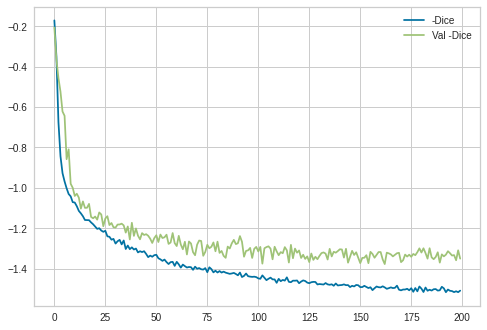

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++
Dice: 0.9881305653561828 +- 0.19348145925227805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 22s 455ms/step - loss: -0.2197 - iou: 0.0786 - dice_coef: 0.1439 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7671 - val_loss: -0.3726 - val_iou: 0.1351 - val_dice_coef: 0.2376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9223


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 19s 418ms/step - loss: -0.6231 - iou: 0.2425 - dice_coef: 0.3870 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9488 - val_loss: -0.5672 - val_iou: 0.2149 - val_dice_coef: 0.3523 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9423


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 432ms/step - loss: -0.8173 - iou: 0.3269 - dice_coef: 0.4899 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9647 - val_loss: -0.6800 - val_iou: 0.2651 - val_dice_coef: 0.4149 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9579


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 20s 439ms/step - loss: -0.9005 - iou: 0.3665 - dice_coef: 0.5340 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9685 - val_loss: -0.6873 - val_iou: 0.2675 - val_dice_coef: 0.4199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9464


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 19s 423ms/step - loss: -0.9704 - iou: 0.3967 - dice_coef: 0.5654 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9712 - val_loss: -0.8402 - val_iou: 0.3397 - val_dice_coef: 0.5005 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9636


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 20s 435ms/step - loss: -1.0367 - iou: 0.4337 - dice_coef: 0.6033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9739 - val_loss: -0.9288 - val_iou: 0.3826 - val_dice_coef: 0.5461 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9646


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 20s 435ms/step - loss: -1.0637 - iou: 0.4473 - dice_coef: 0.6161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -0.9888 - val_iou: 0.4117 - val_dice_coef: 0.5772 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9726


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 20s 446ms/step - loss: -1.0702 - iou: 0.4508 - dice_coef: 0.6184 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9740 - val_loss: -1.0394 - val_iou: 0.4362 - val_dice_coef: 0.6032 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 19s 418ms/step - loss: -1.0945 - iou: 0.4641 - dice_coef: 0.6309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9755 - val_loss: -1.0248 - val_iou: 0.4305 - val_dice_coef: 0.5943 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9700


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 428ms/step - loss: -1.1208 - iou: 0.4785 - dice_coef: 0.6439 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9764 - val_loss: -1.0767 - val_iou: 0.4557 - val_dice_coef: 0.6211 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 20s 441ms/step - loss: -1.1274 - iou: 0.4813 - dice_coef: 0.6464 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9765 - val_loss: -1.0826 - val_iou: 0.4606 - val_dice_coef: 0.6219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 19s 419ms/step - loss: -1.1380 - iou: 0.4855 - dice_coef: 0.6513 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9770 - val_loss: -1.0920 - val_iou: 0.4656 - val_dice_coef: 0.6264 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9743


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 432ms/step - loss: -1.1556 - iou: 0.4951 - dice_coef: 0.6602 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9776 - val_loss: -1.0962 - val_iou: 0.4676 - val_dice_coef: 0.6286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 20s 443ms/step - loss: -1.1641 - iou: 0.5000 - dice_coef: 0.6640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -1.0734 - val_iou: 0.4544 - val_dice_coef: 0.6191 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 19s 419ms/step - loss: -1.1710 - iou: 0.5034 - dice_coef: 0.6686 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9779 - val_loss: -1.1353 - val_iou: 0.4859 - val_dice_coef: 0.6493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 20s 437ms/step - loss: -1.1599 - iou: 0.4986 - dice_coef: 0.6623 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -1.1370 - val_iou: 0.4864 - val_dice_coef: 0.6506 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 19s 431ms/step - loss: -1.1944 - iou: 0.5152 - dice_coef: 0.6764 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9786 - val_loss: -1.1226 - val_iou: 0.4794 - val_dice_coef: 0.6432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 19s 418ms/step - loss: -1.1875 - iou: 0.5120 - dice_coef: 0.6744 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -1.1159 - val_iou: 0.4775 - val_dice_coef: 0.6384 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 20s 442ms/step - loss: -1.2008 - iou: 0.5184 - dice_coef: 0.6799 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9788 - val_loss: -1.1490 - val_iou: 0.4942 - val_dice_coef: 0.6548 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9753


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 19s 425ms/step - loss: -1.2132 - iou: 0.5259 - dice_coef: 0.6862 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -1.1456 - val_iou: 0.4927 - val_dice_coef: 0.6528 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 19s 418ms/step - loss: -1.2184 - iou: 0.5290 - dice_coef: 0.6884 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -1.1274 - val_iou: 0.4836 - val_dice_coef: 0.6437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9737


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 20s 447ms/step - loss: -1.2046 - iou: 0.5210 - dice_coef: 0.6825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9790 - val_loss: -1.1165 - val_iou: 0.4795 - val_dice_coef: 0.6370 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 20s 438ms/step - loss: -1.2226 - iou: 0.5314 - dice_coef: 0.6906 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -1.1564 - val_iou: 0.4998 - val_dice_coef: 0.6565 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 20s 436ms/step - loss: -1.2278 - iou: 0.5352 - dice_coef: 0.6939 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -1.1517 - val_iou: 0.4966 - val_dice_coef: 0.6551 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 19s 419ms/step - loss: -1.2274 - iou: 0.5338 - dice_coef: 0.6929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -1.1694 - val_iou: 0.5049 - val_dice_coef: 0.6646 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9756


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 20s 439ms/step - loss: -1.2547 - iou: 0.5485 - dice_coef: 0.7053 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -1.1279 - val_iou: 0.4882 - val_dice_coef: 0.6397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9760


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 20s 433ms/step - loss: -1.2273 - iou: 0.5335 - dice_coef: 0.6926 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -1.1502 - val_iou: 0.4948 - val_dice_coef: 0.6554 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 19s 420ms/step - loss: -1.2547 - iou: 0.5486 - dice_coef: 0.7052 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -1.1792 - val_iou: 0.5109 - val_dice_coef: 0.6683 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 20s 443ms/step - loss: -1.2600 - iou: 0.5522 - dice_coef: 0.7077 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9807 - val_loss: -1.1542 - val_iou: 0.5026 - val_dice_coef: 0.6517 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 19s 424ms/step - loss: -1.2673 - iou: 0.5574 - dice_coef: 0.7116 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -1.1513 - val_iou: 0.4959 - val_dice_coef: 0.6553 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 19s 420ms/step - loss: -1.2622 - iou: 0.5524 - dice_coef: 0.7092 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -1.2013 - val_iou: 0.5221 - val_dice_coef: 0.6792 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 20s 448ms/step - loss: -1.2725 - iou: 0.5581 - dice_coef: 0.7128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -1.1817 - val_iou: 0.5159 - val_dice_coef: 0.6658 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 19s 419ms/step - loss: -1.2797 - iou: 0.5633 - dice_coef: 0.7169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -1.1849 - val_iou: 0.5150 - val_dice_coef: 0.6700 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 19s 417ms/step - loss: -1.2805 - iou: 0.5630 - dice_coef: 0.7166 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -1.1855 - val_iou: 0.5161 - val_dice_coef: 0.6694 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 20s 448ms/step - loss: -1.2935 - iou: 0.5712 - dice_coef: 0.7233 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -1.1917 - val_iou: 0.5172 - val_dice_coef: 0.6745 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9760


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 439ms/step - loss: -1.2854 - iou: 0.5666 - dice_coef: 0.7188 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9813 - val_loss: -1.2499 - val_iou: 0.5465 - val_dice_coef: 0.7034 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 19s 428ms/step - loss: -1.3035 - iou: 0.5770 - dice_coef: 0.7278 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -1.2127 - val_iou: 0.5282 - val_dice_coef: 0.6844 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3091 - iou: 0.5773 - dice_coef: 0.7290 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -1.2052 - val_iou: 0.5277 - val_dice_coef: 0.6775 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 20s 445ms/step - loss: -1.3137 - iou: 0.5821 - dice_coef: 0.7327 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.2630 - val_iou: 0.5526 - val_dice_coef: 0.7104 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 426ms/step - loss: -1.3017 - iou: 0.5747 - dice_coef: 0.7276 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -1.2074 - val_iou: 0.5281 - val_dice_coef: 0.6793 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3155 - iou: 0.5813 - dice_coef: 0.7311 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -1.2539 - val_iou: 0.5488 - val_dice_coef: 0.7051 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 20s 450ms/step - loss: -1.3136 - iou: 0.5818 - dice_coef: 0.7322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9822 - val_loss: -1.2753 - val_iou: 0.5609 - val_dice_coef: 0.7144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 19s 419ms/step - loss: -1.3357 - iou: 0.5930 - dice_coef: 0.7411 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -1.2720 - val_iou: 0.5591 - val_dice_coef: 0.7128 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 421ms/step - loss: -1.3346 - iou: 0.5945 - dice_coef: 0.7409 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -1.2412 - val_iou: 0.5463 - val_dice_coef: 0.6949 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 20s 449ms/step - loss: -1.3504 - iou: 0.6015 - dice_coef: 0.7481 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2108 - val_iou: 0.5284 - val_dice_coef: 0.6824 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 19s 419ms/step - loss: -1.3456 - iou: 0.5996 - dice_coef: 0.7468 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2255 - val_iou: 0.5354 - val_dice_coef: 0.6900 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 19s 424ms/step - loss: -1.3522 - iou: 0.6044 - dice_coef: 0.7503 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2472 - val_iou: 0.5474 - val_dice_coef: 0.6998 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 20s 446ms/step - loss: -1.3424 - iou: 0.5980 - dice_coef: 0.7443 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2306 - val_iou: 0.5409 - val_dice_coef: 0.6897 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 19s 419ms/step - loss: -1.3563 - iou: 0.6051 - dice_coef: 0.7507 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2322 - val_iou: 0.5395 - val_dice_coef: 0.6927 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 19s 431ms/step - loss: -1.3613 - iou: 0.6077 - dice_coef: 0.7527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -1.2004 - val_iou: 0.5248 - val_dice_coef: 0.6756 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 20s 438ms/step - loss: -1.3486 - iou: 0.6011 - dice_coef: 0.7476 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -1.2456 - val_iou: 0.5514 - val_dice_coef: 0.6942 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 20s 454ms/step - loss: -1.3795 - iou: 0.6123 - dice_coef: 0.7565 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -1.2664 - val_iou: 0.5572 - val_dice_coef: 0.7092 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3743 - iou: 0.6161 - dice_coef: 0.7591 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -1.2931 - val_iou: 0.5694 - val_dice_coef: 0.7237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 19s 425ms/step - loss: -1.3712 - iou: 0.6150 - dice_coef: 0.7583 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -1.2672 - val_iou: 0.5592 - val_dice_coef: 0.7080 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 20s 446ms/step - loss: -1.3771 - iou: 0.6171 - dice_coef: 0.7595 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2592 - val_iou: 0.5550 - val_dice_coef: 0.7042 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 419ms/step - loss: -1.3836 - iou: 0.6226 - dice_coef: 0.7627 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.2626 - val_iou: 0.5561 - val_dice_coef: 0.7065 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 19s 429ms/step - loss: -1.3649 - iou: 0.6105 - dice_coef: 0.7548 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.2565 - val_iou: 0.5562 - val_dice_coef: 0.7003 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 20s 441ms/step - loss: -1.3870 - iou: 0.6228 - dice_coef: 0.7637 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -1.2412 - val_iou: 0.5504 - val_dice_coef: 0.6908 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3763 - iou: 0.6177 - dice_coef: 0.7599 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2778 - val_iou: 0.5634 - val_dice_coef: 0.7144 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 19s 432ms/step - loss: -1.3810 - iou: 0.6200 - dice_coef: 0.7616 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.3444 - val_iou: 0.5974 - val_dice_coef: 0.7470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4032 - iou: 0.6311 - dice_coef: 0.7716 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2843 - val_iou: 0.5673 - val_dice_coef: 0.7169 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3886 - iou: 0.6245 - dice_coef: 0.7653 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2655 - val_iou: 0.5584 - val_dice_coef: 0.7071 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4031 - iou: 0.6319 - dice_coef: 0.7713 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.3266 - val_iou: 0.5877 - val_dice_coef: 0.7388 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4035 - iou: 0.6329 - dice_coef: 0.7716 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2637 - val_iou: 0.5610 - val_dice_coef: 0.7027 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4048 - iou: 0.6346 - dice_coef: 0.7717 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2540 - val_iou: 0.5545 - val_dice_coef: 0.6994 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4081 - iou: 0.6354 - dice_coef: 0.7739 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2619 - val_iou: 0.5587 - val_dice_coef: 0.7032 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4040 - iou: 0.6331 - dice_coef: 0.7716 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2655 - val_iou: 0.5594 - val_dice_coef: 0.7061 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4041 - iou: 0.6330 - dice_coef: 0.7717 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2819 - val_iou: 0.5684 - val_dice_coef: 0.7135 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4074 - iou: 0.6339 - dice_coef: 0.7732 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.2921 - val_iou: 0.5739 - val_dice_coef: 0.7182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4165 - iou: 0.6404 - dice_coef: 0.7776 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2946 - val_iou: 0.5748 - val_dice_coef: 0.7198 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4164 - iou: 0.6389 - dice_coef: 0.7767 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2708 - val_iou: 0.5628 - val_dice_coef: 0.7079 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 20s 449ms/step - loss: -1.4034 - iou: 0.6325 - dice_coef: 0.7702 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.3252 - val_iou: 0.5884 - val_dice_coef: 0.7367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4278 - iou: 0.6466 - dice_coef: 0.7813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3236 - val_iou: 0.5870 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4117 - iou: 0.6355 - dice_coef: 0.7735 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2874 - val_iou: 0.5704 - val_dice_coef: 0.7170 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4254 - iou: 0.6460 - dice_coef: 0.7801 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2776 - val_iou: 0.5673 - val_dice_coef: 0.7103 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 20s 450ms/step - loss: -1.4180 - iou: 0.6421 - dice_coef: 0.7781 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2667 - val_iou: 0.5618 - val_dice_coef: 0.7048 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4172 - iou: 0.6401 - dice_coef: 0.7774 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.2973 - val_iou: 0.5750 - val_dice_coef: 0.7222 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 417ms/step - loss: -1.4286 - iou: 0.6477 - dice_coef: 0.7823 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3188 - val_iou: 0.5850 - val_dice_coef: 0.7338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 20s 448ms/step - loss: -1.4286 - iou: 0.6462 - dice_coef: 0.7818 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.2839 - val_iou: 0.5686 - val_dice_coef: 0.7153 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4250 - iou: 0.6447 - dice_coef: 0.7800 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2971 - val_iou: 0.5752 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4282 - iou: 0.6482 - dice_coef: 0.7820 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3301 - val_iou: 0.5914 - val_dice_coef: 0.7387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4402 - iou: 0.6536 - dice_coef: 0.7868 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3008 - val_iou: 0.5791 - val_dice_coef: 0.7217 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4383 - iou: 0.6522 - dice_coef: 0.7866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.2981 - val_iou: 0.5797 - val_dice_coef: 0.7184 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4396 - iou: 0.6527 - dice_coef: 0.7865 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3073 - val_iou: 0.5814 - val_dice_coef: 0.7259 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4411 - iou: 0.6540 - dice_coef: 0.7881 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.2800 - val_iou: 0.5684 - val_dice_coef: 0.7116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 20s 448ms/step - loss: -1.4285 - iou: 0.6472 - dice_coef: 0.7818 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.2736 - val_iou: 0.5654 - val_dice_coef: 0.7082 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4353 - iou: 0.6512 - dice_coef: 0.7845 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.3302 - val_iou: 0.5933 - val_dice_coef: 0.7368 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4538 - iou: 0.6616 - dice_coef: 0.7938 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3040 - val_iou: 0.5818 - val_dice_coef: 0.7222 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4414 - iou: 0.6557 - dice_coef: 0.7869 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3232 - val_iou: 0.5875 - val_dice_coef: 0.7357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4446 - iou: 0.6563 - dice_coef: 0.7882 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3061 - val_iou: 0.5830 - val_dice_coef: 0.7231 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4479 - iou: 0.6584 - dice_coef: 0.7907 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3250 - val_iou: 0.5884 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 20s 446ms/step - loss: -1.4458 - iou: 0.6561 - dice_coef: 0.7891 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.2846 - val_iou: 0.5701 - val_dice_coef: 0.7146 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4435 - iou: 0.6565 - dice_coef: 0.7878 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3308 - val_iou: 0.5935 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4557 - iou: 0.6630 - dice_coef: 0.7930 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3409 - val_iou: 0.5973 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4518 - iou: 0.6603 - dice_coef: 0.7922 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3228 - val_iou: 0.5897 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4611 - iou: 0.6662 - dice_coef: 0.7958 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3022 - val_iou: 0.5786 - val_dice_coef: 0.7236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4624 - iou: 0.6657 - dice_coef: 0.7957 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3614 - val_iou: 0.6079 - val_dice_coef: 0.7536 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4558 - iou: 0.6623 - dice_coef: 0.7935 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.2936 - val_iou: 0.5743 - val_dice_coef: 0.7194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 20s 451ms/step - loss: -1.4744 - iou: 0.6665 - dice_coef: 0.7969 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3466 - val_iou: 0.5999 - val_dice_coef: 0.7466 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4604 - iou: 0.6654 - dice_coef: 0.7954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3138 - val_iou: 0.5857 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4574 - iou: 0.6638 - dice_coef: 0.7943 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3406 - val_iou: 0.5966 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4704 - iou: 0.6714 - dice_coef: 0.8004 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3201 - val_iou: 0.5889 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4668 - iou: 0.6684 - dice_coef: 0.7977 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.2941 - val_iou: 0.5746 - val_dice_coef: 0.7195 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 20s 433ms/step - loss: -1.4593 - iou: 0.6647 - dice_coef: 0.7938 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3021 - val_iou: 0.5772 - val_dice_coef: 0.7248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4630 - iou: 0.6665 - dice_coef: 0.7963 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3140 - val_iou: 0.5849 - val_dice_coef: 0.7292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 20s 448ms/step - loss: -1.4669 - iou: 0.6692 - dice_coef: 0.7978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3211 - val_iou: 0.5910 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4685 - iou: 0.6702 - dice_coef: 0.7985 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3363 - val_iou: 0.5949 - val_dice_coef: 0.7414 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4565 - iou: 0.6630 - dice_coef: 0.7928 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3026 - val_iou: 0.5827 - val_dice_coef: 0.7199 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4626 - iou: 0.6664 - dice_coef: 0.7954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.2903 - val_iou: 0.5729 - val_dice_coef: 0.7174 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4716 - iou: 0.6713 - dice_coef: 0.8000 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.2941 - val_iou: 0.5777 - val_dice_coef: 0.7163 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4636 - iou: 0.6680 - dice_coef: 0.7968 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3212 - val_iou: 0.5889 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4803 - iou: 0.6766 - dice_coef: 0.8041 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3331 - val_iou: 0.5944 - val_dice_coef: 0.7387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 19s 418ms/step - loss: -1.4639 - iou: 0.6668 - dice_coef: 0.7961 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.2799 - val_iou: 0.5687 - val_dice_coef: 0.7111 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4711 - iou: 0.6711 - dice_coef: 0.8006 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3068 - val_iou: 0.5840 - val_dice_coef: 0.7227 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 20s 435ms/step - loss: -1.4648 - iou: 0.6691 - dice_coef: 0.7983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.2833 - val_iou: 0.5718 - val_dice_coef: 0.7116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4677 - iou: 0.6687 - dice_coef: 0.7978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3265 - val_iou: 0.5905 - val_dice_coef: 0.7360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4707 - iou: 0.6714 - dice_coef: 0.7999 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3321 - val_iou: 0.5942 - val_dice_coef: 0.7378 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4795 - iou: 0.6761 - dice_coef: 0.8029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3244 - val_iou: 0.5920 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4757 - iou: 0.6761 - dice_coef: 0.8015 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3091 - val_iou: 0.5835 - val_dice_coef: 0.7255 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4799 - iou: 0.6768 - dice_coef: 0.8028 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3491 - val_iou: 0.6014 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4813 - iou: 0.6769 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3266 - val_iou: 0.5917 - val_dice_coef: 0.7350 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4788 - iou: 0.6754 - dice_coef: 0.8041 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3364 - val_iou: 0.5971 - val_dice_coef: 0.7393 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4804 - iou: 0.6766 - dice_coef: 0.8036 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3519 - val_iou: 0.6027 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4835 - iou: 0.6800 - dice_coef: 0.8051 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.2967 - val_iou: 0.5770 - val_dice_coef: 0.7197 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4895 - iou: 0.6827 - dice_coef: 0.8075 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3383 - val_iou: 0.5978 - val_dice_coef: 0.7405 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 19s 419ms/step - loss: -1.4775 - iou: 0.6758 - dice_coef: 0.8019 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3471 - val_iou: 0.6003 - val_dice_coef: 0.7467 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4922 - iou: 0.6839 - dice_coef: 0.8094 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3091 - val_iou: 0.5852 - val_dice_coef: 0.7239 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4909 - iou: 0.6828 - dice_coef: 0.8086 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3280 - val_iou: 0.5925 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4825 - iou: 0.6786 - dice_coef: 0.8037 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3437 - val_iou: 0.6000 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4971 - iou: 0.6861 - dice_coef: 0.8104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3415 - val_iou: 0.5998 - val_dice_coef: 0.7417 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4804 - iou: 0.6778 - dice_coef: 0.8026 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3675 - val_iou: 0.6118 - val_dice_coef: 0.7557 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4925 - iou: 0.6841 - dice_coef: 0.8090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3269 - val_iou: 0.5926 - val_dice_coef: 0.7343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 20s 453ms/step - loss: -1.4901 - iou: 0.6834 - dice_coef: 0.8072 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3249 - val_iou: 0.5935 - val_dice_coef: 0.7314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4960 - iou: 0.6848 - dice_coef: 0.8096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3305 - val_iou: 0.5937 - val_dice_coef: 0.7368 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4861 - iou: 0.6817 - dice_coef: 0.8063 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3184 - val_iou: 0.5896 - val_dice_coef: 0.7287 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4963 - iou: 0.6845 - dice_coef: 0.8096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3136 - val_iou: 0.5873 - val_dice_coef: 0.7263 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4952 - iou: 0.6865 - dice_coef: 0.8103 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3442 - val_iou: 0.6018 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4958 - iou: 0.6867 - dice_coef: 0.8102 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3546 - val_iou: 0.6045 - val_dice_coef: 0.7501 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 19s 419ms/step - loss: -1.5028 - iou: 0.6909 - dice_coef: 0.8130 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3136 - val_iou: 0.5861 - val_dice_coef: 0.7275 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 20s 449ms/step - loss: -1.4870 - iou: 0.6824 - dice_coef: 0.8066 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3297 - val_iou: 0.5949 - val_dice_coef: 0.7348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4908 - iou: 0.6829 - dice_coef: 0.8075 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3016 - val_iou: 0.5812 - val_dice_coef: 0.7204 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4836 - iou: 0.6798 - dice_coef: 0.8043 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3771 - val_iou: 0.6176 - val_dice_coef: 0.7596 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 20s 452ms/step - loss: -1.4875 - iou: 0.6820 - dice_coef: 0.8067 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3202 - val_iou: 0.5897 - val_dice_coef: 0.7305 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 19s 420ms/step - loss: -1.4960 - iou: 0.6860 - dice_coef: 0.8099 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3241 - val_iou: 0.5950 - val_dice_coef: 0.7291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5020 - iou: 0.6898 - dice_coef: 0.8122 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3223 - val_iou: 0.5909 - val_dice_coef: 0.7314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5095 - iou: 0.6865 - dice_coef: 0.8103 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3420 - val_iou: 0.6022 - val_dice_coef: 0.7398 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4989 - iou: 0.6878 - dice_coef: 0.8115 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3356 - val_iou: 0.5964 - val_dice_coef: 0.7391 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 20s 433ms/step - loss: -1.5000 - iou: 0.6881 - dice_coef: 0.8120 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3514 - val_iou: 0.6039 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 20s 439ms/step - loss: -1.5004 - iou: 0.6884 - dice_coef: 0.8117 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3457 - val_iou: 0.6019 - val_dice_coef: 0.7438 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 20s 451ms/step - loss: -1.5077 - iou: 0.6922 - dice_coef: 0.8144 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3621 - val_iou: 0.6094 - val_dice_coef: 0.7527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5051 - iou: 0.6923 - dice_coef: 0.8145 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3158 - val_iou: 0.5884 - val_dice_coef: 0.7274 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 423ms/step - loss: -1.5155 - iou: 0.6971 - dice_coef: 0.8182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3058 - val_iou: 0.5839 - val_dice_coef: 0.7219 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4969 - iou: 0.6868 - dice_coef: 0.8102 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3479 - val_iou: 0.6026 - val_dice_coef: 0.7453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5065 - iou: 0.6920 - dice_coef: 0.8145 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3545 - val_iou: 0.6053 - val_dice_coef: 0.7493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5033 - iou: 0.6895 - dice_coef: 0.8120 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3188 - val_iou: 0.5891 - val_dice_coef: 0.7297 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5083 - iou: 0.6940 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3099 - val_iou: 0.5850 - val_dice_coef: 0.7249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 19s 421ms/step - loss: -1.5065 - iou: 0.6920 - dice_coef: 0.8137 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3416 - val_iou: 0.5983 - val_dice_coef: 0.7433 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 20s 433ms/step - loss: -1.5039 - iou: 0.6922 - dice_coef: 0.8133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3117 - val_iou: 0.5858 - val_dice_coef: 0.7259 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 20s 436ms/step - loss: -1.5025 - iou: 0.6908 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3446 - val_iou: 0.6025 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5101 - iou: 0.6949 - dice_coef: 0.8157 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.2948 - val_iou: 0.5770 - val_dice_coef: 0.7179 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 442ms/step - loss: -1.5055 - iou: 0.6921 - dice_coef: 0.8143 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3714 - val_iou: 0.6142 - val_dice_coef: 0.7573 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 20s 439ms/step - loss: -1.5136 - iou: 0.6966 - dice_coef: 0.8175 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3227 - val_iou: 0.5919 - val_dice_coef: 0.7308 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5164 - iou: 0.6979 - dice_coef: 0.8191 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3737 - val_iou: 0.6160 - val_dice_coef: 0.7577 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 19s 421ms/step - loss: -1.5016 - iou: 0.6897 - dice_coef: 0.8127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3217 - val_iou: 0.5871 - val_dice_coef: 0.7345 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 20s 433ms/step - loss: -1.5141 - iou: 0.6968 - dice_coef: 0.8184 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3219 - val_iou: 0.5896 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 20s 438ms/step - loss: -1.5082 - iou: 0.6935 - dice_coef: 0.8149 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3260 - val_iou: 0.5923 - val_dice_coef: 0.7337 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 19s 422ms/step - loss: -1.5230 - iou: 0.7019 - dice_coef: 0.8211 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3357 - val_iou: 0.5977 - val_dice_coef: 0.7380 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5124 - iou: 0.6959 - dice_coef: 0.8176 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3352 - val_iou: 0.5976 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 20s 434ms/step - loss: -1.5074 - iou: 0.6937 - dice_coef: 0.8147 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3134 - val_iou: 0.5861 - val_dice_coef: 0.7274 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 19s 421ms/step - loss: -1.5113 - iou: 0.6961 - dice_coef: 0.8168 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3273 - val_iou: 0.5932 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5158 - iou: 0.6986 - dice_coef: 0.8182 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3202 - val_iou: 0.5892 - val_dice_coef: 0.7309 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5183 - iou: 0.7001 - dice_coef: 0.8193 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3314 - val_iou: 0.5958 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5182 - iou: 0.6996 - dice_coef: 0.8193 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3102 - val_iou: 0.5859 - val_dice_coef: 0.7243 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5236 - iou: 0.7024 - dice_coef: 0.8224 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3519 - val_iou: 0.6051 - val_dice_coef: 0.7468 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5159 - iou: 0.6966 - dice_coef: 0.8179 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3006 - val_iou: 0.5827 - val_dice_coef: 0.7179 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5171 - iou: 0.6983 - dice_coef: 0.8189 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3072 - val_iou: 0.5836 - val_dice_coef: 0.7236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 20s 452ms/step - loss: -1.5135 - iou: 0.6970 - dice_coef: 0.8167 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3523 - val_iou: 0.6048 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5187 - iou: 0.6998 - dice_coef: 0.8197 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3323 - val_iou: 0.5979 - val_dice_coef: 0.7344 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5213 - iou: 0.7019 - dice_coef: 0.8200 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3267 - val_iou: 0.5941 - val_dice_coef: 0.7326 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 19s 419ms/step - loss: -1.5220 - iou: 0.7016 - dice_coef: 0.8214 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3212 - val_iou: 0.5909 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5194 - iou: 0.7002 - dice_coef: 0.8197 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3468 - val_iou: 0.6017 - val_dice_coef: 0.7452 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5316 - iou: 0.7067 - dice_coef: 0.8252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3297 - val_iou: 0.5952 - val_dice_coef: 0.7344 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5227 - iou: 0.7032 - dice_coef: 0.8212 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3437 - val_iou: 0.6038 - val_dice_coef: 0.7399 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5190 - iou: 0.7001 - dice_coef: 0.8192 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3646 - val_iou: 0.6106 - val_dice_coef: 0.7539 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 19s 420ms/step - loss: -1.5194 - iou: 0.7003 - dice_coef: 0.8196 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3248 - val_iou: 0.5926 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5199 - iou: 0.7005 - dice_coef: 0.8201 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3374 - val_iou: 0.5995 - val_dice_coef: 0.7379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5339 - iou: 0.7083 - dice_coef: 0.8264 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3421 - val_iou: 0.6011 - val_dice_coef: 0.7410 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 19s 423ms/step - loss: -1.5309 - iou: 0.7061 - dice_coef: 0.8242 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3337 - val_iou: 0.5968 - val_dice_coef: 0.7370 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5255 - iou: 0.7041 - dice_coef: 0.8228 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3130 - val_iou: 0.5880 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 20s 441ms/step - loss: -1.5255 - iou: 0.7041 - dice_coef: 0.8221 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3425 - val_iou: 0.6024 - val_dice_coef: 0.7401 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 20s 452ms/step - loss: -1.5293 - iou: 0.7045 - dice_coef: 0.8228 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3644 - val_iou: 0.6102 - val_dice_coef: 0.7541 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 19s 422ms/step - loss: -1.5308 - iou: 0.7063 - dice_coef: 0.8244 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3105 - val_iou: 0.5856 - val_dice_coef: 0.7249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5345 - iou: 0.7013 - dice_coef: 0.8207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3393 - val_iou: 0.5982 - val_dice_coef: 0.7411 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 20s 451ms/step - loss: -1.5261 - iou: 0.7053 - dice_coef: 0.8221 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3784 - val_iou: 0.6174 - val_dice_coef: 0.7610 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 19s 421ms/step - loss: -1.5325 - iou: 0.7080 - dice_coef: 0.8253 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3046 - val_iou: 0.5809 - val_dice_coef: 0.7237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5238 - iou: 0.7026 - dice_coef: 0.8205 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3346 - val_iou: 0.5965 - val_dice_coef: 0.7381 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5327 - iou: 0.7071 - dice_coef: 0.8248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3234 - val_iou: 0.5941 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5305 - iou: 0.7055 - dice_coef: 0.8248 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3552 - val_iou: 0.6070 - val_dice_coef: 0.7482 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5233 - iou: 0.7028 - dice_coef: 0.8211 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3618 - val_iou: 0.6113 - val_dice_coef: 0.7506 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5258 - iou: 0.7046 - dice_coef: 0.8215 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3417 - val_iou: 0.6004 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-32/Model_Checkpoint/assets


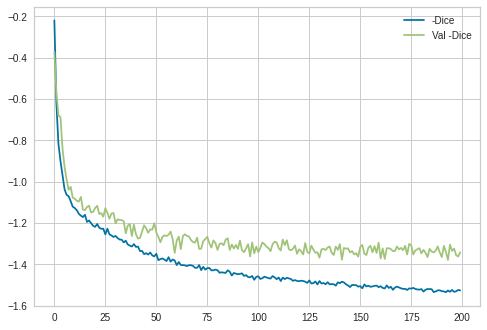

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++
Dice: 0.9879020444808467 +- 0.18885614904120834


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 23s 461ms/step - loss: -0.2573 - iou: 0.0917 - dice_coef: 0.1645 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7696 - val_loss: -0.3302 - val_iou: 0.1187 - val_dice_coef: 0.2115 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9623


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 20s 445ms/step - loss: -0.7398 - iou: 0.2909 - dice_coef: 0.4475 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9614 - val_loss: -0.6132 - val_iou: 0.2353 - val_dice_coef: 0.3779 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9504


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 432ms/step - loss: -0.8968 - iou: 0.3645 - dice_coef: 0.5318 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9681 - val_loss: -0.7479 - val_iou: 0.2947 - val_dice_coef: 0.4533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9631


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 19s 422ms/step - loss: -0.9872 - iou: 0.4084 - dice_coef: 0.5776 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9721 - val_loss: -0.8027 - val_iou: 0.3201 - val_dice_coef: 0.4825 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9607


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 20s 452ms/step - loss: -0.9884 - iou: 0.4091 - dice_coef: 0.5784 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.8831 - val_iou: 0.3611 - val_dice_coef: 0.5220 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9659


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 19s 425ms/step - loss: -1.0539 - iou: 0.4435 - dice_coef: 0.6115 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9736 - val_loss: -0.8725 - val_iou: 0.3570 - val_dice_coef: 0.5155 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9703


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 19s 422ms/step - loss: -1.0647 - iou: 0.4487 - dice_coef: 0.6159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9745 - val_loss: -1.0171 - val_iou: 0.4246 - val_dice_coef: 0.5925 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9710


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 21s 454ms/step - loss: -1.0744 - iou: 0.4529 - dice_coef: 0.6207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9743 - val_loss: -1.0430 - val_iou: 0.4391 - val_dice_coef: 0.6038 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9722


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 19s 422ms/step - loss: -1.1233 - iou: 0.4785 - dice_coef: 0.6446 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9762 - val_loss: -1.0804 - val_iou: 0.4567 - val_dice_coef: 0.6237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9755


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 426ms/step - loss: -1.1204 - iou: 0.4776 - dice_coef: 0.6440 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9763 - val_loss: -1.0587 - val_iou: 0.4504 - val_dice_coef: 0.6083 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9735


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 20s 451ms/step - loss: -1.1688 - iou: 0.5017 - dice_coef: 0.6653 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9778 - val_loss: -1.1009 - val_iou: 0.4680 - val_dice_coef: 0.6329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 19s 422ms/step - loss: -1.1435 - iou: 0.4908 - dice_coef: 0.6551 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -1.0886 - val_iou: 0.4646 - val_dice_coef: 0.6240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9723


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 20s 434ms/step - loss: -1.1625 - iou: 0.5005 - dice_coef: 0.6640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -1.0312 - val_iou: 0.4329 - val_dice_coef: 0.5983 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 20s 443ms/step - loss: -1.1870 - iou: 0.5126 - dice_coef: 0.6741 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -1.0956 - val_iou: 0.4677 - val_dice_coef: 0.6279 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 20s 454ms/step - loss: -1.1912 - iou: 0.5153 - dice_coef: 0.6766 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -1.1499 - val_iou: 0.4930 - val_dice_coef: 0.6569 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 19s 423ms/step - loss: -1.2213 - iou: 0.5302 - dice_coef: 0.6895 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9796 - val_loss: -1.1357 - val_iou: 0.4883 - val_dice_coef: 0.6475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9763


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 19s 423ms/step - loss: -1.2185 - iou: 0.5278 - dice_coef: 0.6881 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9797 - val_loss: -1.1482 - val_iou: 0.4955 - val_dice_coef: 0.6527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 20s 451ms/step - loss: -1.2453 - iou: 0.5438 - dice_coef: 0.7017 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -1.1315 - val_iou: 0.4859 - val_dice_coef: 0.6456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9744


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 19s 421ms/step - loss: -1.2297 - iou: 0.5351 - dice_coef: 0.6943 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -1.1601 - val_iou: 0.4997 - val_dice_coef: 0.6605 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 19s 430ms/step - loss: -1.2594 - iou: 0.5526 - dice_coef: 0.7085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9809 - val_loss: -1.1798 - val_iou: 0.5131 - val_dice_coef: 0.6666 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 20s 445ms/step - loss: -1.2608 - iou: 0.5515 - dice_coef: 0.7085 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -1.1973 - val_iou: 0.5216 - val_dice_coef: 0.6757 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 19s 424ms/step - loss: -1.2830 - iou: 0.5653 - dice_coef: 0.7186 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9817 - val_loss: -1.1734 - val_iou: 0.5075 - val_dice_coef: 0.6659 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 20s 440ms/step - loss: -1.2687 - iou: 0.5578 - dice_coef: 0.7123 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -1.2389 - val_iou: 0.5402 - val_dice_coef: 0.6987 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 20s 439ms/step - loss: -1.2894 - iou: 0.5686 - dice_coef: 0.7226 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -1.1707 - val_iou: 0.5084 - val_dice_coef: 0.6623 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 19s 424ms/step - loss: -1.3011 - iou: 0.5754 - dice_coef: 0.7269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -1.1828 - val_iou: 0.5140 - val_dice_coef: 0.6689 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 20s 444ms/step - loss: -1.3082 - iou: 0.5783 - dice_coef: 0.7299 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -1.2115 - val_iou: 0.5280 - val_dice_coef: 0.6835 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 20s 440ms/step - loss: -1.3108 - iou: 0.5802 - dice_coef: 0.7309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.1982 - val_iou: 0.5228 - val_dice_coef: 0.6753 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 20s 446ms/step - loss: -1.3079 - iou: 0.5777 - dice_coef: 0.7294 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -1.2111 - val_iou: 0.5317 - val_dice_coef: 0.6794 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 19s 423ms/step - loss: -1.3156 - iou: 0.5839 - dice_coef: 0.7334 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.1783 - val_iou: 0.5152 - val_dice_coef: 0.6631 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 20s 435ms/step - loss: -1.3217 - iou: 0.5862 - dice_coef: 0.7356 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -1.2654 - val_iou: 0.5541 - val_dice_coef: 0.7112 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3293 - iou: 0.5903 - dice_coef: 0.7396 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -1.2397 - val_iou: 0.5466 - val_dice_coef: 0.6931 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 19s 423ms/step - loss: -1.3370 - iou: 0.5956 - dice_coef: 0.7433 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2285 - val_iou: 0.5394 - val_dice_coef: 0.6891 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9796


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 20s 442ms/step - loss: -1.3437 - iou: 0.5982 - dice_coef: 0.7460 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2214 - val_iou: 0.5360 - val_dice_coef: 0.6855 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 20s 433ms/step - loss: -1.3521 - iou: 0.6018 - dice_coef: 0.7471 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2531 - val_iou: 0.5508 - val_dice_coef: 0.7023 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3536 - iou: 0.6032 - dice_coef: 0.7496 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2662 - val_iou: 0.5562 - val_dice_coef: 0.7101 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 454ms/step - loss: -1.3505 - iou: 0.6011 - dice_coef: 0.7488 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2796 - val_iou: 0.5628 - val_dice_coef: 0.7168 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 19s 431ms/step - loss: -1.3720 - iou: 0.6144 - dice_coef: 0.7584 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.2631 - val_iou: 0.5570 - val_dice_coef: 0.7061 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 420ms/step - loss: -1.3635 - iou: 0.6101 - dice_coef: 0.7552 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2496 - val_iou: 0.5488 - val_dice_coef: 0.7008 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 20s 454ms/step - loss: -1.3674 - iou: 0.6113 - dice_coef: 0.7555 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.2385 - val_iou: 0.5446 - val_dice_coef: 0.6939 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3672 - iou: 0.6116 - dice_coef: 0.7556 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2583 - val_iou: 0.5559 - val_dice_coef: 0.7024 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 429ms/step - loss: -1.3881 - iou: 0.6169 - dice_coef: 0.7598 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2793 - val_iou: 0.5627 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 20s 450ms/step - loss: -1.3788 - iou: 0.6178 - dice_coef: 0.7609 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2798 - val_iou: 0.5642 - val_dice_coef: 0.7155 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 20s 449ms/step - loss: -1.3643 - iou: 0.6095 - dice_coef: 0.7542 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -1.2840 - val_iou: 0.5658 - val_dice_coef: 0.7182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 427ms/step - loss: -1.3765 - iou: 0.6172 - dice_coef: 0.7599 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -1.2540 - val_iou: 0.5547 - val_dice_coef: 0.6993 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 19s 421ms/step - loss: -1.3795 - iou: 0.6202 - dice_coef: 0.7603 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -1.3064 - val_iou: 0.5783 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 20s 454ms/step - loss: -1.3916 - iou: 0.6264 - dice_coef: 0.7660 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2862 - val_iou: 0.5676 - val_dice_coef: 0.7185 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 19s 422ms/step - loss: -1.3861 - iou: 0.6220 - dice_coef: 0.7625 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -1.2651 - val_iou: 0.5573 - val_dice_coef: 0.7077 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 19s 423ms/step - loss: -1.3989 - iou: 0.6296 - dice_coef: 0.7699 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.3434 - val_iou: 0.5972 - val_dice_coef: 0.7462 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 20s 454ms/step - loss: -1.4096 - iou: 0.6367 - dice_coef: 0.7735 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.2699 - val_iou: 0.5627 - val_dice_coef: 0.7072 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 19s 421ms/step - loss: -1.3978 - iou: 0.6294 - dice_coef: 0.7700 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.2774 - val_iou: 0.5631 - val_dice_coef: 0.7143 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4068 - iou: 0.6345 - dice_coef: 0.7726 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2777 - val_iou: 0.5670 - val_dice_coef: 0.7107 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4025 - iou: 0.6329 - dice_coef: 0.7711 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.3010 - val_iou: 0.5750 - val_dice_coef: 0.7261 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 426ms/step - loss: -1.3988 - iou: 0.6306 - dice_coef: 0.7701 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2865 - val_iou: 0.5676 - val_dice_coef: 0.7190 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4084 - iou: 0.6352 - dice_coef: 0.7738 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.2647 - val_iou: 0.5609 - val_dice_coef: 0.7039 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 20s 450ms/step - loss: -1.4274 - iou: 0.6466 - dice_coef: 0.7809 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.2845 - val_iou: 0.5693 - val_dice_coef: 0.7153 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 21s 459ms/step - loss: -1.4130 - iou: 0.6380 - dice_coef: 0.7750 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.2740 - val_iou: 0.5667 - val_dice_coef: 0.7073 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4104 - iou: 0.6367 - dice_coef: 0.7744 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -1.2996 - val_iou: 0.5754 - val_dice_coef: 0.7241 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 19s 433ms/step - loss: -1.4094 - iou: 0.6348 - dice_coef: 0.7728 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.2965 - val_iou: 0.5743 - val_dice_coef: 0.7222 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4178 - iou: 0.6401 - dice_coef: 0.7776 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2839 - val_iou: 0.5696 - val_dice_coef: 0.7143 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4198 - iou: 0.6419 - dice_coef: 0.7782 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2834 - val_iou: 0.5723 - val_dice_coef: 0.7111 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4332 - iou: 0.6501 - dice_coef: 0.7843 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3255 - val_iou: 0.5883 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4197 - iou: 0.6419 - dice_coef: 0.7778 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3378 - val_iou: 0.5950 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4492 - iou: 0.6587 - dice_coef: 0.7909 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.2630 - val_iou: 0.5608 - val_dice_coef: 0.7022 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 446ms/step - loss: -1.4262 - iou: 0.6452 - dice_coef: 0.7807 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3116 - val_iou: 0.5845 - val_dice_coef: 0.7272 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4290 - iou: 0.6474 - dice_coef: 0.7819 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3376 - val_iou: 0.5946 - val_dice_coef: 0.7430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4327 - iou: 0.6490 - dice_coef: 0.7832 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.3214 - val_iou: 0.5880 - val_dice_coef: 0.7335 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 20s 453ms/step - loss: -1.4434 - iou: 0.6558 - dice_coef: 0.7882 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3087 - val_iou: 0.5836 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4328 - iou: 0.6487 - dice_coef: 0.7843 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -1.2996 - val_iou: 0.5763 - val_dice_coef: 0.7233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4551 - iou: 0.6615 - dice_coef: 0.7936 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3328 - val_iou: 0.5928 - val_dice_coef: 0.7401 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 21s 455ms/step - loss: -1.4454 - iou: 0.6564 - dice_coef: 0.7892 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3258 - val_iou: 0.5932 - val_dice_coef: 0.7326 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 446ms/step - loss: -1.4497 - iou: 0.6594 - dice_coef: 0.7915 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3567 - val_iou: 0.6057 - val_dice_coef: 0.7511 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4543 - iou: 0.6621 - dice_coef: 0.7937 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3364 - val_iou: 0.5941 - val_dice_coef: 0.7423 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4374 - iou: 0.6519 - dice_coef: 0.7862 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.3078 - val_iou: 0.5817 - val_dice_coef: 0.7261 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 20s 453ms/step - loss: -1.4417 - iou: 0.6540 - dice_coef: 0.7873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -1.3055 - val_iou: 0.5819 - val_dice_coef: 0.7236 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4480 - iou: 0.6588 - dice_coef: 0.7897 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3022 - val_iou: 0.5793 - val_dice_coef: 0.7229 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4530 - iou: 0.6613 - dice_coef: 0.7918 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -1.3019 - val_iou: 0.5795 - val_dice_coef: 0.7225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 21s 458ms/step - loss: -1.4590 - iou: 0.6650 - dice_coef: 0.7951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3080 - val_iou: 0.5836 - val_dice_coef: 0.7244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4523 - iou: 0.6600 - dice_coef: 0.7918 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3096 - val_iou: 0.5828 - val_dice_coef: 0.7268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4572 - iou: 0.6636 - dice_coef: 0.7949 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3116 - val_iou: 0.5826 - val_dice_coef: 0.7290 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 20s 451ms/step - loss: -1.4633 - iou: 0.6682 - dice_coef: 0.7967 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3357 - val_iou: 0.5933 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4489 - iou: 0.6589 - dice_coef: 0.7905 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.2966 - val_iou: 0.5774 - val_dice_coef: 0.7192 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4612 - iou: 0.6650 - dice_coef: 0.7949 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3349 - val_iou: 0.5946 - val_dice_coef: 0.7403 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4616 - iou: 0.6660 - dice_coef: 0.7957 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3286 - val_iou: 0.5921 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 21s 457ms/step - loss: -1.4732 - iou: 0.6720 - dice_coef: 0.8008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.2929 - val_iou: 0.5768 - val_dice_coef: 0.7161 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4669 - iou: 0.6691 - dice_coef: 0.7986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.2890 - val_iou: 0.5733 - val_dice_coef: 0.7157 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4562 - iou: 0.6636 - dice_coef: 0.7937 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3087 - val_iou: 0.5838 - val_dice_coef: 0.7249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 20s 451ms/step - loss: -1.4626 - iou: 0.6670 - dice_coef: 0.7956 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.2871 - val_iou: 0.5739 - val_dice_coef: 0.7132 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4809 - iou: 0.6701 - dice_coef: 0.7993 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3489 - val_iou: 0.6013 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4721 - iou: 0.6721 - dice_coef: 0.7997 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3006 - val_iou: 0.5782 - val_dice_coef: 0.7224 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4646 - iou: 0.6675 - dice_coef: 0.7973 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.2920 - val_iou: 0.5766 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4795 - iou: 0.6766 - dice_coef: 0.8037 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.2899 - val_iou: 0.5732 - val_dice_coef: 0.7166 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4774 - iou: 0.6765 - dice_coef: 0.8027 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3437 - val_iou: 0.6008 - val_dice_coef: 0.7429 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4845 - iou: 0.6798 - dice_coef: 0.8062 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.2914 - val_iou: 0.5740 - val_dice_coef: 0.7174 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4746 - iou: 0.6745 - dice_coef: 0.8020 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.2974 - val_iou: 0.5760 - val_dice_coef: 0.7215 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 20s 449ms/step - loss: -1.4785 - iou: 0.6759 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3935 - val_iou: 0.6250 - val_dice_coef: 0.7685 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4820 - iou: 0.6778 - dice_coef: 0.8045 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3276 - val_iou: 0.5942 - val_dice_coef: 0.7334 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 421ms/step - loss: -1.4798 - iou: 0.6770 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.2304 - val_iou: 0.5457 - val_dice_coef: 0.6846 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 21s 457ms/step - loss: -1.4754 - iou: 0.6746 - dice_coef: 0.8014 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3256 - val_iou: 0.5910 - val_dice_coef: 0.7346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4764 - iou: 0.6745 - dice_coef: 0.8028 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3641 - val_iou: 0.6096 - val_dice_coef: 0.7545 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4824 - iou: 0.6784 - dice_coef: 0.8038 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3452 - val_iou: 0.5996 - val_dice_coef: 0.7456 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4796 - iou: 0.6769 - dice_coef: 0.8040 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3300 - val_iou: 0.5921 - val_dice_coef: 0.7379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 20s 452ms/step - loss: -1.4810 - iou: 0.6769 - dice_coef: 0.8026 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3418 - val_iou: 0.5998 - val_dice_coef: 0.7420 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4869 - iou: 0.6800 - dice_coef: 0.8060 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3173 - val_iou: 0.5892 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4786 - iou: 0.6766 - dice_coef: 0.8030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3585 - val_iou: 0.6073 - val_dice_coef: 0.7512 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 21s 457ms/step - loss: -1.4878 - iou: 0.6818 - dice_coef: 0.8068 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3237 - val_iou: 0.5934 - val_dice_coef: 0.7303 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4756 - iou: 0.6745 - dice_coef: 0.8008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3115 - val_iou: 0.5856 - val_dice_coef: 0.7258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4874 - iou: 0.6796 - dice_coef: 0.8069 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3003 - val_iou: 0.5809 - val_dice_coef: 0.7193 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 20s 454ms/step - loss: -1.4860 - iou: 0.6786 - dice_coef: 0.8044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3238 - val_iou: 0.5897 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 422ms/step - loss: -1.4687 - iou: 0.6699 - dice_coef: 0.7983 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3297 - val_iou: 0.5937 - val_dice_coef: 0.7360 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 19s 431ms/step - loss: -1.4956 - iou: 0.6862 - dice_coef: 0.8109 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3608 - val_iou: 0.6089 - val_dice_coef: 0.7519 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 20s 448ms/step - loss: -1.4834 - iou: 0.6787 - dice_coef: 0.8044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3706 - val_iou: 0.6137 - val_dice_coef: 0.7569 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 21s 455ms/step - loss: -1.4882 - iou: 0.6806 - dice_coef: 0.8060 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.2940 - val_iou: 0.5765 - val_dice_coef: 0.7175 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 19s 423ms/step - loss: -1.4811 - iou: 0.6781 - dice_coef: 0.8044 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3305 - val_iou: 0.5925 - val_dice_coef: 0.7379 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5016 - iou: 0.6892 - dice_coef: 0.8124 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3223 - val_iou: 0.5908 - val_dice_coef: 0.7314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 21s 459ms/step - loss: -1.4976 - iou: 0.6868 - dice_coef: 0.8109 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3090 - val_iou: 0.5865 - val_dice_coef: 0.7225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4929 - iou: 0.6848 - dice_coef: 0.8089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3275 - val_iou: 0.5959 - val_dice_coef: 0.7316 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 20s 434ms/step - loss: -1.4930 - iou: 0.6838 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3283 - val_iou: 0.5933 - val_dice_coef: 0.7350 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5079 - iou: 0.6924 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3671 - val_iou: 0.6121 - val_dice_coef: 0.7550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5000 - iou: 0.6900 - dice_coef: 0.8113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3260 - val_iou: 0.5919 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4931 - iou: 0.6856 - dice_coef: 0.8087 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3133 - val_iou: 0.5875 - val_dice_coef: 0.7258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4978 - iou: 0.6867 - dice_coef: 0.8113 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3525 - val_iou: 0.6049 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5017 - iou: 0.6889 - dice_coef: 0.8133 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.2917 - val_iou: 0.5750 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 20s 448ms/step - loss: -1.4931 - iou: 0.6840 - dice_coef: 0.8089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3356 - val_iou: 0.5971 - val_dice_coef: 0.7385 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5028 - iou: 0.6898 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3332 - val_iou: 0.5954 - val_dice_coef: 0.7378 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5011 - iou: 0.6899 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3400 - val_iou: 0.5980 - val_dice_coef: 0.7421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5091 - iou: 0.6940 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3359 - val_iou: 0.5950 - val_dice_coef: 0.7409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5072 - iou: 0.6933 - dice_coef: 0.8136 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3149 - val_iou: 0.5881 - val_dice_coef: 0.7267 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 440ms/step - loss: -1.4935 - iou: 0.6856 - dice_coef: 0.8088 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3297 - val_iou: 0.5946 - val_dice_coef: 0.7351 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4963 - iou: 0.6872 - dice_coef: 0.8110 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3925 - val_iou: 0.6249 - val_dice_coef: 0.7676 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5121 - iou: 0.6950 - dice_coef: 0.8161 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3236 - val_iou: 0.5926 - val_dice_coef: 0.7310 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 19s 431ms/step - loss: -1.5099 - iou: 0.6942 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.2470 - val_iou: 0.5543 - val_dice_coef: 0.6927 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4994 - iou: 0.6885 - dice_coef: 0.8116 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3490 - val_iou: 0.6020 - val_dice_coef: 0.7470 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5072 - iou: 0.6934 - dice_coef: 0.8142 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.2988 - val_iou: 0.5805 - val_dice_coef: 0.7183 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5082 - iou: 0.6930 - dice_coef: 0.8152 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3212 - val_iou: 0.5902 - val_dice_coef: 0.7310 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5209 - iou: 0.6937 - dice_coef: 0.8164 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.2926 - val_iou: 0.5751 - val_dice_coef: 0.7174 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5075 - iou: 0.6937 - dice_coef: 0.8145 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3586 - val_iou: 0.6093 - val_dice_coef: 0.7493 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4957 - iou: 0.6867 - dice_coef: 0.8103 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3180 - val_iou: 0.5921 - val_dice_coef: 0.7259 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 20s 433ms/step - loss: -1.5116 - iou: 0.6957 - dice_coef: 0.8167 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3067 - val_iou: 0.5851 - val_dice_coef: 0.7216 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 20s 452ms/step - loss: -1.5112 - iou: 0.6958 - dice_coef: 0.8168 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3493 - val_iou: 0.6030 - val_dice_coef: 0.7462 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 21s 458ms/step - loss: -1.5173 - iou: 0.6982 - dice_coef: 0.8193 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3791 - val_iou: 0.6197 - val_dice_coef: 0.7595 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5163 - iou: 0.6990 - dice_coef: 0.8191 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3221 - val_iou: 0.5920 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5087 - iou: 0.6944 - dice_coef: 0.8154 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3371 - val_iou: 0.5985 - val_dice_coef: 0.7386 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 21s 471ms/step - loss: -1.5135 - iou: 0.6959 - dice_coef: 0.8169 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3052 - val_iou: 0.5813 - val_dice_coef: 0.7240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 20s 434ms/step - loss: -1.5116 - iou: 0.6952 - dice_coef: 0.8154 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3338 - val_iou: 0.5984 - val_dice_coef: 0.7354 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 20s 446ms/step - loss: -1.5222 - iou: 0.7012 - dice_coef: 0.8206 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3182 - val_iou: 0.5896 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 20s 448ms/step - loss: -1.5050 - iou: 0.6902 - dice_coef: 0.8128 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3120 - val_iou: 0.5872 - val_dice_coef: 0.7248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 19s 431ms/step - loss: -1.5240 - iou: 0.7014 - dice_coef: 0.8213 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3363 - val_iou: 0.5981 - val_dice_coef: 0.7382 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 20s 453ms/step - loss: -1.5258 - iou: 0.7033 - dice_coef: 0.8220 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3322 - val_iou: 0.5964 - val_dice_coef: 0.7358 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5122 - iou: 0.6960 - dice_coef: 0.8162 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3254 - val_iou: 0.5932 - val_dice_coef: 0.7322 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5168 - iou: 0.6985 - dice_coef: 0.8187 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3024 - val_iou: 0.5842 - val_dice_coef: 0.7182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 21s 456ms/step - loss: -1.5349 - iou: 0.7079 - dice_coef: 0.8267 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3632 - val_iou: 0.6097 - val_dice_coef: 0.7536 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5149 - iou: 0.6974 - dice_coef: 0.8180 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3482 - val_iou: 0.6043 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5130 - iou: 0.6970 - dice_coef: 0.8165 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3313 - val_iou: 0.5965 - val_dice_coef: 0.7349 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5292 - iou: 0.7059 - dice_coef: 0.8238 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3346 - val_iou: 0.5981 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 20s 451ms/step - loss: -1.5264 - iou: 0.7034 - dice_coef: 0.8229 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3226 - val_iou: 0.5914 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 20s 438ms/step - loss: -1.5294 - iou: 0.7053 - dice_coef: 0.8237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3377 - val_iou: 0.5975 - val_dice_coef: 0.7402 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5206 - iou: 0.7012 - dice_coef: 0.8197 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3458 - val_iou: 0.6046 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 21s 459ms/step - loss: -1.5282 - iou: 0.7056 - dice_coef: 0.8238 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3390 - val_iou: 0.5966 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5269 - iou: 0.7041 - dice_coef: 0.8222 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3200 - val_iou: 0.5908 - val_dice_coef: 0.7291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5397 - iou: 0.7115 - dice_coef: 0.8288 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3195 - val_iou: 0.5918 - val_dice_coef: 0.7278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 21s 460ms/step - loss: -1.5091 - iou: 0.6948 - dice_coef: 0.8145 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3443 - val_iou: 0.5999 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5263 - iou: 0.7037 - dice_coef: 0.8228 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3378 - val_iou: 0.5969 - val_dice_coef: 0.7409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 20s 438ms/step - loss: -1.5322 - iou: 0.7070 - dice_coef: 0.8258 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3569 - val_iou: 0.6067 - val_dice_coef: 0.7502 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 20s 453ms/step - loss: -1.5308 - iou: 0.7065 - dice_coef: 0.8245 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3479 - val_iou: 0.6049 - val_dice_coef: 0.7431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5317 - iou: 0.7075 - dice_coef: 0.8257 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3317 - val_iou: 0.5975 - val_dice_coef: 0.7342 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 20s 442ms/step - loss: -1.5290 - iou: 0.7050 - dice_coef: 0.8235 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.4220 - val_iou: 0.6411 - val_dice_coef: 0.7809 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9855


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5334 - iou: 0.7082 - dice_coef: 0.8255 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3542 - val_iou: 0.6094 - val_dice_coef: 0.7448 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 21s 461ms/step - loss: -1.5288 - iou: 0.7060 - dice_coef: 0.8231 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3154 - val_iou: 0.5877 - val_dice_coef: 0.7278 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5322 - iou: 0.7064 - dice_coef: 0.8240 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3277 - val_iou: 0.5936 - val_dice_coef: 0.7341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 20s 437ms/step - loss: -1.5369 - iou: 0.7106 - dice_coef: 0.8265 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3395 - val_iou: 0.6008 - val_dice_coef: 0.7387 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5175 - iou: 0.6995 - dice_coef: 0.8189 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3618 - val_iou: 0.6099 - val_dice_coef: 0.7518 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5398 - iou: 0.7115 - dice_coef: 0.8279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3486 - val_iou: 0.6063 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5279 - iou: 0.7067 - dice_coef: 0.8224 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3541 - val_iou: 0.6069 - val_dice_coef: 0.7472 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 20s 440ms/step - loss: -1.5365 - iou: 0.7102 - dice_coef: 0.8264 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3407 - val_iou: 0.5977 - val_dice_coef: 0.7430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5335 - iou: 0.7080 - dice_coef: 0.8256 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3482 - val_iou: 0.6038 - val_dice_coef: 0.7444 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 447ms/step - loss: -1.5413 - iou: 0.7130 - dice_coef: 0.8283 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3586 - val_iou: 0.6073 - val_dice_coef: 0.7514 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 19s 431ms/step - loss: -1.5365 - iou: 0.7099 - dice_coef: 0.8266 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3324 - val_iou: 0.5980 - val_dice_coef: 0.7344 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5271 - iou: 0.7061 - dice_coef: 0.8221 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.2986 - val_iou: 0.5798 - val_dice_coef: 0.7188 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 453ms/step - loss: -1.5408 - iou: 0.7126 - dice_coef: 0.8280 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3158 - val_iou: 0.5876 - val_dice_coef: 0.7282 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5388 - iou: 0.7110 - dice_coef: 0.8273 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3267 - val_iou: 0.5944 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 20s 447ms/step - loss: -1.5313 - iou: 0.7072 - dice_coef: 0.8241 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3333 - val_iou: 0.5959 - val_dice_coef: 0.7374 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5547 - iou: 0.7132 - dice_coef: 0.8291 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -1.3425 - val_iou: 0.5993 - val_dice_coef: 0.7432 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5299 - iou: 0.7061 - dice_coef: 0.8239 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.2948 - val_iou: 0.5772 - val_dice_coef: 0.7176 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 19s 431ms/step - loss: -1.5388 - iou: 0.7121 - dice_coef: 0.8269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3113 - val_iou: 0.5873 - val_dice_coef: 0.7240 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5383 - iou: 0.7112 - dice_coef: 0.8274 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3296 - val_iou: 0.5941 - val_dice_coef: 0.7355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 21s 457ms/step - loss: -1.5445 - iou: 0.7139 - dice_coef: 0.8300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3564 - val_iou: 0.6082 - val_dice_coef: 0.7483 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5439 - iou: 0.7151 - dice_coef: 0.8300 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3445 - val_iou: 0.6015 - val_dice_coef: 0.7430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5391 - iou: 0.7124 - dice_coef: 0.8278 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3562 - val_iou: 0.6098 - val_dice_coef: 0.7463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5399 - iou: 0.7110 - dice_coef: 0.8274 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.2123 - val_iou: 0.5408 - val_dice_coef: 0.6715 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5204 - iou: 0.7008 - dice_coef: 0.8195 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3212 - val_iou: 0.5931 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5499 - iou: 0.7176 - dice_coef: 0.8321 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3260 - val_iou: 0.5936 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 20s 446ms/step - loss: -1.5303 - iou: 0.7064 - dice_coef: 0.8234 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3448 - val_iou: 0.6015 - val_dice_coef: 0.7433 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5352 - iou: 0.7094 - dice_coef: 0.8260 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3523 - val_iou: 0.6047 - val_dice_coef: 0.7476 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5486 - iou: 0.7168 - dice_coef: 0.8325 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3226 - val_iou: 0.5921 - val_dice_coef: 0.7305 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5509 - iou: 0.7188 - dice_coef: 0.8320 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3469 - val_iou: 0.6036 - val_dice_coef: 0.7433 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5359 - iou: 0.7094 - dice_coef: 0.8262 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3522 - val_iou: 0.6065 - val_dice_coef: 0.7457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5562 - iou: 0.7204 - dice_coef: 0.8347 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3412 - val_iou: 0.6004 - val_dice_coef: 0.7408 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 19s 433ms/step - loss: -1.5440 - iou: 0.7150 - dice_coef: 0.8294 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3530 - val_iou: 0.6095 - val_dice_coef: 0.7435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 20s 447ms/step - loss: -1.5360 - iou: 0.7103 - dice_coef: 0.8264 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3436 - val_iou: 0.6023 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5495 - iou: 0.7182 - dice_coef: 0.8314 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3083 - val_iou: 0.5850 - val_dice_coef: 0.7233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-64/Model_Checkpoint/assets


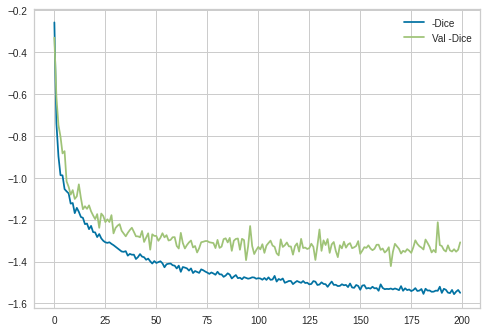

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++
Dice: 0.9878836683047715 +- 0.1982744338831786


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 21s 432ms/step - loss: -0.2375 - iou: 0.0838 - dice_coef: 0.1528 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9367 - val_loss: -0.3675 - val_iou: 0.1332 - val_dice_coef: 0.2343 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9025


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 2/200
46/46 [==============================] - 21s 457ms/step - loss: -0.5410 - iou: 0.2034 - dice_coef: 0.3364 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9375 - val_loss: -0.4654 - val_iou: 0.1721 - val_dice_coef: 0.2934 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9447


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 3/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7903 - iou: 0.3140 - dice_coef: 0.4754 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9615 - val_loss: -0.1682 - val_iou: 0.0584 - val_dice_coef: 0.1098 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9673


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 4/200
46/46 [==============================] - 19s 426ms/step - loss: -0.9253 - iou: 0.3788 - dice_coef: 0.5469 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9696 - val_loss: -0.5504 - val_iou: 0.2083 - val_dice_coef: 0.3421 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9695


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 5/200
46/46 [==============================] - 21s 464ms/step - loss: -1.0116 - iou: 0.4206 - dice_coef: 0.5896 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9721 - val_loss: -0.6118 - val_iou: 0.2344 - val_dice_coef: 0.3774 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9714


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 6/200
46/46 [==============================] - 20s 452ms/step - loss: -1.0530 - iou: 0.4410 - dice_coef: 0.6097 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9740 - val_loss: -0.8270 - val_iou: 0.3334 - val_dice_coef: 0.4936 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9703


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 7/200
46/46 [==============================] - 20s 433ms/step - loss: -1.0822 - iou: 0.4573 - dice_coef: 0.6250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.8668 - val_iou: 0.3532 - val_dice_coef: 0.5136 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9738


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 8/200
46/46 [==============================] - 19s 426ms/step - loss: -1.1041 - iou: 0.4669 - dice_coef: 0.6347 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9756 - val_loss: -1.0122 - val_iou: 0.4240 - val_dice_coef: 0.5882 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 9/200
46/46 [==============================] - 21s 458ms/step - loss: -1.1288 - iou: 0.4814 - dice_coef: 0.6471 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -1.0615 - val_iou: 0.4497 - val_dice_coef: 0.6118 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9756


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 10/200
46/46 [==============================] - 19s 427ms/step - loss: -1.1410 - iou: 0.4875 - dice_coef: 0.6527 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -1.0711 - val_iou: 0.4524 - val_dice_coef: 0.6187 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 11/200
46/46 [==============================] - 19s 429ms/step - loss: -1.1348 - iou: 0.4843 - dice_coef: 0.6493 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -1.0674 - val_iou: 0.4532 - val_dice_coef: 0.6142 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9744


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 12/200
46/46 [==============================] - 21s 455ms/step - loss: -1.1664 - iou: 0.5003 - dice_coef: 0.6640 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9780 - val_loss: -1.1060 - val_iou: 0.4704 - val_dice_coef: 0.6357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9727


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 13/200
46/46 [==============================] - 19s 426ms/step - loss: -1.1907 - iou: 0.5149 - dice_coef: 0.6773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -1.0936 - val_iou: 0.4672 - val_dice_coef: 0.6265 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9742


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 14/200
46/46 [==============================] - 20s 439ms/step - loss: -1.2052 - iou: 0.5226 - dice_coef: 0.6836 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9792 - val_loss: -1.1152 - val_iou: 0.4790 - val_dice_coef: 0.6362 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 15/200
46/46 [==============================] - 20s 446ms/step - loss: -1.2031 - iou: 0.5209 - dice_coef: 0.6818 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9790 - val_loss: -1.1309 - val_iou: 0.4882 - val_dice_coef: 0.6427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 16/200
46/46 [==============================] - 19s 429ms/step - loss: -1.2300 - iou: 0.5358 - dice_coef: 0.6955 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -1.1330 - val_iou: 0.4865 - val_dice_coef: 0.6465 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9765


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 17/200
46/46 [==============================] - 20s 447ms/step - loss: -1.2503 - iou: 0.5470 - dice_coef: 0.7047 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -1.1512 - val_iou: 0.4975 - val_dice_coef: 0.6537 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 18/200
46/46 [==============================] - 20s 443ms/step - loss: -1.2393 - iou: 0.5411 - dice_coef: 0.6991 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -1.1833 - val_iou: 0.5136 - val_dice_coef: 0.6697 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 19/200
46/46 [==============================] - 19s 426ms/step - loss: -1.2489 - iou: 0.5461 - dice_coef: 0.7029 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -1.2199 - val_iou: 0.5296 - val_dice_coef: 0.6904 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 20/200
46/46 [==============================] - 20s 454ms/step - loss: -1.2682 - iou: 0.5562 - dice_coef: 0.7117 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -1.1563 - val_iou: 0.5003 - val_dice_coef: 0.6560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 21/200
46/46 [==============================] - 20s 444ms/step - loss: -1.2787 - iou: 0.5623 - dice_coef: 0.7170 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -1.1873 - val_iou: 0.5165 - val_dice_coef: 0.6707 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 22/200
46/46 [==============================] - 20s 445ms/step - loss: -1.2837 - iou: 0.5645 - dice_coef: 0.7186 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -1.1872 - val_iou: 0.5159 - val_dice_coef: 0.6713 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 23/200
46/46 [==============================] - 19s 429ms/step - loss: -1.2933 - iou: 0.5702 - dice_coef: 0.7226 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -1.1993 - val_iou: 0.5243 - val_dice_coef: 0.6750 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 24/200
46/46 [==============================] - 20s 451ms/step - loss: -1.3081 - iou: 0.5782 - dice_coef: 0.7293 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9823 - val_loss: -1.2043 - val_iou: 0.5220 - val_dice_coef: 0.6823 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 25/200
46/46 [==============================] - 20s 440ms/step - loss: -1.3139 - iou: 0.5824 - dice_coef: 0.7326 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -1.2213 - val_iou: 0.5318 - val_dice_coef: 0.6896 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 26/200
46/46 [==============================] - 19s 428ms/step - loss: -1.3197 - iou: 0.5846 - dice_coef: 0.7348 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -1.2321 - val_iou: 0.5369 - val_dice_coef: 0.6953 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9781


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 27/200
46/46 [==============================] - 21s 459ms/step - loss: -1.3270 - iou: 0.5889 - dice_coef: 0.7384 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -1.2181 - val_iou: 0.5327 - val_dice_coef: 0.6854 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 28/200
46/46 [==============================] - 19s 426ms/step - loss: -1.3211 - iou: 0.5859 - dice_coef: 0.7356 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -1.2218 - val_iou: 0.5355 - val_dice_coef: 0.6863 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 29/200
46/46 [==============================] - 20s 434ms/step - loss: -1.3344 - iou: 0.5930 - dice_coef: 0.7414 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -1.1963 - val_iou: 0.5237 - val_dice_coef: 0.6726 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 30/200
46/46 [==============================] - 21s 460ms/step - loss: -1.3465 - iou: 0.5936 - dice_coef: 0.7418 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -1.2454 - val_iou: 0.5447 - val_dice_coef: 0.7008 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 31/200
46/46 [==============================] - 19s 427ms/step - loss: -1.3587 - iou: 0.6063 - dice_coef: 0.7524 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.2703 - val_iou: 0.5592 - val_dice_coef: 0.7111 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 32/200
46/46 [==============================] - 20s 436ms/step - loss: -1.3612 - iou: 0.6080 - dice_coef: 0.7530 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.2656 - val_iou: 0.5557 - val_dice_coef: 0.7099 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 33/200
46/46 [==============================] - 20s 447ms/step - loss: -1.3548 - iou: 0.6052 - dice_coef: 0.7490 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -1.2070 - val_iou: 0.5274 - val_dice_coef: 0.6796 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 34/200
46/46 [==============================] - 21s 456ms/step - loss: -1.3620 - iou: 0.6083 - dice_coef: 0.7523 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -1.2139 - val_iou: 0.5330 - val_dice_coef: 0.6810 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 35/200
46/46 [==============================] - 19s 428ms/step - loss: -1.3672 - iou: 0.6114 - dice_coef: 0.7548 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.2577 - val_iou: 0.5556 - val_dice_coef: 0.7021 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 36/200
46/46 [==============================] - 20s 432ms/step - loss: -1.3682 - iou: 0.6133 - dice_coef: 0.7566 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -1.2337 - val_iou: 0.5424 - val_dice_coef: 0.6913 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 37/200
46/46 [==============================] - 20s 452ms/step - loss: -1.3729 - iou: 0.6155 - dice_coef: 0.7583 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -1.2531 - val_iou: 0.5511 - val_dice_coef: 0.7019 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 38/200
46/46 [==============================] - 19s 426ms/step - loss: -1.3739 - iou: 0.6154 - dice_coef: 0.7592 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -1.2496 - val_iou: 0.5520 - val_dice_coef: 0.6976 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 39/200
46/46 [==============================] - 20s 439ms/step - loss: -1.3897 - iou: 0.6251 - dice_coef: 0.7658 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2802 - val_iou: 0.5652 - val_dice_coef: 0.7149 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 40/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4002 - iou: 0.6310 - dice_coef: 0.7688 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2858 - val_iou: 0.5684 - val_dice_coef: 0.7174 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 41/200
46/46 [==============================] - 19s 425ms/step - loss: -1.3969 - iou: 0.6285 - dice_coef: 0.7690 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -1.2802 - val_iou: 0.5681 - val_dice_coef: 0.7121 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 42/200
46/46 [==============================] - 20s 446ms/step - loss: -1.3926 - iou: 0.6261 - dice_coef: 0.7665 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -1.3289 - val_iou: 0.5884 - val_dice_coef: 0.7404 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 43/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4122 - iou: 0.6377 - dice_coef: 0.7748 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3166 - val_iou: 0.5833 - val_dice_coef: 0.7333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 44/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4029 - iou: 0.6325 - dice_coef: 0.7718 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -1.2719 - val_iou: 0.5637 - val_dice_coef: 0.7082 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 45/200
46/46 [==============================] - 20s 453ms/step - loss: -1.4045 - iou: 0.6336 - dice_coef: 0.7715 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -1.3145 - val_iou: 0.5816 - val_dice_coef: 0.7329 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 46/200
46/46 [==============================] - 19s 431ms/step - loss: -1.3996 - iou: 0.6315 - dice_coef: 0.7698 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -1.2737 - val_iou: 0.5619 - val_dice_coef: 0.7118 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 47/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4301 - iou: 0.6484 - dice_coef: 0.7820 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -1.2880 - val_iou: 0.5723 - val_dice_coef: 0.7158 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 48/200
46/46 [==============================] - 21s 455ms/step - loss: -1.4118 - iou: 0.6384 - dice_coef: 0.7751 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -1.3320 - val_iou: 0.5913 - val_dice_coef: 0.7407 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 49/200
46/46 [==============================] - 20s 450ms/step - loss: -1.4303 - iou: 0.6476 - dice_coef: 0.7824 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3091 - val_iou: 0.5798 - val_dice_coef: 0.7293 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 50/200
46/46 [==============================] - 20s 436ms/step - loss: -1.4222 - iou: 0.6434 - dice_coef: 0.7795 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -1.2851 - val_iou: 0.5702 - val_dice_coef: 0.7149 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 51/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4291 - iou: 0.6469 - dice_coef: 0.7813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -1.3185 - val_iou: 0.5860 - val_dice_coef: 0.7325 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 52/200
46/46 [==============================] - 21s 456ms/step - loss: -1.4273 - iou: 0.6454 - dice_coef: 0.7813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.3116 - val_iou: 0.5839 - val_dice_coef: 0.7277 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 53/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4360 - iou: 0.6520 - dice_coef: 0.7850 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3182 - val_iou: 0.5844 - val_dice_coef: 0.7338 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 54/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4256 - iou: 0.6450 - dice_coef: 0.7808 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -1.2787 - val_iou: 0.5671 - val_dice_coef: 0.7115 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 55/200
46/46 [==============================] - 21s 457ms/step - loss: -1.4471 - iou: 0.6567 - dice_coef: 0.7900 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.2750 - val_iou: 0.5672 - val_dice_coef: 0.7078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 56/200
46/46 [==============================] - 19s 430ms/step - loss: -1.4416 - iou: 0.6551 - dice_coef: 0.7867 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.2840 - val_iou: 0.5712 - val_dice_coef: 0.7128 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 57/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4241 - iou: 0.6447 - dice_coef: 0.7790 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -1.3099 - val_iou: 0.5805 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 58/200
46/46 [==============================] - 20s 450ms/step - loss: -1.4435 - iou: 0.6559 - dice_coef: 0.7881 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.3294 - val_iou: 0.5904 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 59/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4388 - iou: 0.6528 - dice_coef: 0.7870 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.3239 - val_iou: 0.5867 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 60/200
46/46 [==============================] - 20s 445ms/step - loss: -1.4540 - iou: 0.6619 - dice_coef: 0.7910 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -1.2729 - val_iou: 0.5642 - val_dice_coef: 0.7087 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 61/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4411 - iou: 0.6542 - dice_coef: 0.7871 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9861 - val_loss: -1.2912 - val_iou: 0.5732 - val_dice_coef: 0.7181 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 62/200
46/46 [==============================] - 21s 456ms/step - loss: -1.4425 - iou: 0.6538 - dice_coef: 0.7876 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -1.2859 - val_iou: 0.5712 - val_dice_coef: 0.7147 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 63/200
46/46 [==============================] - 19s 428ms/step - loss: -1.4618 - iou: 0.6661 - dice_coef: 0.7954 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.3073 - val_iou: 0.5840 - val_dice_coef: 0.7233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 64/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4623 - iou: 0.6671 - dice_coef: 0.7962 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -1.3147 - val_iou: 0.5852 - val_dice_coef: 0.7295 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 65/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4623 - iou: 0.6661 - dice_coef: 0.7959 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.2962 - val_iou: 0.5788 - val_dice_coef: 0.7174 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 66/200
46/46 [==============================] - 19s 424ms/step - loss: -1.4560 - iou: 0.6632 - dice_coef: 0.7942 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -1.3071 - val_iou: 0.5819 - val_dice_coef: 0.7253 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 67/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4687 - iou: 0.6702 - dice_coef: 0.7991 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3374 - val_iou: 0.5952 - val_dice_coef: 0.7421 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 68/200
46/46 [==============================] - 20s 438ms/step - loss: -1.4590 - iou: 0.6657 - dice_coef: 0.7947 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.2984 - val_iou: 0.5783 - val_dice_coef: 0.7201 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 69/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4716 - iou: 0.6715 - dice_coef: 0.7997 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.2820 - val_iou: 0.5704 - val_dice_coef: 0.7116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 70/200
46/46 [==============================] - 21s 457ms/step - loss: -1.4657 - iou: 0.6682 - dice_coef: 0.7978 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3025 - val_iou: 0.5799 - val_dice_coef: 0.7225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 71/200
46/46 [==============================] - 20s 439ms/step - loss: -1.4677 - iou: 0.6703 - dice_coef: 0.7982 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3157 - val_iou: 0.5845 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 72/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4682 - iou: 0.6704 - dice_coef: 0.7987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3030 - val_iou: 0.5807 - val_dice_coef: 0.7223 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 73/200
46/46 [==============================] - 21s 456ms/step - loss: -1.4648 - iou: 0.6679 - dice_coef: 0.7959 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -1.2991 - val_iou: 0.5785 - val_dice_coef: 0.7206 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 74/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4689 - iou: 0.6710 - dice_coef: 0.7986 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3220 - val_iou: 0.5893 - val_dice_coef: 0.7327 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 75/200
46/46 [==============================] - 20s 437ms/step - loss: -1.4666 - iou: 0.6695 - dice_coef: 0.7961 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -1.3053 - val_iou: 0.5788 - val_dice_coef: 0.7265 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 76/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4781 - iou: 0.6755 - dice_coef: 0.8027 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.2968 - val_iou: 0.5773 - val_dice_coef: 0.7195 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 77/200
46/46 [==============================] - 21s 462ms/step - loss: -1.4800 - iou: 0.6702 - dice_coef: 0.8003 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3089 - val_iou: 0.5835 - val_dice_coef: 0.7254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 78/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4746 - iou: 0.6734 - dice_coef: 0.8005 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -1.3315 - val_iou: 0.5935 - val_dice_coef: 0.7381 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 79/200
46/46 [==============================] - 19s 425ms/step - loss: -1.4745 - iou: 0.6735 - dice_coef: 0.8013 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -1.3336 - val_iou: 0.5942 - val_dice_coef: 0.7395 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 80/200
46/46 [==============================] - 21s 457ms/step - loss: -1.4825 - iou: 0.6771 - dice_coef: 0.8043 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3036 - val_iou: 0.5803 - val_dice_coef: 0.7234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 81/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4857 - iou: 0.6802 - dice_coef: 0.8058 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3025 - val_iou: 0.5817 - val_dice_coef: 0.7208 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 82/200
46/46 [==============================] - 19s 432ms/step - loss: -1.4803 - iou: 0.6771 - dice_coef: 0.8043 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.3303 - val_iou: 0.5938 - val_dice_coef: 0.7365 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 83/200
46/46 [==============================] - 20s 451ms/step - loss: -1.4841 - iou: 0.6803 - dice_coef: 0.8045 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.3172 - val_iou: 0.5842 - val_dice_coef: 0.7331 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 84/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4929 - iou: 0.6846 - dice_coef: 0.8087 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3032 - val_iou: 0.5818 - val_dice_coef: 0.7214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 85/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4820 - iou: 0.6784 - dice_coef: 0.8042 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3208 - val_iou: 0.5894 - val_dice_coef: 0.7314 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 86/200
46/46 [==============================] - 20s 442ms/step - loss: -1.4842 - iou: 0.6779 - dice_coef: 0.8053 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -1.2891 - val_iou: 0.5745 - val_dice_coef: 0.7146 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 87/200
46/46 [==============================] - 19s 426ms/step - loss: -1.4864 - iou: 0.6804 - dice_coef: 0.8062 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3037 - val_iou: 0.5832 - val_dice_coef: 0.7205 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 88/200
46/46 [==============================] - 20s 448ms/step - loss: -1.4952 - iou: 0.6866 - dice_coef: 0.8102 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.2939 - val_iou: 0.5759 - val_dice_coef: 0.7180 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 89/200
46/46 [==============================] - 20s 444ms/step - loss: -1.4911 - iou: 0.6829 - dice_coef: 0.8078 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -1.3424 - val_iou: 0.5979 - val_dice_coef: 0.7446 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 90/200
46/46 [==============================] - 20s 447ms/step - loss: -1.4999 - iou: 0.6889 - dice_coef: 0.8121 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3487 - val_iou: 0.6022 - val_dice_coef: 0.7465 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 91/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5026 - iou: 0.6900 - dice_coef: 0.8125 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3064 - val_iou: 0.5832 - val_dice_coef: 0.7232 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 92/200
46/46 [==============================] - 20s 443ms/step - loss: -1.4833 - iou: 0.6798 - dice_coef: 0.8040 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -1.2848 - val_iou: 0.5723 - val_dice_coef: 0.7125 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 93/200
46/46 [==============================] - 20s 441ms/step - loss: -1.4932 - iou: 0.6858 - dice_coef: 0.8095 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3378 - val_iou: 0.5968 - val_dice_coef: 0.7411 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 94/200
46/46 [==============================] - 19s 429ms/step - loss: -1.4949 - iou: 0.6856 - dice_coef: 0.8084 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -1.3155 - val_iou: 0.5871 - val_dice_coef: 0.7284 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 95/200
46/46 [==============================] - 20s 452ms/step - loss: -1.4917 - iou: 0.6837 - dice_coef: 0.8078 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -1.3146 - val_iou: 0.5852 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 96/200
46/46 [==============================] - 20s 434ms/step - loss: -1.5092 - iou: 0.6940 - dice_coef: 0.8159 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.2993 - val_iou: 0.5779 - val_dice_coef: 0.7214 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 97/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5032 - iou: 0.6892 - dice_coef: 0.8125 - sensitivity: 0.9971 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3256 - val_iou: 0.5942 - val_dice_coef: 0.7315 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 98/200
46/46 [==============================] - 21s 459ms/step - loss: -1.4942 - iou: 0.6857 - dice_coef: 0.8097 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3340 - val_iou: 0.5963 - val_dice_coef: 0.7377 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 99/200
46/46 [==============================] - 19s 427ms/step - loss: -1.4971 - iou: 0.6865 - dice_coef: 0.8098 - sensitivity: 0.9951 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.3014 - val_iou: 0.5823 - val_dice_coef: 0.7191 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 100/200
46/46 [==============================] - 20s 437ms/step - loss: -1.5000 - iou: 0.6896 - dice_coef: 0.8124 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3231 - val_iou: 0.5951 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 101/200
46/46 [==============================] - 20s 451ms/step - loss: -1.4992 - iou: 0.6883 - dice_coef: 0.8113 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3514 - val_iou: 0.6023 - val_dice_coef: 0.7491 - val_sensitivity: 0.9915 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 102/200
46/46 [==============================] - 21s 456ms/step - loss: -1.4991 - iou: 0.6890 - dice_coef: 0.8112 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -1.2869 - val_iou: 0.5754 - val_dice_coef: 0.7115 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 103/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5122 - iou: 0.6957 - dice_coef: 0.8170 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.3124 - val_iou: 0.5871 - val_dice_coef: 0.7254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 104/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5079 - iou: 0.6933 - dice_coef: 0.8155 - sensitivity: 0.9986 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3349 - val_iou: 0.5969 - val_dice_coef: 0.7380 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 105/200
46/46 [==============================] - 21s 457ms/step - loss: -1.5044 - iou: 0.6921 - dice_coef: 0.8135 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3003 - val_iou: 0.5796 - val_dice_coef: 0.7207 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 106/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5020 - iou: 0.6909 - dice_coef: 0.8123 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -1.3247 - val_iou: 0.5949 - val_dice_coef: 0.7298 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 107/200
46/46 [==============================] - 20s 434ms/step - loss: -1.5093 - iou: 0.6935 - dice_coef: 0.8165 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3034 - val_iou: 0.5846 - val_dice_coef: 0.7189 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 108/200
46/46 [==============================] - 20s 449ms/step - loss: -1.5022 - iou: 0.6903 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -1.3102 - val_iou: 0.5844 - val_dice_coef: 0.7258 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 109/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5089 - iou: 0.6927 - dice_coef: 0.8149 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3785 - val_iou: 0.6178 - val_dice_coef: 0.7607 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 110/200
46/46 [==============================] - 20s 442ms/step - loss: -1.5233 - iou: 0.7025 - dice_coef: 0.8211 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3646 - val_iou: 0.6121 - val_dice_coef: 0.7525 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 111/200
46/46 [==============================] - 20s 439ms/step - loss: -1.5100 - iou: 0.6940 - dice_coef: 0.8167 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3528 - val_iou: 0.6051 - val_dice_coef: 0.7478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 112/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5215 - iou: 0.7011 - dice_coef: 0.8214 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3333 - val_iou: 0.5957 - val_dice_coef: 0.7376 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 113/200
46/46 [==============================] - 20s 448ms/step - loss: -1.5158 - iou: 0.6967 - dice_coef: 0.8177 - sensitivity: 0.9993 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3159 - val_iou: 0.5897 - val_dice_coef: 0.7262 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 114/200
46/46 [==============================] - 20s 434ms/step - loss: -1.5137 - iou: 0.6969 - dice_coef: 0.8175 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -1.3161 - val_iou: 0.5897 - val_dice_coef: 0.7264 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 115/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5155 - iou: 0.6984 - dice_coef: 0.8178 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3075 - val_iou: 0.5879 - val_dice_coef: 0.7196 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 116/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5168 - iou: 0.6982 - dice_coef: 0.8179 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -1.2936 - val_iou: 0.5782 - val_dice_coef: 0.7154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 117/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5276 - iou: 0.7038 - dice_coef: 0.8237 - sensitivity: 0.9964 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3099 - val_iou: 0.5862 - val_dice_coef: 0.7237 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 118/200
46/46 [==============================] - 20s 439ms/step - loss: -1.5135 - iou: 0.6971 - dice_coef: 0.8162 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -1.3266 - val_iou: 0.5946 - val_dice_coef: 0.7320 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 119/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5228 - iou: 0.7020 - dice_coef: 0.8208 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3250 - val_iou: 0.5899 - val_dice_coef: 0.7351 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 120/200
46/46 [==============================] - 20s 449ms/step - loss: -1.5233 - iou: 0.7022 - dice_coef: 0.8219 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3197 - val_iou: 0.5920 - val_dice_coef: 0.7277 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 121/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5238 - iou: 0.7032 - dice_coef: 0.8213 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3061 - val_iou: 0.5853 - val_dice_coef: 0.7208 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 122/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5233 - iou: 0.7030 - dice_coef: 0.8214 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3217 - val_iou: 0.5895 - val_dice_coef: 0.7323 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 123/200
46/46 [==============================] - 21s 459ms/step - loss: -1.5281 - iou: 0.7047 - dice_coef: 0.8234 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3335 - val_iou: 0.5963 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 124/200
46/46 [==============================] - 20s 433ms/step - loss: -1.5346 - iou: 0.7008 - dice_coef: 0.8195 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3084 - val_iou: 0.5866 - val_dice_coef: 0.7217 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 125/200
46/46 [==============================] - 20s 435ms/step - loss: -1.5280 - iou: 0.7049 - dice_coef: 0.8232 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -1.3138 - val_iou: 0.5845 - val_dice_coef: 0.7292 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 126/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5275 - iou: 0.7041 - dice_coef: 0.8221 - sensitivity: 0.9935 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3523 - val_iou: 0.6044 - val_dice_coef: 0.7479 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 127/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5275 - iou: 0.7055 - dice_coef: 0.8227 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.2968 - val_iou: 0.5800 - val_dice_coef: 0.7167 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 128/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5198 - iou: 0.7001 - dice_coef: 0.8190 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -1.3295 - val_iou: 0.5946 - val_dice_coef: 0.7349 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 129/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5340 - iou: 0.7090 - dice_coef: 0.8255 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3241 - val_iou: 0.5951 - val_dice_coef: 0.7290 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 130/200
46/46 [==============================] - 21s 456ms/step - loss: -1.5262 - iou: 0.7044 - dice_coef: 0.8228 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.3299 - val_iou: 0.5938 - val_dice_coef: 0.7361 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 131/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5387 - iou: 0.7114 - dice_coef: 0.8277 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3157 - val_iou: 0.5907 - val_dice_coef: 0.7249 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 132/200
46/46 [==============================] - 20s 435ms/step - loss: -1.5310 - iou: 0.7069 - dice_coef: 0.8242 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3560 - val_iou: 0.6082 - val_dice_coef: 0.7478 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 133/200
46/46 [==============================] - 20s 449ms/step - loss: -1.5433 - iou: 0.7146 - dice_coef: 0.8295 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3185 - val_iou: 0.5885 - val_dice_coef: 0.7300 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 134/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5304 - iou: 0.7066 - dice_coef: 0.8248 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3276 - val_iou: 0.5940 - val_dice_coef: 0.7335 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 135/200
46/46 [==============================] - 20s 446ms/step - loss: -1.5258 - iou: 0.7047 - dice_coef: 0.8219 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -1.2895 - val_iou: 0.5750 - val_dice_coef: 0.7145 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 136/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5324 - iou: 0.7076 - dice_coef: 0.8259 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3141 - val_iou: 0.5881 - val_dice_coef: 0.7261 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 137/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5353 - iou: 0.7112 - dice_coef: 0.8264 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3214 - val_iou: 0.5902 - val_dice_coef: 0.7313 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 138/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5318 - iou: 0.7077 - dice_coef: 0.8251 - sensitivity: 0.9939 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3621 - val_iou: 0.6092 - val_dice_coef: 0.7529 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 139/200
46/46 [==============================] - 20s 434ms/step - loss: -1.5354 - iou: 0.7103 - dice_coef: 0.8260 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3770 - val_iou: 0.6170 - val_dice_coef: 0.7599 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 140/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5344 - iou: 0.7089 - dice_coef: 0.8254 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3112 - val_iou: 0.5857 - val_dice_coef: 0.7255 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 141/200
46/46 [==============================] - 20s 453ms/step - loss: -1.5347 - iou: 0.7100 - dice_coef: 0.8259 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3021 - val_iou: 0.5827 - val_dice_coef: 0.7194 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 142/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5421 - iou: 0.7140 - dice_coef: 0.8289 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3623 - val_iou: 0.6107 - val_dice_coef: 0.7516 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 143/200
46/46 [==============================] - 20s 433ms/step - loss: -1.5416 - iou: 0.7135 - dice_coef: 0.8285 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3297 - val_iou: 0.5942 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 144/200
46/46 [==============================] - 20s 452ms/step - loss: -1.5320 - iou: 0.7078 - dice_coef: 0.8250 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3161 - val_iou: 0.5880 - val_dice_coef: 0.7281 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 145/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5405 - iou: 0.7135 - dice_coef: 0.8276 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -1.3520 - val_iou: 0.6048 - val_dice_coef: 0.7471 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 146/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5432 - iou: 0.7144 - dice_coef: 0.8299 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.2939 - val_iou: 0.5768 - val_dice_coef: 0.7171 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 147/200
46/46 [==============================] - 19s 426ms/step - loss: -1.5379 - iou: 0.7118 - dice_coef: 0.8275 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3212 - val_iou: 0.5929 - val_dice_coef: 0.7283 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 148/200
46/46 [==============================] - 21s 457ms/step - loss: -1.5377 - iou: 0.7114 - dice_coef: 0.8271 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3567 - val_iou: 0.6073 - val_dice_coef: 0.7494 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 149/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5497 - iou: 0.7181 - dice_coef: 0.8313 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3412 - val_iou: 0.5985 - val_dice_coef: 0.7427 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 150/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5395 - iou: 0.7124 - dice_coef: 0.8277 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -1.3093 - val_iou: 0.5860 - val_dice_coef: 0.7233 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 151/200
46/46 [==============================] - 20s 448ms/step - loss: -1.5339 - iou: 0.7085 - dice_coef: 0.8255 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -1.3659 - val_iou: 0.6108 - val_dice_coef: 0.7551 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 152/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5436 - iou: 0.7148 - dice_coef: 0.8293 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3324 - val_iou: 0.5941 - val_dice_coef: 0.7383 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 153/200
46/46 [==============================] - 20s 442ms/step - loss: -1.5461 - iou: 0.7151 - dice_coef: 0.8303 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3466 - val_iou: 0.6002 - val_dice_coef: 0.7465 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 154/200
46/46 [==============================] - 20s 442ms/step - loss: -1.5440 - iou: 0.7137 - dice_coef: 0.8295 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3275 - val_iou: 0.5925 - val_dice_coef: 0.7351 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 155/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5449 - iou: 0.7146 - dice_coef: 0.8303 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -1.3486 - val_iou: 0.6032 - val_dice_coef: 0.7454 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 156/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5478 - iou: 0.7175 - dice_coef: 0.8306 - sensitivity: 0.9939 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3181 - val_iou: 0.5884 - val_dice_coef: 0.7298 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 157/200
46/46 [==============================] - 20s 448ms/step - loss: -1.5493 - iou: 0.7186 - dice_coef: 0.8315 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3094 - val_iou: 0.5854 - val_dice_coef: 0.7239 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 158/200
46/46 [==============================] - 20s 450ms/step - loss: -1.5476 - iou: 0.7165 - dice_coef: 0.8313 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3314 - val_iou: 0.5945 - val_dice_coef: 0.7369 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 159/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5494 - iou: 0.7171 - dice_coef: 0.8311 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3374 - val_iou: 0.5993 - val_dice_coef: 0.7381 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 160/200
46/46 [==============================] - 20s 441ms/step - loss: -1.5459 - iou: 0.7147 - dice_coef: 0.8305 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -1.3197 - val_iou: 0.5909 - val_dice_coef: 0.7287 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 161/200
46/46 [==============================] - 20s 440ms/step - loss: -1.5502 - iou: 0.7182 - dice_coef: 0.8322 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3220 - val_iou: 0.5920 - val_dice_coef: 0.7300 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 162/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5500 - iou: 0.7180 - dice_coef: 0.8320 - sensitivity: 0.9944 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3212 - val_iou: 0.5908 - val_dice_coef: 0.7304 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 163/200
46/46 [==============================] - 20s 448ms/step - loss: -1.5541 - iou: 0.7218 - dice_coef: 0.8332 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3140 - val_iou: 0.5883 - val_dice_coef: 0.7257 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 164/200
46/46 [==============================] - 20s 432ms/step - loss: -1.5565 - iou: 0.7224 - dice_coef: 0.8342 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -1.3080 - val_iou: 0.5848 - val_dice_coef: 0.7232 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 165/200
46/46 [==============================] - 19s 424ms/step - loss: -1.5527 - iou: 0.7191 - dice_coef: 0.8332 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3424 - val_iou: 0.5979 - val_dice_coef: 0.7445 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 166/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5554 - iou: 0.7216 - dice_coef: 0.8344 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3462 - val_iou: 0.6001 - val_dice_coef: 0.7460 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 167/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5495 - iou: 0.7188 - dice_coef: 0.8319 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3166 - val_iou: 0.5893 - val_dice_coef: 0.7273 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 168/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5613 - iou: 0.7244 - dice_coef: 0.8371 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -1.3391 - val_iou: 0.5990 - val_dice_coef: 0.7401 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 169/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5557 - iou: 0.7201 - dice_coef: 0.8334 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -1.3423 - val_iou: 0.5997 - val_dice_coef: 0.7426 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 170/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5516 - iou: 0.7189 - dice_coef: 0.8327 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3137 - val_iou: 0.5882 - val_dice_coef: 0.7255 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 171/200
46/46 [==============================] - 20s 442ms/step - loss: -1.5688 - iou: 0.7221 - dice_coef: 0.8359 - sensitivity: 0.9939 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -1.3665 - val_iou: 0.6121 - val_dice_coef: 0.7545 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 172/200
46/46 [==============================] - 20s 445ms/step - loss: -1.5552 - iou: 0.7214 - dice_coef: 0.8349 - sensitivity: 0.9939 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3767 - val_iou: 0.6184 - val_dice_coef: 0.7583 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 173/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5636 - iou: 0.7265 - dice_coef: 0.8380 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -1.3338 - val_iou: 0.5965 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 174/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5570 - iou: 0.7224 - dice_coef: 0.8349 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -1.3253 - val_iou: 0.5946 - val_dice_coef: 0.7307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 175/200
46/46 [==============================] - 19s 432ms/step - loss: -1.5632 - iou: 0.7265 - dice_coef: 0.8375 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -1.3504 - val_iou: 0.6033 - val_dice_coef: 0.7471 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 176/200
46/46 [==============================] - 20s 451ms/step - loss: -1.5556 - iou: 0.7227 - dice_coef: 0.8335 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -1.3418 - val_iou: 0.6001 - val_dice_coef: 0.7417 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 177/200
46/46 [==============================] - 19s 428ms/step - loss: -1.5577 - iou: 0.7222 - dice_coef: 0.8352 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -1.3497 - val_iou: 0.6036 - val_dice_coef: 0.7461 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 178/200
46/46 [==============================] - 20s 437ms/step - loss: -1.5548 - iou: 0.7203 - dice_coef: 0.8338 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3268 - val_iou: 0.5953 - val_dice_coef: 0.7315 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 179/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5512 - iou: 0.7181 - dice_coef: 0.8322 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3451 - val_iou: 0.6038 - val_dice_coef: 0.7412 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 180/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5551 - iou: 0.7217 - dice_coef: 0.8334 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -1.3449 - val_iou: 0.6014 - val_dice_coef: 0.7435 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 181/200
46/46 [==============================] - 20s 453ms/step - loss: -1.5628 - iou: 0.7252 - dice_coef: 0.8381 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -1.3639 - val_iou: 0.6115 - val_dice_coef: 0.7524 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 182/200
46/46 [==============================] - 20s 435ms/step - loss: -1.5670 - iou: 0.7285 - dice_coef: 0.8393 - sensitivity: 0.9973 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -1.3394 - val_iou: 0.6006 - val_dice_coef: 0.7389 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 183/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5653 - iou: 0.7280 - dice_coef: 0.8385 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -1.3398 - val_iou: 0.6005 - val_dice_coef: 0.7392 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 184/200
46/46 [==============================] - 21s 455ms/step - loss: -1.5684 - iou: 0.7297 - dice_coef: 0.8396 - sensitivity: 0.9939 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -1.3275 - val_iou: 0.5948 - val_dice_coef: 0.7327 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 185/200
46/46 [==============================] - 20s 443ms/step - loss: -1.5673 - iou: 0.7281 - dice_coef: 0.8394 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -1.3269 - val_iou: 0.5950 - val_dice_coef: 0.7319 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 186/200
46/46 [==============================] - 20s 440ms/step - loss: -1.5648 - iou: 0.7271 - dice_coef: 0.8378 - sensitivity: 0.9964 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -1.3426 - val_iou: 0.6004 - val_dice_coef: 0.7422 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 187/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5630 - iou: 0.7260 - dice_coef: 0.8381 - sensitivity: 0.9939 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -1.3365 - val_iou: 0.6007 - val_dice_coef: 0.7358 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 188/200
46/46 [==============================] - 20s 447ms/step - loss: -1.5638 - iou: 0.7276 - dice_coef: 0.8373 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -1.3175 - val_iou: 0.5902 - val_dice_coef: 0.7273 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 189/200
46/46 [==============================] - 20s 438ms/step - loss: -1.5625 - iou: 0.7259 - dice_coef: 0.8363 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -1.3445 - val_iou: 0.6048 - val_dice_coef: 0.7397 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 190/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5647 - iou: 0.7270 - dice_coef: 0.8385 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -1.3237 - val_iou: 0.5947 - val_dice_coef: 0.7291 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 191/200
46/46 [==============================] - 20s 453ms/step - loss: -1.5605 - iou: 0.7243 - dice_coef: 0.8368 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -1.3311 - val_iou: 0.5988 - val_dice_coef: 0.7323 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 192/200
46/46 [==============================] - 19s 429ms/step - loss: -1.5730 - iou: 0.7319 - dice_coef: 0.8411 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -1.3256 - val_iou: 0.5967 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 193/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5662 - iou: 0.7269 - dice_coef: 0.8384 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -1.2265 - val_iou: 0.5473 - val_dice_coef: 0.6792 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 194/200
46/46 [==============================] - 20s 454ms/step - loss: -1.5716 - iou: 0.7314 - dice_coef: 0.8416 - sensitivity: 0.9980 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -1.3152 - val_iou: 0.5898 - val_dice_coef: 0.7254 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 195/200
46/46 [==============================] - 19s 425ms/step - loss: -1.5672 - iou: 0.7272 - dice_coef: 0.8389 - sensitivity: 0.9939 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -1.3267 - val_iou: 0.5961 - val_dice_coef: 0.7306 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 196/200
46/46 [==============================] - 20s 441ms/step - loss: -1.5605 - iou: 0.7248 - dice_coef: 0.8352 - sensitivity: 0.9946 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -1.3082 - val_iou: 0.5849 - val_dice_coef: 0.7233 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 197/200
46/46 [==============================] - 20s 444ms/step - loss: -1.5736 - iou: 0.7322 - dice_coef: 0.8423 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -1.3561 - val_iou: 0.6063 - val_dice_coef: 0.7498 - val_sensitivity: 0.9972 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 198/200
46/46 [==============================] - 20s 453ms/step - loss: -1.5727 - iou: 0.7328 - dice_coef: 0.8413 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -1.3178 - val_iou: 0.5897 - val_dice_coef: 0.7280 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 199/200
46/46 [==============================] - 19s 427ms/step - loss: -1.5639 - iou: 0.7256 - dice_coef: 0.8369 - sensitivity: 0.9952 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -1.3416 - val_iou: 0.5997 - val_dice_coef: 0.7419 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 200/200
46/46 [==============================] - 19s 430ms/step - loss: -1.5682 - iou: 0.7287 - dice_coef: 0.8387 - sensitivity: 0.9959 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -1.3471 - val_iou: 0.6044 - val_dice_coef: 0.7427 - val_sensitivity: 0.9943 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


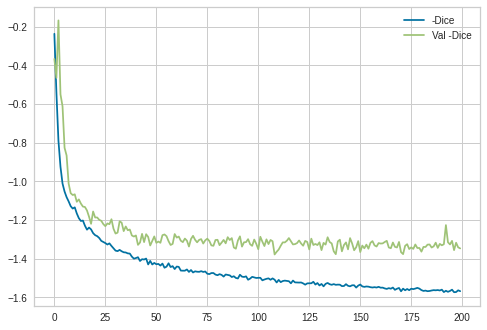

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++
Dice: 0.9871360204553091 +- 0.2141822401177324


In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

a = 1
# phi_units = 16
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')

for phi_units in [2,4,8,16,32,64,128]:
  results_template = 'results_a-{}_phi-units-{}' # string template
  basepath = results_template.format(a,phi_units)
  try:
    os.mkdir(basepath)
  except:
    print('File exists')

  tf.keras.backend.clear_session()

  seg_model = create_model(phi_units)

  seg_model.compile(optimizer=Adam(lr=1e-4),
                    loss={'output':dice_coef_loss},
                    metrics = metrics)

  callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                  monitor='val_output_loss',
                                                  verbose=0,
                                                  mode = 'min')]

  history = seg_model.fit(train_gen,
                          steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                          epochs=EPOCHS , 
                          callbacks=callbacks,
                          validation_data = val_gen,
                          validation_steps=len(df_val_images) // BATCH_SIZE)

  # seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


  plt.plot(history.history['loss'],label = '-Dice')
  plt.plot(history.history['val_loss'],label = 'Val -Dice')
  plt.legend()
  plt.savefig(basepath+'/LearningCurve.png')
  plt.show()


  seg_model.save(basepath+'/model.h5')
  ## Calculo de metricas de rendimiento. 


  filesname = df_test_images['filepath'].to_list()
  masks_files = df_test_images['mask'].to_list()
  # test_t = df_test_images['nerve_name'].to_list()
  template = 'there is nerve: {}\t Dice: {}\t AUC: {}'
  Acc = []
  Dice = []
  GM = []
  Sen = []
  Spe = []
  AUC = []
  CM = []
  there_is_nerve = []
  show = True
  for path_file,mask_file in zip(filesname,masks_files):
    image1 = cv2.resize(cv2.imread(path_file),(height,width))
    mask = cv2.resize(cv2.imread(mask_file,0),(height,width)).reshape(-1,)
    if mask.sum()==0:
      there_is_nerve.append(False)
    else:
      there_is_nerve.append(True)
      mask = mask/mask.max()
      mask[mask >= 0.5] = 1.
      mask[mask <0.5] = 0.
      if show:
        print('+++++++++++++++++++++++++++++++++++++')
        print(np.unique(mask))
        print('+++++++++++++++++++++++++++++++++++++')
        show = False
    # print(np.unique(mask))
    mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255)[0,:,:,:].astype(np.uint8)).reshape(-1,)
    CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
    Acc.append(accuracy_score(mask,mask_est))
    sen = recall_score(mask,mask_est,pos_label=1,zero_division=0)
    spe = recall_score(mask,mask_est,pos_label=0,zero_division=0)
    Sen.append(sen)
    Spe.append(spe)
    GM.append(sqrt(sen*spe))
    Dice.append(f1_score(mask,mask_est,pos_label=1,zero_division=0))
    try:
      AUC.append(roc_auc_score(mask,mask_est))
    except:
      AUC.append('null')

  mdict = {'Acc':Acc,
          'GM': GM,
          'Dice':Dice,
          'AUC':AUC,
          'Sen':Sen,
          'Spe':Spe,}

  pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.savefig(basepath+'/Boxplot_all')
  # plt.show()

  # for name_nerve in ['ciatico','cubital','femoral','mediano']:
  #   Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.title(name_nerve)
  # plt.savefig(basepath+'/Boxplot')
  # plt.show()

  savedata = {'Acc':Acc,
              'GM':GM,
              'Dice':Dice,
              'Sen':Sen,
              'Spe':Spe,
              'AUC':AUC,
              'CM':CM,
              'train':df_train_images.to_dict(),
              'test':df_test_images.to_dict(),
              'val':df_val_images.to_dict()}
  dump(savedata,basepath+'/results.joblib')

  print('Dice: {} +- {}'.format(np.mean(Acc),
                                np.std(Dice)
                                )
  )

excel_write.save()


In [ ]:
!zip -r results_Unet_RFF results* results.xlsx  

  adding: results_a-1_phi-units-128/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/saved_model.pb (deflated 90%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.index (deflated 75%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/keras_metadata.pb (deflated 94%)
  adding: results_a-1_phi-units-128/LearningCurve.png (deflated 5%)
  adding: results_a-1_phi-units-128/model.h5 (deflated 8%)
  adding: results_a-1_phi-units-128/results.joblib (deflated 69%)
  adding: results_a-1_phi-units-16/ (stored 0%)
  adding: results_a-1_phi-units-16/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-16/Model_Checkpoint/saved_mo